In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy.stats

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from matplotlib.legend import Legend

plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'text.usetex': True, 'text.latex.preview': True})

gator_orange = '#FA4616'
gator_blue = '#0021A5'

In [3]:
def hist_with_error(x, w, bin_edges, density=True, norm_to=1):
    sort_index = np.argsort(x)
    x = x[sort_index]
    w = w[sort_index]
    w /= np.sum(w)
    w_sq = w**2
    
    val = []
    err = []
    for i in range(len(bin_edges)-1):
        start = np.searchsorted(x, bin_edges[i])
        end = np.searchsorted(x, bin_edges[i+1])
        
        if density:
            val.append( np.sum(w[start:end]) / (bin_edges[i+1]-bin_edges[i]))
            err.append( (np.sum(w_sq[start:end]))**.5 / (bin_edges[i+1]-bin_edges[i]) )
        else:
            val.append(np.sum(w[start:end]))
            err.append((np.sum(w_sq[start:end]))**.5)
    
    val = np.array(val)
    err = np.array(err)
    
    bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
    
    return bin_centers, val*norm_to, err*norm_to

In [4]:
def softmax(phi_vec):
    tmp = np.exp(phi_vec)
    return tmp/np.sum(tmp)

def grad_softmax(bin_index, phi_vec):
    #shapes:
    #    bin_index: (batch, )
    #    phi_vec: (bins, )
    
    softmax_out = softmax(phi_vec) #shape = (bins, )
    bin_prob = softmax_out[bin_index] #shape = (batch, )
    
    N_batch = len(bin_index)
    batch_indices = np.arange(N_batch)
    
    gradient = -bin_prob[:, np.newaxis] * softmax_out[np.newaxis, :] #shape = (batch, bins)
    gradient[batch_indices, bin_index] += bin_prob
    
    return gradient

In [5]:
true_loc = 5.
true_scale = 2.

def normal_pdf(x, loc=true_loc, scale=true_scale):
    return scipy.stats.norm.pdf(x, loc, scale)

def normal_score(x, loc=true_loc, scale=true_scale):
    return (x-loc)/scale**2

def normal_scoresq(x, loc=true_loc, scale=true_scale):
    return (x-loc)**2/scale**4

def norm_fac(loc=true_loc, scale=true_scale): #for 0 to 10
    return 1 / (scipy.stats.norm.cdf(10, loc, scale) - scipy.stats.norm.cdf(0, loc, scale))

def fu_norm_fac(scale=true_scale): #for loc-2.5*scale to loc-2.5*scale
    return scale*(2*np.pi)**.5 / (2 - 2*np.exp(-25/8))

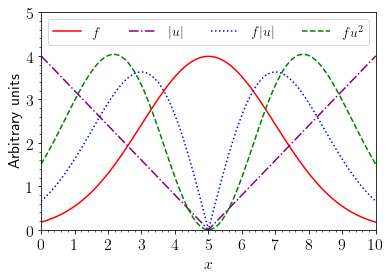

In [6]:
x = np.linspace(0, 10, 101)

fig, ax = plt.subplots()

ax.set_xlabel(r'$x$')
ax.set_xlim(0, 10)
ax.set_xticks(np.arange(11))
ax.xaxis.set_minor_locator(AutoMinorLocator())

color = 'red'
ax.set_ylabel(r'Arbitrary units')#, color=color)
ax.tick_params(axis='y', which='both')#, labelcolor=color, color=color)
ax.set_ylim(0, .25*20)
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.plot(x, 20*normal_pdf(x), color=color, label=r'$f$')
ax.plot(x, 20*.16 * np.absolute(normal_score(x)), linestyle='dashdot', color='purple', label=r'$|u|$')
ax.plot(x, 20*3*normal_pdf(x)*np.absolute(normal_score(x)), linestyle='dotted', color='blue', label=r'$f|u|$')
ax.plot(x, 20*5.5 * normal_pdf(x)*normal_scoresq(x), linestyle='dashed', color='green', label=r'$f u^2$')

plt.legend(ncol=4, fontsize=14)
None

In [7]:
x = np.linspace(0, 10, 101)

fig, ax = plt.subplots()

ax.set_xlabel(r'$x$')
ax.set_xlim(0, 10)
ax.set_xticks(np.arange(11))
ax.xaxis.set_minor_locator(AutoMinorLocator())

color = 'red'
ax.set_ylabel(r'Normalized distribution')
ax.tick_params(axis='y', which='both')
ax.set_ylim(0, .22)
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.plot(x, normal_pdf(x, true_loc+.3)*norm_fac(true_loc+.3), color=color, linestyle='dotted')
ax.plot(x, normal_pdf(x, true_loc-.3)*norm_fac(true_loc-.3), color=color, linestyle='dotted')
ax.plot(x, normal_pdf(x)*norm_fac(), color=color, label=r'$f$')

color='green'
ax.plot(x, normal_pdf(x)*np.absolute(normal_score(x))*fu_norm_fac(), color=color, linestyle=(0, (5, 3, 1, 3)), label=r'$f|u|$')
plt.legend()

plt.savefig('f_g-asymptotic.pdf', bbox_inches='tight')

In [8]:
x = np.linspace(0, 10, 101)

fig, ax1 = plt.subplots()

ax1.set_xlabel(r'$x$')
ax1.set_xlim(0, 10)
ax1.set_xticks(np.arange(11))
ax1.xaxis.set_minor_locator(AutoMinorLocator())

color = 'red'
ax1.set_ylabel(r'$f$', color=color)
ax1.tick_params(axis='y', which='both', labelcolor=color, color=color)
ax1.set_ylim(0, .22)
ax1.yaxis.set_minor_locator(AutoMinorLocator())

ax1.plot(x, normal_pdf(x, true_loc+.3), color=color, linestyle='dotted')
ax1.plot(x, normal_pdf(x, true_loc-.3), color=color, linestyle='dotted')
ax1.plot(x, normal_pdf(x), color=color)
ax1.spines['left'].set_color(color)
ax1.spines['right'].set_visible(False)

ax2 = ax1.twinx()
color='blue'
ax2.set_ylabel(
    r'$\frac{1}{f}\left[\frac{\partial f}{\partial \theta}\right]^2$',
    color=color, fontsize=22)
ax2.tick_params(axis='y', which='both', labelcolor=color, color=color)
ax2.set_ylim(0, .039)
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.plot(x, normal_pdf(x)*normal_scoresq(x), color=color, linestyle='dashed')
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_color(color)

plt.savefig('f_localshapesensitivity.pdf', bbox_inches='tight')

In [9]:
N_bins = 20

bins = np.array([(i*10/N_bins, (i+1)*10/N_bins) for i in range(N_bins)])

bin_volumes = np.array([bins[i][1] - bins[i][0] for i in range(N_bins)])
bin_edges = np.append(bins[:,0], bins[-1,1])

In [10]:
def sample(bin_prob_vec, size, pdf_func=normal_pdf):
    bin_id = np.random.choice(N_bins, size=size, p=bin_prob_vec)
    
    bin_lo = bins[bin_id, 0]
    bin_vol = bin_volumes[bin_id]
    
    x = bin_lo + np.random.random(size=size)*bin_vol
    
    bin_prob = bin_prob_vec[bin_id]
    prob_density = bin_prob/bin_vol
    weight = pdf_func(x)/prob_density
    
    return x, weight, bin_id, bin_prob, prob_density

In [11]:
N_train = 10_000
train_bin_prob_vec = np.ones(N_bins) / N_bins

pdf_func = normal_pdf
score_func = normal_score
scoresq_func = normal_scoresq

# Generating training data ##########
np.random.seed(0)

train_x, train_weight, train_bin_id, train_bin_prob, _ = sample(train_bin_prob_vec, N_train, pdf_func)

train_scoresq = scoresq_func(train_x)
train_aux1 = train_bin_prob * train_weight**2 * train_scoresq
train_aux2 = train_bin_prob * train_weight

In [12]:
# Training data distribution
fig, ax = plt.subplots()
ax.hist(train_x, density=True, bins=bin_edges, histtype='step')
ax.set_xlabel(r'$x$')
ax.set_ylabel('Normalized distribution')
None

In [13]:
def gradient_wrt_phi(phi_vec, train_bin_id, train_aux1, train_aux2, L_by_Ns=1.):
    bin_prob_vec = softmax(phi_vec) #shape = (bins, )
    bin_prob = bin_prob_vec[train_bin_id] #shape = (batch, )
    
    softmax_gradient = grad_softmax(train_bin_id, phi_vec) #shape = (batch, bins)
    
    tmp = train_aux1 / (bin_prob + L_by_Ns*train_aux2)**2 #shape = (batch, )
    gradient = tmp[:, np.newaxis] * softmax_gradient #shape= (batch, bins)
    
    gradient = np.mean(gradient, axis=0) #shape = (bins, )
    return gradient

def delta_phi(phi_vec, N_batch=20, learning_rate=1e-1, L_by_Ns=1.):
    batch = np.random.choice(N_train, size=N_batch)
    return learning_rate * gradient_wrt_phi(phi_vec, train_bin_id[batch], train_aux1[batch], train_aux2[batch], L_by_Ns)

In [14]:
L_by_Ns = 1

N_batch = 20
learning_rate = 1e-1
N_steps = 50_000
phi_vec_init = np.ones(N_bins)

phi_vec_case1 = phi_vec_init
np.random.seed(0)
for i in range(N_steps):
    phi_vec_case1 += delta_phi(phi_vec_case1, N_batch, learning_rate, L_by_Ns)

In [15]:
prob_case1 = softmax(phi_vec_case1)
prob_density_case1 = prob_case1/bin_volumes

In [16]:
L_by_Ns = 1/10

N_batch = 20
learning_rate = 1e-1
N_steps = 50_000
phi_vec_init = np.ones(N_bins)

phi_vec_case2 = phi_vec_init
np.random.seed(0)
for i in range(N_steps):
    phi_vec_case2 += delta_phi(phi_vec_case2, N_batch, learning_rate, L_by_Ns)

In [17]:
prob_case2 = softmax(phi_vec_case2)
prob_density_case2 = prob_case2/bin_volumes

In [18]:
L_by_Ns = 10

N_batch = 20
learning_rate = 5e-1
N_steps = 100_000
phi_vec_init = np.ones(N_bins)

phi_vec_case3 = phi_vec_init
np.random.seed(0)
for i in range(N_steps):
    phi_vec_case3 += delta_phi(phi_vec_case3, N_batch, learning_rate, L_by_Ns)

In [19]:
prob_case3 = softmax(phi_vec_case3)
prob_density_case3 = prob_case3/bin_volumes

In [20]:
fig, ax = plt.subplots()

ax.set_xlabel(r'$x$')
ax.set_xlim(0, 10)
ax.set_xticks(np.arange(11))
ax.xaxis.set_minor_locator(AutoMinorLocator())

x = np.linspace(0, 10, 101)
plt.plot(x, normal_pdf(x)*norm_fac(), linewidth=1, color='red', label='IS')

plt.plot(bin_edges, np.append(prob_density_case1, prob_density_case1[-1]), drawstyle='steps-post', linewidth=1,
         color='blue', linestyle='dashed', dashes=(4, 4), label='OASIS')

ax.set_ylabel(r'Normalized distribution', fontsize=18)
plt.ylim(0, .24)
ax.yaxis.set_minor_locator(AutoMinorLocator())

plt.legend(fontsize=14)

plt.savefig('IS_OASIS_LbyNs=1.pdf', bbox_inches='tight')

In [21]:
fig, [ax1, ax2] = plt.subplots(nrows=2, gridspec_kw={'height_ratios': [5, 1.5]}, figsize=(6, 7))

ax1.set_xlim(0, 10)
ax1.set_xticks(np.arange(11))
ax1.xaxis.set_minor_locator(AutoMinorLocator())


x = np.linspace(0, 10, 101)

ax1.plot(bin_edges, np.append(prob_density_case3, prob_density_case3[-1]), drawstyle='steps-post', linewidth=1,
         color='red', linestyle='solid', label=r'\LARGE$\frac{L}{N_s} = 10$')

ax1.plot(bin_edges, np.append(prob_density_case1, prob_density_case1[-1]), drawstyle='steps-post', linewidth=1,
         color='blue', linestyle='dashed', dashes=(4, 4), label=r'\LARGE$\frac{L}{N_s} = 1$')

ax1.plot(bin_edges, np.append(prob_density_case2, prob_density_case2[-1]), drawstyle='steps-post', linewidth=1.5,
         color='magenta', linestyle='dotted', label=r'\LARGE$\frac{L}{N_s} = 0.1$')

ax1.plot(x, normal_pdf(x)*np.absolute(normal_score(x))*fu_norm_fac(),
         color='green', linestyle=(0, (5, 3, 1, 3)), label=r'\LARGE$\frac{L}{N_s} \rightarrow 0$', linewidth=1.5)

ax1.set_ylabel(r'Normalized distribution', fontsize=18)
ax1.set_ylim(0, .30)
ax1.yaxis.set_minor_locator(AutoMinorLocator())

ax1.legend(ncol=2, fontsize=12)

ax2.plot(x, np.abs(score_func(x)), color='black')
ax2.set_xlim(0, 10)
ax2.set_ylim(0, 1.25)
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.set_ylabel(r'$|u|$', fontsize=20)
ax2.set_xlabel(r'$x$', fontsize=18)
ax2.set_xticks(np.arange(11))
ax2.xaxis.set_minor_locator(AutoMinorLocator())

plt.savefig('OASIS_LbyNs=all.pdf', bbox_inches='tight')

In [22]:
N_test = 100_000

np.random.seed(1)
test_x_case1, test_weight_case1, _, _, _ = sample(prob_case1, N_test, pdf_func)
test_scoresq_case1 = normal_scoresq(test_x_case1)

np.random.seed(1)
test_x_case2, test_weight_case2, _, _, _ = sample(prob_case2, N_test, pdf_func)
test_scoresq_case2 = normal_scoresq(test_x_case2)

np.random.seed(1)
test_x_case3, test_weight_case3, _, _, _ = sample(prob_case3, N_test, pdf_func)
test_scoresq_case3 = normal_scoresq(test_x_case3)

np.random.seed(1)
true_sim_x = scipy.stats.truncnorm.rvs((0 - true_loc)/true_scale, (10 - true_loc)/true_scale,
                                       loc=true_loc, scale=true_scale, size=N_test)
true_sim_weight = np.ones(N_test)/norm_fac()
true_sim_scoresq = normal_scoresq(true_sim_x)

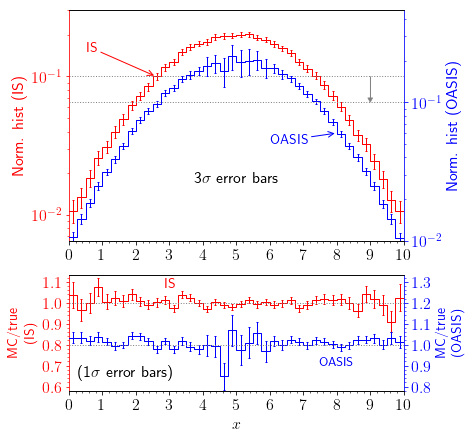

In [23]:
hist_bin_edges = np.linspace(0, 10, 41)
hist_bin_centers, oasis_prob_density, oasis_prob_density_err = hist_with_error(test_x_case1, test_weight_case1, hist_bin_edges)
hist_bin_centers, is_prob_density, is_prob_density_err = hist_with_error(true_sim_x, true_sim_weight, hist_bin_edges)

fig, [ax1, ax3] = plt.subplots(nrows=2, gridspec_kw={'height_ratios': [4, 2]}, figsize=(6, 7))

ax1.set_xlim(0, 10)
ax1.set_xticks(np.arange(11))
ax1.xaxis.set_minor_locator(AutoMinorLocator())

y_range = (.1+2*.1) / (.01-.0035)

color = 'red'
ax1.set_ylabel(r'Norm. hist (IS)', color=color)
ax1.tick_params(axis='y', which='both', labelcolor=color, color=color)
ax1.set_ylim(.01-.0035, (.01-.0035)*y_range)
ax1.yaxis.set_minor_locator(AutoMinorLocator())

ax1.plot(hist_bin_edges, np.append(is_prob_density, is_prob_density[-1]), drawstyle='steps-post', color=color, linewidth=1)
ax1.errorbar(hist_bin_centers, is_prob_density, yerr=3*is_prob_density_err, 
             linewidth=0, elinewidth=1, color=color, capsize=1)
ax1.plot([0,10], [.1,.1], color='gray', linewidth=1, linestyle='dotted')
ax1.set_yscale('log')

ax1.spines['left'].set_color(color)
ax1.spines['right'].set_visible(False)

ax2 = ax1.twinx()
color='blue'
ax2.set_ylabel(r'Norm. hist (OASIS)', color=color)
ax2.tick_params(axis='y', which='both', labelcolor=color, color=color)
ax2.set_ylim(.01, .01*y_range)
ax2.yaxis.set_minor_locator(AutoMinorLocator())

ax2.plot(hist_bin_edges, np.append(oasis_prob_density, oasis_prob_density[-1]), drawstyle='steps-post',
         color=color, linewidth=1)#, linestyle='dashed', dashes=(3, 3))
ax2.errorbar(hist_bin_centers, oasis_prob_density, yerr=3*oasis_prob_density_err, 
             linewidth=0, elinewidth=1, color=color, capsize=1)
ax2.plot([0,10], [.1,.1], color='gray', linewidth=1, linestyle='dotted')

ax2.set_yscale('log')

ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_color(color)

ax1.arrow(9, .1, 0, -.035, color='gray', length_includes_head=True,
         head_width=.15, head_length=.005, linewidth=.5)

ax1.annotate('IS', xy=(2.6, .1), xytext=(.5,.15), 
             fontsize=14, color='red', arrowprops={'arrowstyle':'->', 'color':'red'})

ax2.annotate('OASIS', xy=(8, .06), xytext=(6,.05), 
             fontsize=14, color='blue', arrowprops={'arrowstyle':'->', 'color':'blue'})

ax1.text(5, .017, r'3$\sigma$ error bars', horizontalalignment='center')

##############

ax3.set_xlabel(r'$x$')
ax3.set_xlim(0, 10)
ax3.set_xticks(np.arange(11))
ax3.xaxis.set_minor_locator(AutoMinorLocator())

true_bin_prob_density = scipy.stats.truncnorm.cdf(hist_bin_edges[1:], a=(0-true_loc)/true_scale, b=(10-true_loc)/true_scale,
                               loc=true_loc, scale=true_scale) - \
                        scipy.stats.truncnorm.cdf(hist_bin_edges[:-1], a=(0-true_loc)/true_scale, b=(10-true_loc)/true_scale,
                               loc=true_loc, scale=true_scale)
true_bin_prob_density /= (10/40)

color='red'
ax3.set_ylabel('MC/true\n(IS)', color=color, fontsize=14)
ax3.tick_params(axis='y', which='both', labelcolor=color, color=color)
ax3.set_ylim(.78-.2, 1.13)
ax3.set_yticks([.6, .7, .8, .9, 1, 1.1])
ax3.yaxis.set_minor_locator(AutoMinorLocator())

ax3.plot(np.linspace(0, 10, 41), np.append(is_prob_density, is_prob_density[-1])/np.append(true_bin_prob_density, true_bin_prob_density[-1]),
         drawstyle='steps-post', color=color, linewidth=1)
ax3.errorbar(hist_bin_centers, is_prob_density/true_bin_prob_density, yerr=is_prob_density_err/true_bin_prob_density, 
             linewidth=0, elinewidth=1, color=color, capsize=1)

ax3.spines['left'].set_color(color)
ax3.spines['right'].set_visible(False)

ax4 = ax3.twinx()
color='blue'
ax4.set_ylabel('MC/true\n(OASIS)', color=color, fontsize=14)
ax4.tick_params(axis='y', which='both', labelcolor=color, color=color)
ax4.set_ylim(.78, 1.13+.2)
ax4.set_yticks([.8, .9, 1, 1.1, 1.2, 1.3])
ax4.yaxis.set_minor_locator(AutoMinorLocator())
ax4.plot(np.linspace(0, 10, 41), np.append(oasis_prob_density, oasis_prob_density[-1])/np.append(true_bin_prob_density, true_bin_prob_density[-1]),
         drawstyle='steps-post', color=color, linewidth=1)
ax4.errorbar(hist_bin_centers, oasis_prob_density/true_bin_prob_density, yerr=oasis_prob_density_err/true_bin_prob_density, 
             linewidth=0, elinewidth=1, color=color, capsize=1)

ax4.spines['left'].set_visible(False)
ax4.spines['right'].set_color(color)

ax3.plot([0,10], [1,1], color='gray', linestyle='dotted', linewidth=1)
ax4.plot([0,10], [1,1], color='gray', linestyle='dotted', linewidth=1)

ax3.text(3, 1.07, 'IS', fontsize=14, horizontalalignment='center', color='red')
ax4.text(8, .9, 'OASIS', fontsize=13, horizontalalignment='center', color='blue')

ax3.text(1.7, .65, r'(1$\sigma$ error bars)', horizontalalignment='center')

plt.savefig('IS_OASIS_hist_compare.pdf', bbox_inches='tight')

In [24]:
def rel_weight_func(x, bin_prob, bin_volume):
    IS_g = scipy.stats.truncnorm.pdf(x, a=(0-true_loc)/true_scale, b=(10-true_loc)/true_scale, loc=true_loc, scale=true_scale)
    OASIS_g = bin_prob/bin_volume
    return IS_g/OASIS_g

x = np.array([])
rel_weight = np.array([])
for i in range(N_bins):
    cur_x = np.linspace(bins[i][0], bins[i][1], 100)
    x = np.append(x, cur_x)
    rel_weight = np.append(rel_weight, rel_weight_func(cur_x, prob_case1[i], bin_volumes[i]))

fig, ax = plt.subplots()

ax.set_xlabel(r'$x$')
ax.set_xlim(0, 10)
ax.set_xticks(np.arange(11))
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(axis='y', which='both')
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_yscale('log')

plot1 = ax.plot(x, rel_weight, color='magenta', linewidth=1, label=r'\huge$\frac{w_\mathrm{OASIS}}{w_\mathrm{unweighted}}$')
plot2 = ax.plot(hist_bin_centers, (oasis_prob_density_err / is_prob_density_err)**2, 
         linewidth=0, marker='x', color='black', markersize=5, label=r'Est. {\huge$\frac{\sigma^2_\mathrm{OASIS}}{\sigma^2_\mathrm{unweighted}}$}')

ax.plot([0,10], [1,1], linestyle='dashed', color='gray')

ax.legend(plot1, [r'$\frac{w_{\mathrm{OASIS}}}{w_{\mathrm{IS}}}$'],
          fontsize=22, numpoints=2, loc=1, borderpad=.36, borderaxespad=.2)
ax.add_artist(Legend(ax, plot2, [r'{$\frac{\sigma^2_{\mathrm{OASIS}}}{\sigma^2_{\mathrm{IS}}}$}'],
                     fontsize=22, numpoints=3, loc=2, borderpad=.15, borderaxespad=.2))

plt.savefig('IS_OASIS_relweight.pdf', bbox_inches='tight')

In [25]:
def evaluate(weight, scoresq, L_by_Ns):
    tmp = weight * scoresq / (1 + L_by_Ns*weight)
    return np.mean(tmp), np.std(tmp) / len(weight)**.5

In [26]:
print(evaluate(test_weight_case1, test_scoresq_case1, 1))
print(evaluate(test_weight_case2, test_scoresq_case2, 1))
print(evaluate(test_weight_case3, test_scoresq_case3, 1))
print(evaluate(true_sim_weight, true_sim_scoresq, 1))

print(evaluate(test_weight_case1, test_scoresq_case1, 0))
print(evaluate(test_weight_case2, test_scoresq_case2, 0))
print(evaluate(test_weight_case3, test_scoresq_case3, 0))
print(evaluate(true_sim_weight, true_sim_scoresq, 0))

ulim = evaluate(test_weight_case1, test_scoresq_case1, 0)[0]

(0.14711583326480887, 0.00016975961713249648)
(0.1436760502038999, 0.00026448101144066905)
(0.1272982876464449, 9.7783844930988e-05)
(0.11381808885226344, 0.0004568366543739644)
(0.22517920600567232, 0.00016295794438225163)
(0.2256184477972752, 0.0003061861871641512)
(0.223906005799238, 0.0009015360945452341)
(0.22622263322494285, 0.0009079997032835096)


In [27]:
Ns_by_L_list = np.logspace(np.log10(.08), np.log10(30), 1000)

OASIS_performance_case1 = []
OASIS_performance_case2 = []
OASIS_performance_case3 = []

IS_performance = []
for _ in Ns_by_L_list:
    L_by_Ns = 1/_
    
    OASIS_performance_case1.append(evaluate(test_weight_case1, test_scoresq_case1, L_by_Ns))
    OASIS_performance_case2.append(evaluate(test_weight_case2, test_scoresq_case2, L_by_Ns))
    OASIS_performance_case3.append(evaluate(test_weight_case3, test_scoresq_case3, L_by_Ns))
    IS_performance.append(evaluate(true_sim_weight, true_sim_scoresq, L_by_Ns))

OASIS_performance_case1 = np.array(OASIS_performance_case1)
OASIS_performance_case2 = np.array(OASIS_performance_case2)
OASIS_performance_case3 = np.array(OASIS_performance_case3)
IS_performance = np.array(IS_performance)

In [28]:
fig, ax = plt.subplots()

ax.plot(Ns_by_L_list, OASIS_performance_case1[:,0], color='blue', linestyle='dashed', dashes=(4, 4), label='OASIS (training $L/N_s=1$)')
ax.plot(Ns_by_L_list, IS_performance[:,0], color='red', label='IS')

ax.plot([.08, 20], [ulim, ulim], color='gray', linestyle=(0, (5, 3, 1, 3)), label=r'Upper limit')

ax.set_xlabel(r'$N_s\,/\,L$')
ax.set_ylabel(r'$\displaystyle\frac{I_\mathrm{MC}}{L}$')

ax.set_xscale('log')
ax.set_xlim(.08, 20)
ax.set_ylim(0, .24)
ax.yaxis.set_minor_locator(AutoMinorLocator())

y_val = OASIS_performance_case1[np.searchsorted(Ns_by_L_list[:], 1)][0]
N_low = Ns_by_L_list[np.searchsorted(OASIS_performance_case1[:,0], y_val)]
N_high = Ns_by_L_list[np.searchsorted(IS_performance[:,0], y_val)]

color='purple'

ax.plot([N_low, N_low], [0, y_val],
        color=color, linestyle='dotted')
ax.plot([N_high, N_high], [0, y_val],
        color=color, linestyle='dotted')
ax.plot([N_low, N_high], [y_val, y_val],
        color=color, linestyle='dotted')
ax.arrow(N_low, .03, N_high - N_low, 0,
        color=color, length_includes_head=True, head_width=.007, head_length=.15)
imp_percent = int((N_high-N_low)*100/N_low)
ax.text((N_high+N_low)/2 * .86, .01, f'{imp_percent}\% more',
        horizontalalignment='center', fontsize=14, color=color)

y_val = OASIS_performance_case1[np.searchsorted(Ns_by_L_list[:], 10)][0]
N_low = Ns_by_L_list[np.searchsorted(OASIS_performance_case1[:,0], y_val)]
N_high = Ns_by_L_list[np.searchsorted(IS_performance[:,0], y_val)]

ax.plot([N_low, N_low], [0, y_val],
        color='gray', linestyle='dotted')
ax.plot([N_high, N_high], [0, y_val],
        color='gray', linestyle='dotted')
ax.plot([N_low, N_high], [y_val, y_val],
        color='gray', linestyle='dotted')
ax.arrow(N_low, .03, N_high - N_low, 0,
        color='gray', length_includes_head=True, head_width=.007, head_length=1)
imp_percent = int((N_high-N_low)*100/N_low)
ax.text((N_high+N_low)/2 * .95, .01, f'{imp_percent}\% more',
        horizontalalignment='center', fontsize=14)

y_val = OASIS_performance_case1[np.searchsorted(Ns_by_L_list[:], .18)][0]
N_low = Ns_by_L_list[np.searchsorted(OASIS_performance_case1[:,0], y_val)]
N_high = Ns_by_L_list[np.searchsorted(IS_performance[:,0], y_val)]

ax.plot([N_low, N_low], [0, y_val],
        color='gray', linestyle='dotted')
ax.plot([N_high, N_high], [0, y_val],
        color='gray', linestyle='dotted')
ax.plot([N_low, N_high], [y_val, y_val],
        color='gray', linestyle='dotted')
ax.arrow(N_low, .03, N_high - N_low, 0,
        color='gray', length_includes_head=True, head_width=.007, head_length=.03)
imp_percent = int((N_high-N_low)*100/N_low)
ax.text((N_high+N_low)/2 * .7, .01, f'{imp_percent}\% more',
        horizontalalignment='center', fontsize=14)

plt.legend(fontsize=15, bbox_to_anchor=(-.02, .97), bbox_transform=ax.transAxes, frameon=False, loc=2)
plt.savefig('moneyplot1_case1.pdf', bbox_inches='tight')

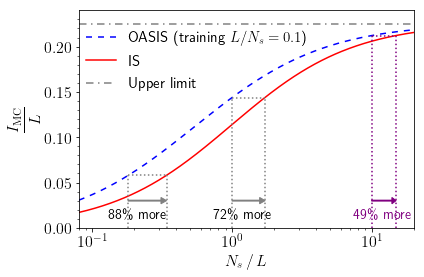

In [29]:
fig, ax = plt.subplots()

ax.plot(Ns_by_L_list, OASIS_performance_case2[:,0], color='blue', linestyle='dashed', dashes=(4, 4), label='OASIS (training $L/N_s=0.1$)')
ax.plot(Ns_by_L_list, IS_performance[:,0], color='red', label='IS')

ax.plot([.08, 20], [ulim, ulim], color='gray', linestyle=(0, (5, 3, 1, 3)), label=r'Upper limit')

ax.set_xlabel(r'$N_s\,/\,L$')
ax.set_ylabel(r'$\displaystyle\frac{I_\mathrm{MC}}{L}$')

ax.set_xscale('log')
ax.set_xlim(.08, 20)
ax.set_ylim(0, .24)
ax.yaxis.set_minor_locator(AutoMinorLocator())

y_val = OASIS_performance_case2[np.searchsorted(Ns_by_L_list[:], 1)][0]
N_low = Ns_by_L_list[np.searchsorted(OASIS_performance_case2[:,0], y_val)]
N_high = Ns_by_L_list[np.searchsorted(IS_performance[:,0], y_val)]

ax.plot([N_low, N_low], [0, y_val],
        color='gray', linestyle='dotted')
ax.plot([N_high, N_high], [0, y_val],
        color='gray', linestyle='dotted')
ax.plot([N_low, N_high], [y_val, y_val],
        color='gray', linestyle='dotted')
ax.arrow(N_low, .03, N_high - N_low, 0,
        color='gray', length_includes_head=True, head_width=.007, head_length=.15)
imp_percent = int((N_high-N_low)*100/N_low)
ax.text((N_high+N_low)/2 * .86, .01, f'{imp_percent}\% more',
        horizontalalignment='center', fontsize=14)

y_val = OASIS_performance_case2[np.searchsorted(Ns_by_L_list[:], 10)][0]
N_low = Ns_by_L_list[np.searchsorted(OASIS_performance_case2[:,0], y_val)]
N_high = Ns_by_L_list[np.searchsorted(IS_performance[:,0], y_val)]

color='purple'
ax.plot([N_low, N_low], [0, y_val],
        color=color, linestyle='dotted')
ax.plot([N_high, N_high], [0, y_val],
        color=color, linestyle='dotted')
ax.plot([N_low, N_high], [y_val, y_val],
        color=color, linestyle='dotted')
ax.arrow(N_low, .03, N_high - N_low, 0,
        color=color, length_includes_head=True, head_width=.007, head_length=1)
imp_percent = int((N_high-N_low)*100/N_low)
ax.text((N_high+N_low)/2 * .95, .01, f'{imp_percent}\% more',
        horizontalalignment='center', fontsize=14, color=color)

y_val = OASIS_performance_case2[np.searchsorted(Ns_by_L_list[:], .18)][0] #.06
N_low = Ns_by_L_list[np.searchsorted(OASIS_performance_case2[:,0], y_val)]
N_high = Ns_by_L_list[np.searchsorted(IS_performance[:,0], y_val)]

ax.plot([N_low, N_low], [0, y_val],
        color='gray', linestyle='dotted')
ax.plot([N_high, N_high], [0, y_val],
        color='gray', linestyle='dotted')
ax.plot([N_low, N_high], [y_val, y_val],
        color='gray', linestyle='dotted')
ax.arrow(N_low, .03, N_high - N_low, 0,
        color='gray', length_includes_head=True, head_width=.007, head_length=.03)
imp_percent = int((N_high-N_low)*100/N_low)
ax.text((N_high+N_low)/2 * .8, .01, f'{imp_percent}\% more',
        horizontalalignment='center', fontsize=14)

plt.legend(fontsize=15, bbox_to_anchor=(-.02, .97), bbox_transform=ax.transAxes, frameon=False, loc=2)
plt.savefig('moneyplot1_case2.pdf', bbox_inches='tight')

In [30]:
fig, ax = plt.subplots()

ax.plot(Ns_by_L_list, OASIS_performance_case3[:,0], color='blue', linestyle='dashed', dashes=(4, 4), label='OASIS (training $L/N_s=0.1$)')
ax.plot(Ns_by_L_list, IS_performance[:,0], color='red', label='IS')

ulim = evaluate(true_sim_weight, true_sim_scoresq, 0)[0]

ax.plot([.08, 20], [ulim, ulim], color='gray', linestyle=(0, (5, 3, 1, 3)), label=r'Upper limit')

ax.set_xlabel(r'$N_s\,/\,L$')
ax.set_ylabel(r'$\displaystyle\frac{I_\mathrm{MC}}{L}$')

ax.set_xscale('log')
ax.set_xlim(.08, 20)
ax.set_ylim(0, .24)
ax.yaxis.set_minor_locator(AutoMinorLocator())

y_val = OASIS_performance_case3[np.searchsorted(Ns_by_L_list[:], 1)][0]
N_low = Ns_by_L_list[np.searchsorted(OASIS_performance_case3[:,0], y_val)]
N_high = Ns_by_L_list[np.searchsorted(IS_performance[:,0], y_val)]

ax.plot([N_low, N_low], [0, y_val],
        color='gray', linestyle='dotted')
ax.plot([N_high, N_high], [0, y_val],
        color='gray', linestyle='dotted')
ax.plot([N_low, N_high], [y_val, y_val],
        color='gray', linestyle='dotted')
ax.arrow(N_low, .03, N_high - N_low, 0,
        color='gray', length_includes_head=True, head_width=.007, head_length=.08)
imp_percent = int((N_high-N_low)*100/N_low)
ax.text((N_high+N_low)/2 * 1.1, .01, f'{imp_percent}\% more',
        horizontalalignment='center', fontsize=14)

y_val = OASIS_performance_case3[np.searchsorted(Ns_by_L_list[:], 10)][0]
N_low = Ns_by_L_list[np.searchsorted(OASIS_performance_case3[:,0], y_val)]
N_high = Ns_by_L_list[np.searchsorted(IS_performance[:,0], y_val)]

color='purple'
ax.plot([N_low, N_low], [0, y_val],
        color=color, linestyle='dotted')
ax.plot([N_high, N_high], [0, y_val],
        color=color, linestyle='dotted')
ax.plot([N_low, N_high], [y_val, y_val],
        color=color, linestyle='dotted')
ax.arrow(N_low, .03, N_high - N_low, 0,
        color=color, length_includes_head=True, head_width=.007, head_length=.4)
imp_percent = int((N_high-N_low)*100/N_low)
ax.text((N_high+N_low)/2 * .83, .01, f'{imp_percent}\% more',
        horizontalalignment='center', fontsize=14, color=color)

y_val = OASIS_performance_case3[np.searchsorted(Ns_by_L_list[:], .18)][0] #.06
N_low = Ns_by_L_list[np.searchsorted(OASIS_performance_case3[:,0], y_val)]
N_high = Ns_by_L_list[np.searchsorted(IS_performance[:,0], y_val)]

ax.plot([N_low, N_low], [0, y_val],
        color='gray', linestyle='dotted')
ax.plot([N_high, N_high], [0, y_val],
        color='gray', linestyle='dotted')
ax.plot([N_low, N_high], [y_val, y_val],
        color='gray', linestyle='dotted')
ax.arrow(N_low, .03, N_high - N_low, 0,
        color='gray', length_includes_head=True, head_width=.007, head_length=.03)
imp_percent = int((N_high-N_low)*100/N_low)
ax.text((N_high+N_low)/2 * .8, .01, f'{imp_percent}\% more',
        horizontalalignment='center', fontsize=14)

plt.legend(fontsize=15, bbox_to_anchor=(-.02, .97), bbox_transform=ax.transAxes, frameon=False, loc=2)
plt.savefig('moneyplot1_case3.pdf', bbox_inches='tight')

49.69570348193822
84.24283651008139
179.09571097089986


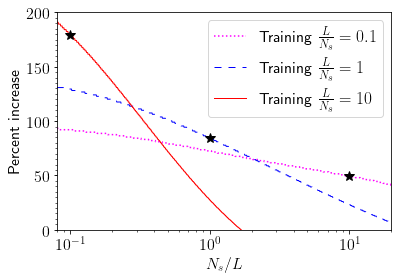

In [31]:
improvement_percent_case1 = []
improvement_percent_case2 = []
improvement_percent_case3 = []

for _ in Ns_by_L_list:
    if _ > 20:
        break
    
    y_val = OASIS_performance_case1[np.searchsorted(Ns_by_L_list[:], _)][0]
    N_low = Ns_by_L_list[np.searchsorted(OASIS_performance_case1[:,0], y_val)]
    N_high = Ns_by_L_list[np.searchsorted(IS_performance[:,0], y_val)]
    improvement_percent_case1.append((N_high-N_low)*100/N_low)
    
    y_val = OASIS_performance_case2[np.searchsorted(Ns_by_L_list[:], _)][0]
    N_low = Ns_by_L_list[np.searchsorted(OASIS_performance_case2[:,0], y_val)]
    N_high = Ns_by_L_list[np.searchsorted(IS_performance[:,0], y_val)]
    improvement_percent_case2.append((N_high-N_low)*100/N_low)
    
    y_val = OASIS_performance_case3[np.searchsorted(Ns_by_L_list[:], _)][0]
    N_low = Ns_by_L_list[np.searchsorted(OASIS_performance_case3[:,0], y_val)]
    N_high = Ns_by_L_list[np.searchsorted(IS_performance[:,0], y_val)]
    improvement_percent_case3.append((N_high-N_low)*100/N_low)

len_list = len(improvement_percent_case1)
fig, ax = plt.subplots()
ax.plot(Ns_by_L_list[:len_list], improvement_percent_case2, linewidth=1.5,
         color='magenta', linestyle='dotted', label=r'{Training} \LARGE$\frac{L}{N_s} = 0.1$')
ax.plot(Ns_by_L_list[:len_list], improvement_percent_case1, linewidth=1,
         color='blue', linestyle='dashed', dashes=(7, 7), label=r'{Training} \LARGE$\frac{L}{N_s} = 1$')
ax.plot(Ns_by_L_list[:len_list], improvement_percent_case3, linewidth=1,
         color='red', linestyle='solid', label=r'{Training} \LARGE$\frac{L}{N_s} = 10$')

ax.set_xlim(.08, 20)
ax.set_xscale('log')
ax.set_xlabel(r'$N_s/L$')
ax.set_ylim(0, 200)
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.set_ylabel('Percent increase')

y_val = OASIS_performance_case2[np.searchsorted(Ns_by_L_list[:], 10)][0] #.06
N_low = Ns_by_L_list[np.searchsorted(OASIS_performance_case2[:,0], y_val)]
N_high = Ns_by_L_list[np.searchsorted(IS_performance[:,0], y_val)]
ax.plot([10], [(N_high-N_low)*100/N_low], color='black', linewidth=0, marker='*', markersize=10)
print((N_high-N_low)*100/N_low)

y_val = OASIS_performance_case1[np.searchsorted(Ns_by_L_list[:], 1)][0] #.06
N_low = Ns_by_L_list[np.searchsorted(OASIS_performance_case1[:,0], y_val)]
N_high = Ns_by_L_list[np.searchsorted(IS_performance[:,0], y_val)]
ax.plot([1], [(N_high-N_low)*100/N_low], color='black', linewidth=0, marker='*', markersize=10)
print((N_high-N_low)*100/N_low)

y_val = OASIS_performance_case3[np.searchsorted(Ns_by_L_list[:], .1)][0] #.06
N_low = Ns_by_L_list[np.searchsorted(OASIS_performance_case3[:,0], y_val)]
N_high = Ns_by_L_list[np.searchsorted(IS_performance[:,0], y_val)]
ax.plot([.1], [(N_high-N_low)*100/N_low], color='black', linewidth=0, marker='*', markersize=10)
print((N_high-N_low)*100/N_low)

ax.legend()
plt.savefig('moneyplot2.pdf', bbox_inches='tight')

In [32]:
def _likelihood_chisq_gof(trial_loc):
    expected_bin_prob = scipy.stats.truncnorm.cdf(hist_bin_edges[1:], a=(0-trial_loc)/true_scale, b=(10-trial_loc)/true_scale,
                                                  loc=trial_loc, scale=true_scale) - \
                        scipy.stats.truncnorm.cdf(hist_bin_edges[:-1], a=(0-trial_loc)/true_scale, b=(10-trial_loc)/true_scale,
                                                  loc=trial_loc, scale=true_scale)
    expected_bin_counts = expected_bin_prob * L/norm_fac(loc=trial_loc)
    return np.sum((real_val - expected_bin_counts)**2 / (real_err**2))

def _OASIS_chisq_gof(trial_loc):
    OASIS_data_trial_weight = normal_pdf(OASIS_data_x, loc=trial_loc)/OASIS_data_g
    _, OASIS_val, OASIS_err = hist_with_error(OASIS_data_x, OASIS_data_trial_weight, hist_bin_edges,
                                              density=False, norm_to = L*np.mean(OASIS_data_trial_weight))
    return np.sum((real_val - OASIS_val)**2 / (real_err**2 + OASIS_err**2))

def _IS_chisq_gof(trial_loc):
    IS_data_trial_weight = normal_pdf(IS_data_x, loc=trial_loc)/IS_data_g
    _, IS_val, IS_err = hist_with_error(IS_data_x, IS_data_trial_weight, hist_bin_edges,
                                        density=False, norm_to = L*np.mean(IS_data_trial_weight))
    return np.sum((real_val - IS_val)**2 / (real_err**2 + IS_err**2))

Nreal = [9887]


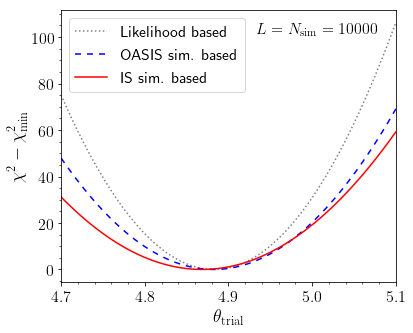

In [33]:
underlying_loc = 4.9
sampling_loc = 5

L = N_sim = 10_000

N_hist_bins=40
hist_bin_edges = np.linspace(0, 10, N_hist_bins+1)

seed_offset=100
# Real data
np.random.seed(seed_offset+0)
N_real = np.random.poisson(lam=L/norm_fac(loc=underlying_loc), size=1)
real_data_x = scipy.stats.truncnorm.rvs((0 - underlying_loc)/true_scale, (10 - underlying_loc)/true_scale,
                                        loc=underlying_loc, scale=true_scale, size=N_real)
real_data_weight = np.ones(N_real)
print(f'Nreal = {N_real}')

_, real_val, real_err = hist_with_error(real_data_x, real_data_weight, hist_bin_edges, 
                                        density=False, norm_to = N_real)



# OASIS simulation
np.random.seed(seed_offset+1)
OASIS_data_x, _, _, _, OASIS_data_g = sample(prob_case1, N_sim, pdf_func)

#IS simulation
np.random.seed(seed_offset+2)
IS_data_x = scipy.stats.truncnorm.rvs((0 - sampling_loc)/true_scale, (10 - sampling_loc)/true_scale,
                                      loc=sampling_loc, scale=true_scale, size=N_sim)
IS_data_g = normal_pdf(IS_data_x, loc=sampling_loc)*norm_fac(loc=sampling_loc)

trial_loc_array = np.linspace(4.7, 5.1, 101)
likelihood_chisq_array = np.array([_likelihood_chisq_gof(trial_loc) for trial_loc in trial_loc_array])
OASIS_chisq_array = np.array([_OASIS_chisq_gof(trial_loc) for trial_loc in trial_loc_array])
IS_chisq_array = np.array([_IS_chisq_gof(trial_loc) for trial_loc in trial_loc_array])

tmp = scipy.optimize.minimize_scalar(_likelihood_chisq_gof, bounds=(3, 7), method='bounded', options={'xatol':1e-9})
assert tmp['success']
likelihood_estimate = tmp['x']
likelihood_min_chisq = tmp['fun']

tmp = scipy.optimize.minimize_scalar(_OASIS_chisq_gof, bounds=(3, 7), method='bounded', options={'xatol':1e-9})
assert tmp['success']
OASIS_estimate = tmp['x']
OASIS_min_chisq = tmp['fun']

tmp = scipy.optimize.minimize_scalar(_IS_chisq_gof, bounds=(3, 7), method='bounded', options={'xatol':1e-9})
assert tmp['success']
IS_estimate = tmp['x']
IS_min_chisq = tmp['fun']

fig, ax = plt.subplots(figsize=(6,5))

ax.set_xlim(4.7, 5.1)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.set_xlabel(r'$\theta_\mathrm{trial}$', fontsize=18)
ax.set_ylabel(r'$\chi^2 - \chi^2_\mathrm{min}$', fontsize=18)

plt.plot(trial_loc_array, likelihood_chisq_array-likelihood_min_chisq, color='gray', linestyle='dotted', label='Likelihood based')
plt.plot(trial_loc_array, OASIS_chisq_array-OASIS_min_chisq, color='blue', linestyle='dashed', dashes=(4, 4), label='OASIS sim. based')
plt.plot(trial_loc_array, IS_chisq_array-IS_min_chisq, color='red', label='IS sim. based')

plt.text(5.006, 102, r"$L = N_\mathrm{sim} = 10000$", ha='center')

plt.legend()
plt.savefig('moneyplot3.pdf', bbox_inches='tight')

In [34]:
"""Results from running this code block are stored in the next"""

# L = N_sim = 100_000 #10_000
# N_pseudo_experiments = 500 #2000
# likelihood_estimates = []
# OASIS_estimates = []
# IS_estimates = []

# N_hist_bins=40
# hist_bin_edges = np.linspace(0, 10, 41)

# for i in range(1, N_pseudo_experiments+1):
#     print(f'Running pseudo experiment {i}/{N_pseudo_experiments}...', end='\r')
    
#     seed_offset = i*1_000_000
#     # Real data
#     np.random.seed(seed_offset+0)
#     N_real = np.random.poisson(lam=L/norm_fac(loc=underlying_loc), size=1)
#     real_data_x = scipy.stats.truncnorm.rvs((0 - underlying_loc)/true_scale, (10 - underlying_loc)/true_scale,
#                                             loc=underlying_loc, scale=true_scale, size=N_real)
#     real_data_weight = np.ones(N_real)
    
#     _, real_val, real_err = hist_with_error(real_data_x, real_data_weight, hist_bin_edges, 
#                                             density=False, norm_to = N_real)
    
#     # OASIS simulation
#     np.random.seed(seed_offset+1)
#     OASIS_data_x, _, _, _, OASIS_data_g = sample(prob_case1, N_sim, pdf_func)
    
#     #IS simulation
#     np.random.seed(seed_offset+2)
#     IS_data_x = scipy.stats.truncnorm.rvs((0 - sampling_loc)/true_scale, (10 - sampling_loc)/true_scale,
#                                           loc=sampling_loc, scale=true_scale, size=N_sim)
#     IS_data_g = normal_pdf(IS_data_x, loc=sampling_loc)*norm_fac(loc=sampling_loc)
    
#     tmp = scipy.optimize.minimize_scalar(_likelihood_chisq_gof, bounds=(3, 7), method='bounded', options={'xatol':1e-9})
#     assert tmp['success']
#     likelihood_estimates.append(tmp['x'])
    
#     tmp = scipy.optimize.minimize_scalar(_OASIS_chisq_gof, bounds=(3, 7), method='bounded', options={'xatol':1e-9})
#     assert tmp['success']
#     OASIS_estimates.append(tmp['x'])
    
#     tmp = scipy.optimize.minimize_scalar(_IS_chisq_gof, bounds=(3, 7), method='bounded', options={'xatol':1e-9})
#     assert tmp['success']
#     IS_estimates.append(tmp['x'])

# print("\nDone.")

'Results from running this code block are stored in the next'

In [35]:
"""Results from running the previous code block"""
# print(f'likelihood_estimates = {likelihood_estimates}')
# print(f'OASIS_estimates = {OASIS_estimates}')
# print(f'IS_estimates = {IS_estimates}')

"""Uncomment the appropriate section of the code"""
L = N_sim = 10_000
N_pseudo_experiments = 2000
likelihood_estimates = [4.916651799224742, 4.929605153195618, 4.9071069353858245, 4.929137517241279, 4.884409853224452, 4.902118520934582, 4.895605363161557, 4.879838761468912, 4.8960679009317785, 4.9042903019219315, 4.894022689152724, 4.915800408731906, 4.895846142992749, 4.910650639542589, 4.909670498774577, 4.883886775035339, 4.863296291423954, 4.878423486192942, 4.889551519899352, 4.89047893089243, 4.8964812624747, 4.914152975482308, 4.91942479320282, 4.893501501358799, 4.89077502968407, 4.934295980154057, 4.9067158374360105, 4.911582062531169, 4.888250277922272, 4.869461767142259, 4.90699079364037, 4.912505444318346, 4.87894930299709, 4.908601021980627, 4.901959260707749, 4.91770407468971, 4.908646644823732, 4.880138240437412, 4.901274814996156, 4.923705125636129, 4.919613096199448, 4.878362412079419, 4.900795012719416, 4.915525491270163, 4.905323841560565, 4.912691556859978, 4.907009188931315, 4.889528335418682, 4.8906100951594915, 4.889963869313205, 4.874321469371297, 4.947593299653096, 4.897084014499597, 4.875142601571522, 4.91446595416917, 4.908444865344004, 4.887775935878395, 4.8561864152592715, 4.898031194827718, 4.89928633165855, 4.878095701999665, 4.877066505419527, 4.909735525651926, 4.902597656154514, 4.890857718418808, 4.905022541566759, 4.899501213946126, 4.901783693081822, 4.923158623876441, 4.902520746451524, 4.859900221211328, 4.907713123427001, 4.918252636417402, 4.9041102228711235, 4.8917069690730255, 4.894354955409262, 4.903158460319706, 4.905638705275819, 4.861617010456162, 4.888077518991198, 4.917392534357384, 4.897047329674036, 4.901023113249913, 4.893411790623081, 4.900891907179164, 4.932704594135167, 4.8790653717008245, 4.850471840877714, 4.908804574872848, 4.862098679107943, 4.924408781199896, 4.879055634725061, 4.853131754605079, 4.9144551854394845, 4.9192214025936565, 4.9119774895477795, 4.900820385255532, 4.880209307152976, 4.922663550349337, 4.924203411988086, 4.918167103154149, 4.909570498197215, 4.9113379846224765, 4.911118205255954, 4.864908626825284, 4.9087061352609105, 4.8938420786943455, 4.878118469101828, 4.880667457644337, 4.853239919733949, 4.865813910566761, 4.867656987241377, 4.9344892760131485, 4.891551917623409, 4.914050214236007, 4.914444731253381, 4.8603215154257695, 4.906777155335152, 4.877431131119277, 4.924448552254383, 4.871920984500237, 4.917097076808076, 4.90818410805287, 4.871472674186126, 4.906515695644684, 4.898425244840932, 4.906899748717099, 4.906058099711844, 4.885814639434625, 4.874426251664806, 4.904684265987735, 4.907399715984706, 4.905482999936126, 4.888794832183771, 4.906335995117196, 4.860219440564727, 4.915162117696367, 4.891224972596395, 4.878461372647697, 4.890166392263157, 4.892872979436247, 4.930630390938959, 4.901161256405607, 4.874538181426987, 4.873498505212143, 4.8980476833677535, 4.908061626393153, 4.894405685584799, 4.914654261870971, 4.8662152520906945, 4.9037253211010325, 4.942703780876395, 4.880756604822612, 4.901525049714704, 4.894944651800952, 4.913082284572115, 4.900344117150167, 4.881793856570332, 4.84790196922094, 4.9257346078056194, 4.913640055815685, 4.884559720027844, 4.9261301621474685, 4.889827482476144, 4.8639452824664025, 4.918284695152116, 4.901958178977916, 4.868119626920421, 4.906116329703965, 4.8950882615022815, 4.9092928847673685, 4.916555877056878, 4.913267324684127, 4.919881532411919, 4.969163344573262, 4.897851959573181, 4.9342035096739085, 4.9293934516675995, 4.907194429925863, 4.8837783234074506, 4.907986054836229, 4.882560032769914, 4.909892742773367, 4.906544316921742, 4.8889004662597095, 4.869843750101765, 4.890022097329643, 4.901088165844674, 4.905727821885408, 4.894226826382458, 4.904844297976343, 4.92153390382613, 4.9167481321522875, 4.879211909690855, 4.903972164688026, 4.879612610757503, 4.868535002318218, 4.887929533996626, 4.888077356588859, 4.908573622705093, 4.886680443807284, 4.88578613154554, 4.901185802181931, 4.898388016673623, 4.890885713937225, 4.955725815178063, 4.908737066170434, 4.906656924188783, 4.926516616054041, 4.9098613372012965, 4.859317184292364, 4.883673814799819, 4.890006586976917, 4.888147765776506, 4.887330616282352, 4.923208873168481, 4.893415629864417, 4.888133335492985, 4.900576627177536, 4.912573876052651, 4.9417838740742255, 4.870910886677549, 4.887619228526036, 4.926680891865104, 4.8889141141281005, 4.934750435114782, 4.88606407005443, 4.913532691786711, 4.889220256868124, 4.899937710786781, 4.912638198208905, 4.919172112195526, 4.881744406719809, 4.917377509303321, 4.870805704073452, 4.867066557978958, 4.903750549072271, 4.920872529860393, 4.909656862171821, 4.900508915728869, 4.87086023305126, 4.863160925138163, 4.865420312978088, 4.871356504498083, 4.923502871509906, 4.905824236481051, 4.887809296805111, 4.8999836534454575, 4.930613175255663, 4.849132838981991, 4.91868175039906, 4.8935502266354645, 4.85518379499793, 4.90139009551768, 4.944400420593903, 4.892828337098412, 4.8753162703253485, 4.945884199208566, 4.922120653728575, 4.910117790880297, 4.922392176912943, 4.944392824445493, 4.962537007258613, 4.886153304614876, 4.9367637009097, 4.8777879579445065, 4.868188278303192, 4.9212586746591125, 4.880493359832508, 4.9098186408130156, 4.879577539395838, 4.890296981105936, 4.863883831486975, 4.896111073855449, 4.89735612658477, 4.914043870004682, 4.878584700705472, 4.89582530485248, 4.889315218307647, 4.87483742917394, 4.939316355941759, 4.862541563160293, 4.896473370282008, 4.9160877815797335, 4.9035875258423545, 4.888963088439969, 4.9135099822742045, 4.872865256868429, 4.880673333247182, 4.898779157734803, 4.91915704853494, 4.861569099673871, 4.874780161331587, 4.917352391877324, 4.886018874772152, 4.922949448164685, 4.924630955176385, 4.903088460600864, 4.863122455338278, 4.8793036782036285, 4.9392162269484325, 4.901097544726207, 4.936465681716014, 4.879162967803676, 4.884818227108559, 4.913148069852816, 4.887266267427014, 4.922042952455796, 4.854798450372427, 4.907875464710925, 4.924202307145826, 4.875348805668627, 4.904065574345347, 4.870738928340887, 4.879332340808322, 4.9316522824731654, 4.828545972534809, 4.915225496468758, 4.895046319053875, 4.90098678375766, 4.8764792695129655, 4.905213198146326, 4.935595572825878, 4.912589484287154, 4.897589154607432, 4.934669257777313, 4.8613186263237775, 4.853787435800302, 4.906221132871554, 4.8869725577204, 4.875740270438657, 4.907275339529706, 4.885081969430322, 4.890555083481101, 4.921740359552718, 4.929901044371074, 4.876514678260611, 4.920102840865869, 4.87403207978332, 4.932311168264695, 4.871105847200089, 4.8884845739360765, 4.91813122221887, 4.870550860852015, 4.871952700682892, 4.8794219277520865, 4.9139082013987005, 4.902543289481776, 4.898672746961409, 4.913777620837556, 4.884753172375753, 4.873678671273295, 4.925843725081969, 4.898545211269987, 4.886515642152873, 4.908102499688844, 4.894449181696381, 4.932913890757165, 4.872392941160875, 4.906570318788486, 4.9080047491224335, 4.876578752217539, 4.941427623092493, 4.897848598214322, 4.907568848740886, 4.898441168676954, 4.885901829081891, 4.936742878782276, 4.873649375519483, 4.90956695997918, 4.892314456906117, 4.894884236569979, 4.93350672028763, 4.901567094061318, 4.8824033782899114, 4.89281864294749, 4.906164703572063, 4.947098881951163, 4.909307123666876, 4.904662344372944, 4.908454161410346, 4.90797634872271, 4.875068637514198, 4.892724418033652, 4.905998557345987, 4.893870607009734, 4.889134393980749, 4.903026187716627, 4.903615976105918, 4.902296870413517, 4.953645923487225, 4.923261224355085, 4.886183155053658, 4.9354788221342565, 4.9203736666250135, 4.891352887090267, 4.908618582906727, 4.914573754478058, 4.888842859183965, 4.8837621196542065, 4.893996727461278, 4.904330385181682, 4.908686825548176, 4.888441966879752, 4.888972994913266, 4.921715516010317, 4.888453416544664, 4.877581669057211, 4.910309596996597, 4.9079026352082655, 4.9037565330668205, 4.893742363176508, 4.918865087574825, 4.879697981434543, 4.916405371249759, 4.92123537932932, 4.8692936053560585, 4.8819288712124465, 4.9221522538487275, 4.880145836858267, 4.91500023252837, 4.921384880261911, 4.894453907411729, 4.8932014870281195, 4.910355632964567, 4.920222566033346, 4.92146535073161, 4.933633820252725, 4.8783365102990635, 4.906040938324527, 4.913246396025126, 4.903449772755142, 4.909051238463651, 4.878053699835086, 4.867469124317571, 4.887739468102547, 4.882227643085797, 4.8419068834931975, 4.874291356967917, 4.920528766254749, 4.88993474114455, 4.910346541661175, 4.865215749285057, 4.858944893006764, 4.884274313412253, 4.915403153232743, 4.913181977829736, 4.9026986449673835, 4.910361004969646, 4.9156116602309625, 4.919282238614502, 4.92128204009644, 4.926869040339355, 4.872976302133137, 4.923822649429648, 4.888941413921775, 4.858167908361457, 4.8850673386933865, 4.909250260709646, 4.876180913097729, 4.87674152128263, 4.9076935947805795, 4.88254678977771, 4.888449490883359, 4.899821493857819, 4.866283868012358, 4.871156773856881, 4.864201899608727, 4.89674355452363, 4.904263419601267, 4.872876077987761, 4.872649335720631, 4.919641192166511, 4.893876849519624, 4.885148702633598, 4.889668960257245, 4.894842630846781, 4.91997679288434, 4.90949741715751, 4.893422289371663, 4.899879179996585, 4.866228441427372, 4.8890410917459715, 4.865759074207427, 4.912236262242949, 4.902344045150922, 4.928269194372576, 4.8924636388834974, 4.887563403985522, 4.911549505894165, 4.902310252584888, 4.960148891461434, 4.875068799672425, 4.879103402943836, 4.910459142238524, 4.904500192056884, 4.936450821148038, 4.930068321585523, 4.890792970612558, 4.9161660389804664, 4.925456691117422, 4.895509731844172, 4.858544987360439, 4.915536644335125, 4.9214661392205885, 4.882287210509508, 4.889392180938832, 4.893335353925584, 4.936999193678594, 4.918109625898201, 4.9288394188252616, 4.864393046661268, 4.89341248022706, 4.91900511624665, 4.919902549528172, 4.903322052946683, 4.905222580823013, 4.910936384235244, 4.884981477006575, 4.936012606088318, 4.931098587918717, 4.879137947365712, 4.878724693997614, 4.875550568864214, 4.897245903265236, 4.895249988248698, 4.9256903396961755, 4.933324948037078, 4.912079325219552, 4.886914148058679, 4.862021421178878, 4.898486900175552, 4.93291099562682, 4.873198393986213, 4.886645796896414, 4.8994725363436356, 4.924190379573926, 4.926103718944203, 4.902924305118408, 4.918316324596996, 4.888749099694568, 4.911882834515443, 4.937123118923876, 4.917247067407747, 4.879191641181851, 4.887943098746936, 4.881249477221781, 4.874127325145349, 4.918164682101072, 4.8972185542547235, 4.894376627379548, 4.926802249425022, 4.86990418000323, 4.87187609212022, 4.920963706326587, 4.88258080124991, 4.886012298296808, 4.914214635955339, 4.911819593724436, 4.89958205072958, 4.919489215495057, 4.890376277113228, 4.8732976095455625, 4.927899530879736, 4.927950371436706, 4.8651070882036285, 4.853228507389979, 4.881606121257724, 4.887358373543064, 4.876316226476689, 4.885291997001821, 4.893542727649329, 4.8915140271766795, 4.935728291700423, 4.877678195556332, 4.908476423931107, 4.895296535604581, 4.873037650501275, 4.907648924604458, 4.8651770256205715, 4.89178559022526, 4.897309328807953, 4.944813438061134, 4.911204204161667, 4.879009231778365, 4.842038277206416, 4.9206073021047985, 4.879711177520556, 4.8771740816483, 4.865837923749602, 4.896201846212234, 4.913788350449897, 4.900537777311724, 4.913236201524389, 4.915057998188909, 4.938158530212933, 4.901195011560574, 4.898018974718436, 4.878097694202629, 4.937498270961443, 4.906701643412145, 4.920521955437884, 4.900958841123118, 4.883017272787026, 4.897378528429178, 4.895368874219404, 4.869645562439861, 4.893918904368742, 4.942753519990936, 4.8998363869721215, 4.889212251362472, 4.869167471173166, 4.863665938034507, 4.908774591472187, 4.928480705050891, 4.909308803434224, 4.905134079675765, 4.893114536731274, 4.8702726679553905, 4.907382477280348, 4.871561053119907, 4.891194745229227, 4.899570293770694, 4.911466125486011, 4.945496549365918, 4.913876311691911, 4.905792983925356, 4.892759152783626, 4.882491766246315, 4.888639210114859, 4.9102144730630295, 4.884483883526739, 4.934214336101256, 4.860217104247195, 4.898735929322471, 4.872281403821921, 4.8873513121076515, 4.886655093137929, 4.865746113175013, 4.900771467075779, 4.888546384715709, 4.890849714466274, 4.910359900515791, 4.884670669791133, 4.887981817040479, 4.868662920613823, 4.906855501371551, 4.910661638068645, 4.891754272489248, 4.916306441814368, 4.895615217143579, 4.923146096290299, 4.896614460874774, 4.9106735240294785, 4.908663360688287, 4.882729750687288, 4.901504441766138, 4.922962305590982, 4.857464093237118, 4.878487666820529, 4.93930750960505, 4.885553376985052, 4.901791677127392, 4.91680973960729, 4.922199086968692, 4.926232872106511, 4.904087405041798, 4.884760489030782, 4.898384862609523, 4.927493438553209, 4.877290274786777, 4.874846693648889, 4.913961424035485, 4.898018971324675, 4.911650251439723, 4.8996568180150915, 4.862714076011883, 4.88656720481484, 4.862767649101141, 4.906798300343015, 4.880400695056115, 4.884761158006489, 4.889686334247369, 4.910562942459311, 4.8722960988471975, 4.885142555771879, 4.916122703801305, 4.875302681782686, 4.940304793528222, 4.85334822121533, 4.902209691590283, 4.953684971964782, 4.906473509957368, 4.9212975556111065, 4.843005150364049, 4.907270688126118, 4.88402547783039, 4.892071023768751, 4.909670164954365, 4.890225478622388, 4.9092415315310305, 4.902723700780032, 4.933579580565344, 4.921360107819821, 4.934927595654595, 4.911484648533912, 4.888342032321173, 4.886518233796586, 4.917817132118577, 4.857686362549715, 4.912244268345224, 4.911256959313625, 4.870304772039604, 4.920669855426484, 4.90661599378644, 4.912443455012644, 4.910783455715502, 4.8955477953728215, 4.93168541628129, 4.8936337851123035, 4.914636899259521, 4.905151848959771, 4.862343521136669, 4.936040888997779, 4.885225949232933, 4.8987899271393704, 4.9157435282986155, 4.921384982314844, 4.9286361958870675, 4.9053771752778745, 4.89343662592515, 4.906958221271096, 4.920277944364772, 4.9083583241461755, 4.940179026393543, 4.854421000512421, 4.916608446060082, 4.896001835874736, 4.886547332931669, 4.852391604049815, 4.892649608597307, 4.922608703698686, 4.895286318813903, 4.915949570222236, 4.863962973677761, 4.882163393241233, 4.872612530482699, 4.905444268626708, 4.864474430036414, 4.893963179823847, 4.8977615301271165, 4.93282434315282, 4.929648974750723, 4.931143848523151, 4.930594891753885, 4.903141187914057, 4.897371984335751, 4.848735031820668, 4.891171192471051, 4.9334923455271396, 4.927472141475099, 4.897975223616623, 4.916168091568685, 4.870404361842578, 4.902234805157139, 4.879065505792283, 4.911630732460049, 4.905488211308629, 4.870147005726559, 4.854426942528733, 4.90764482313983, 4.892975687666965, 4.846893265663324, 4.9182708993512625, 4.8879629568952225, 4.943356877443765, 4.930114868698559, 4.886812231182463, 4.876935121925182, 4.923198555851741, 4.9088019293469705, 4.907573056813717, 4.893078197961779, 4.86880917186132, 4.932745894809918, 4.8630974265149405, 4.911846360339338, 4.909343049843554, 4.885164763844343, 4.891741770354856, 4.893286936877292, 4.865683817679048, 4.909391754644058, 4.898254673264027, 4.905924187027085, 4.899484964033284, 4.857128444456086, 4.896622937216304, 4.887566633549903, 4.90313755421199, 4.904581088544059, 4.8941695351791745, 4.866088292296936, 4.882458037755336, 4.908570087787038, 4.913368240274278, 4.880051550735323, 4.889638138875309, 4.912823302095897, 4.895570836782913, 4.896559428268845, 4.896756599643139, 4.8582921908150265, 4.921991219873003, 4.926946391343787, 4.935479187432803, 4.906333448682161, 4.873539906869955, 4.901808839322717, 4.8966561814519425, 4.897512825464713, 4.907484124777861, 4.895790703031072, 4.920187489841315, 4.883028830607197, 4.902337178050462, 4.8992781759328725, 4.886481248838358, 4.900454540788279, 4.872258547701422, 4.8671617971029955, 4.926823090196198, 4.906492209493356, 4.911016389463114, 4.925449396802335, 4.894307849592084, 4.886396290588845, 4.893145430844595, 4.8752162282631755, 4.918170336086866, 4.876790622604851, 4.877453502245915, 4.919276275258769, 4.93363207018171, 4.937462757412596, 4.903876851513503, 4.897235685468651, 4.882878677269995, 4.916786647759569, 4.857975036040555, 4.9077804304960475, 4.89203706557376, 4.924925215008166, 4.859388027598028, 4.9323140704531, 4.892942994496694, 4.9239956880742906, 4.894460334687355, 4.875797710996449, 4.8949977629934, 4.918777623808634, 4.935917328918173, 4.885747772140591, 4.845047237006, 4.903203006262522, 4.923149361837945, 4.869028185880623, 4.89260755737726, 4.946254166290129, 4.908218266566879, 4.881847591672368, 4.8653288590735695, 4.8756729626985384, 4.882439432202158, 4.912185911303037, 4.877233211777279, 4.886891629279102, 4.913864385698208, 4.922058780498703, 4.874889751508514, 4.9028777348337345, 4.924654914352881, 4.911309081404212, 4.905591119674048, 4.903774936830425, 4.907808038491376, 4.899749380789808, 4.923106640792621, 4.888845378472677, 4.881079285554223, 4.8860001301780915, 4.887381620775363, 4.893220155943675, 4.911684053498907, 4.929652120363932, 4.9006640455394574, 4.900382704942894, 4.907569004086567, 4.8927404318444365, 4.877443862460437, 4.916001463062757, 4.882664082103065, 4.8838295228574236, 4.899636186918188, 4.884747916106204, 4.90007558041845, 4.8832158938541275, 4.890681889537026, 4.9251460457870735, 4.900363116951668, 4.909777832065923, 4.869373214383855, 4.9228552564391, 4.889377355989756, 4.8822841326675, 4.897575800553141, 4.925741796072594, 4.889012238099354, 4.885846135898943, 4.940589209418221, 4.927710594269333, 4.918964294948343, 4.896712400134118, 4.9051556221441075, 4.928429061230227, 4.9282691985192635, 4.900457797779366, 4.874192089862217, 4.92285022795356, 4.893628678530752, 4.8882376985882825, 4.909774108810427, 4.8603289922362825, 4.916825523438343, 4.900920197733586, 4.861327638351454, 4.9082239855669245, 4.90591215725655, 4.909466246671983, 4.895302672155053, 4.945688385929741, 4.902878439630781, 4.904807200671614, 4.880639414984093, 4.895192232887076, 4.875536195769559, 4.921724774965874, 4.891571397513962, 4.88245424984357, 4.87354927886469, 4.906255016530156, 4.867690652045474, 4.937438947506644, 4.876697902818942, 4.9081272069754975, 4.925053880557728, 4.9370667428353165, 4.896411041384929, 4.91416633966835, 4.915244820261579, 4.891620225877818, 4.9249807693854555, 4.949060143113424, 4.88925327991769, 4.900920297293704, 4.886731205611171, 4.897089548769114, 4.890801849070338, 4.88670179969891, 4.920948530586596, 4.885154141675008, 4.946018055833941, 4.943115325978451, 4.9045399877798594, 4.914532195379849, 4.911310636067338, 4.903751324844491, 4.899328750737337, 4.927140081284605, 4.912211315753142, 4.908791359089782, 4.918236880580997, 4.923818094868417, 4.902432798394507, 4.895550771699568, 4.905037944350287, 4.910448846022024, 4.910134745017982, 4.895148930294558, 4.8956571918761265, 4.878436123701326, 4.906310350412709, 4.8866325951265495, 4.870037785997042, 4.892505142087845, 4.886777229562506, 4.905752612587932, 4.874530350024375, 4.872301231861869, 4.915195818376218, 4.872088093532616, 4.899042203370121, 4.93123632744063, 4.847670928675391, 4.902443695334731, 4.924028842201153, 4.901687906920163, 4.892501928966724, 4.879718399874228, 4.89884823733638, 4.879166302901396, 4.884741124551247, 4.9163762043891515, 4.978598110969282, 4.871027632323387, 4.909723422534727, 4.912089569956565, 4.926574796511167, 4.87666273751125, 4.879161478260384, 4.917412277501089, 4.887766546078938, 4.897412894806739, 4.89595507519543, 4.907748262468707, 4.893009804625449, 4.896698254891526, 4.94060611014013, 4.891316666596978, 4.865763279531504, 4.884115820680566, 4.8870524435731495, 4.881740706055045, 4.890845208805343, 4.874317189783664, 4.936393360472601, 4.892167332199507, 4.907050257715318, 4.927143846255585, 4.9274539164269, 4.907664567324519, 4.870050778177392, 4.9010670591882874, 4.911872913204542, 4.919176436504057, 4.922677726383121, 4.877887896463302, 4.89569073343109, 4.924342980413601, 4.910933370370546, 4.870274219556741, 4.89916408617886, 4.88280313061191, 4.907746518172937, 4.910172704817353, 4.8656668926801565, 4.920825085011603, 4.866479420647544, 4.887236785872377, 4.920258837031283, 4.877767597271006, 4.8898531977666435, 4.885816244287438, 4.920903037842267, 4.902045042282973, 4.886977018328613, 4.923666956109199, 4.910265680072354, 4.9326695817524575, 4.889432328786155, 4.937133656764779, 4.8801346067834315, 4.907551074933161, 4.895145688355869, 4.917127340213832, 4.909866380489054, 4.867184994635894, 4.911130621094828, 4.86479060116106, 4.886399004514071, 4.899603003904895, 4.889718425060634, 4.920184268720957, 4.906625455806722, 4.89788334768248, 4.931884522604303, 4.881437725637959, 4.925249426046291, 4.91916650288257, 4.889905070449228, 4.89694528807951, 4.940417005892348, 4.8895455030221955, 4.876741981622777, 4.856854315282407, 4.908267487220006, 4.890084858912294, 4.908347548396012, 4.906414025112378, 4.9318859500041405, 4.910393843116474, 4.913557470202805, 4.94958680498904, 4.87853595810103, 4.8826666129955205, 4.880614118691548, 4.881450854276307, 4.908714840527525, 4.930740229517426, 4.900513027876903, 4.917497387793783, 4.872903352551006, 4.899397651655398, 4.910293799095555, 4.903183570828632, 4.88790119316017, 4.914307932136189, 4.869847782725355, 4.90665062442576, 4.884489529197979, 4.913885183905562, 4.902714991994452, 4.930328812812434, 4.864789573291084, 4.9111100567492585, 4.903502423815977, 4.897408947500313, 4.869323530794326, 4.880943648044169, 4.914053128796979, 4.879008196582771, 4.885250665438783, 4.930249827946214, 4.894334905053958, 4.897544391151663, 4.909768667412058, 4.893591145912844, 4.907771902119182, 4.869009616503518, 4.879495697972457, 4.908363598577869, 4.875179064165337, 4.856000074623447, 4.914196893351617, 4.874658951394679, 4.884933055298406, 4.897761005356323, 4.929045516877566, 4.865967309613832, 4.8865201379099235, 4.906993575654666, 4.880310654033684, 4.9073301324308405, 4.869157751557614, 4.915771705916121, 4.897905800177293, 4.887965624512733, 4.875578869686006, 4.9371822663932585, 4.910638238248215, 4.936725684544791, 4.907459700032408, 4.909234848004893, 4.867420453430127, 4.908712470911181, 4.9018809560683225, 4.8766324775670125, 4.900143325770489, 4.939362042734061, 4.890256340277799, 4.911018095524272, 4.893390398625819, 4.9181831200525545, 4.919315014827553, 4.902790561003134, 4.883994545577661, 4.923187414052809, 4.928091995497992, 4.904916893281449, 4.916909136524627, 4.896603640316606, 4.8815901817540155, 4.893476062619906, 4.897841654301211, 4.9367340361827186, 4.89755346792111, 4.888941720280536, 4.9227396611582055, 4.8988536335118855, 4.872946284069934, 4.885045255800077, 4.9260631163957935, 4.922734565020392, 4.923224028264749, 4.906854116644054, 4.904080563314393, 4.894484945601103, 4.898786473809418, 4.8700864933304695, 4.905477567496021, 4.877133965007904, 4.885743238302968, 4.874219216967888, 4.875709363779268, 4.930509335330946, 4.901243448050375, 4.926968943706683, 4.89033537112397, 4.931624648349503, 4.935577847307502, 4.929025504985645, 4.861628370020923, 4.915662550038745, 4.892274744559676, 4.889081127069472, 4.879597328214104, 4.907248569905726, 4.881986346665072, 4.902182794904233, 4.924690263434406, 4.874693071022233, 4.87535604747839, 4.921628423563204, 4.899781744346913, 4.890911228626605, 4.868309210420437, 4.894306295916964, 4.9045392832802746, 4.881241962041588, 4.867343815780706, 4.898349110866027, 4.89260329459681, 4.936309661298519, 4.9010403115106564, 4.869326615757184, 4.887192927062158, 4.9142855636134195, 4.890515069987096, 4.917291451156804, 4.8613949016161575, 4.897991447646836, 4.900815278270535, 4.869131507202286, 4.907106183511479, 4.902029016942349, 4.902118058037381, 4.877480366876648, 4.885136252871807, 4.883673908763991, 4.926656556189731, 4.891919555574865, 4.883937700145723, 4.879337787427296, 4.895368102809798, 4.901216315899109, 4.909800391368046, 4.929104038979387, 4.873897051913132, 4.88109980493547, 4.893539300663542, 4.871456352141146, 4.875978301965074, 4.908240445709436, 4.847257665079895, 4.904706443218407, 4.914506433127172, 4.907947105854001, 4.896365109411179, 4.906474043896433, 4.91192115288035, 4.894114374411324, 4.925885924648622, 4.910456901802439, 4.886913386787458, 4.912661025681206, 4.914634790646033, 4.899948218871115, 4.9079056132774985, 4.898190216160282, 4.912991441251187, 4.87645545798376, 4.90111506867528, 4.877018923656513, 4.899350827290754, 4.915468249524685, 4.908358247356537, 4.907898369268754, 4.952841370717348, 4.884472914012402, 4.893183453862136, 4.862347540655082, 4.914787279590957, 4.898264444271958, 4.862677883049639, 4.945731332475111, 4.860747729014092, 4.8928416234069765, 4.872693834195273, 4.898292119179907, 4.903994858292368, 4.910207433860663, 4.865803498592795, 4.8958460159960335, 4.889242002677492, 4.89419793787178, 4.905474137128215, 4.913762335514476, 4.91763163910936, 4.8843448649477965, 4.870949305948518, 4.869693342555702, 4.880375213449452, 4.909632266076911, 4.939044311450786, 4.873050215470441, 4.882157292077794, 4.875204246126576, 4.906122977412219, 4.876867333681796, 4.92613551652031, 4.882621074245568, 4.923188061240285, 4.934989083637695, 4.887671961135982, 4.903309588584927, 4.888166081057182, 4.923250488606758, 4.9221005211607025, 4.928588718189809, 4.896554147890329, 4.890838707016408, 4.8909255530019236, 4.846767130918566, 4.921159988351856, 4.909298157992442, 4.884061320574457, 4.9052508160595165, 4.886909206312482, 4.89800036290008, 4.926118652001045, 4.926985309493347, 4.924829129930789, 4.923444831159473, 4.912050437004863, 4.868775325134677, 4.8913863690580435, 4.903286903799054, 4.901489669201209, 4.880056085439266, 4.921653979969491, 4.91015489773771, 4.917941515093404, 4.9040609580275305, 4.885983910793655, 4.892268147598526, 4.878752560244132, 4.924386637681587, 4.897043437533135, 4.931200706003163, 4.866772711923613, 4.926331469023439, 4.930031492307056, 4.907772404732047, 4.9101155915512935, 4.8896930765073074, 4.943196703107992, 4.927144361200741, 4.902311295470592, 4.891477705403931, 4.907779321116626, 4.906546021562186, 4.917334799583249, 4.889353611392626, 4.876017042723392, 4.913350083076275, 4.89475771641132, 4.875658854110842, 4.894623832864459, 4.865126754308718, 4.882246585088159, 4.888938555863756, 4.945291581018286, 4.9294176087840365, 4.862321318630643, 4.92108358396812, 4.887462989261449, 4.905413465243487, 4.909416357009434, 4.916138236536203, 4.880600766557673, 4.909344573235554, 4.882909159214662, 4.891810488307296, 4.911919659830799, 4.930784514213099, 4.884947042146768, 4.924899760410305, 4.919703357002517, 4.868450926567831, 4.89730397053526, 4.91552896738723, 4.882869651565383, 4.878951426750346, 4.937089977036647, 4.919384256325045, 4.895449530200621, 4.893214323819945, 4.930289938465795, 4.901857982356538, 4.901404407272019, 4.928560190926236, 4.877716585250425, 4.884432149255458, 4.899291724219724, 4.91899768670351, 4.897686409415155, 4.891589112691504, 4.920109116131391, 4.907965960325976, 4.935297548686602, 4.888341460693062, 4.8977238272997345, 4.908112533880302, 4.897868362644671, 4.861823141267166, 4.906025172668122, 4.878004051874727, 4.901089053839516, 4.900276456273583, 4.880444934516231, 4.85728755968545, 4.880052283507906, 4.870430639007313, 4.907169088301908, 4.918589881837127, 4.89506455011595, 4.894138851009996, 4.88181740451092, 4.892355930446629, 4.882337176776323, 4.905028768037273, 4.8853918016604965, 4.922751828257761, 4.935525243342636, 4.9021776191264985, 4.93188654945718, 4.9084222592946105, 4.8942499101904495, 4.913352695506741, 4.901379329599838, 4.933865898103919, 4.908479814970786, 4.922623981154602, 4.900850110695179, 4.874532141742624, 4.927273408867174, 4.906344201621277, 4.87976137595927, 4.899608018538837, 4.892939259674824, 4.890952507998182, 4.934715343726134, 4.861275845138073, 4.932432352076414, 4.904701057458103, 4.906331844484267, 4.910827084122481, 4.938977970771494, 4.919209282162304, 4.911804611659137, 4.916550714057847, 4.879307290588578, 4.931622532292462, 4.957134285970286, 4.884936041796044, 4.885251372758086, 4.886996411535525, 4.894865921926806, 4.898789691797159, 4.902352145247617, 4.8627989737936765, 4.91432020775036, 4.895956182047785, 4.901065975929845, 4.906928896364824, 4.905763996971796, 4.920326372318514, 4.899154856660661, 4.894776803683507, 4.916099038489594, 4.842320771586239, 4.864535715896135, 4.87701003176121, 4.896246863698775, 4.911254762951106, 4.911106794191131, 4.9065321944967835, 4.894679825663377, 4.916419021272998, 4.874933594437457, 4.899890291171746, 4.898959272119064, 4.905338573321929, 4.91499369050852, 4.881112072323922, 4.893529357206182, 4.886515904940636, 4.889021202675646, 4.928240303249346, 4.906397425343447, 4.897725585656673, 4.880124368547195, 4.878493381122678, 4.884574227976561, 4.931282932746646, 4.881452578541553, 4.864888250428848, 4.902999980945888, 4.915355338857984, 4.910695415112944, 4.871700531251874, 4.85028358743215, 4.918183829091981, 4.90732897407606, 4.886631835454935, 4.944746492878041, 4.9072457946254415, 4.869886400127118, 4.891406361824917, 4.8981851089307655, 4.867467519280745, 4.875962176769506, 4.912425890048545, 4.937510700684818, 4.902584127571574, 4.849018777724759, 4.863887325981373, 4.871628402595126, 4.874691344812143, 4.9613677528935725, 4.860472199390669, 4.925847509319843, 4.914247807823713, 4.905559108905025, 4.890488866835653, 4.878195405220833, 4.884985171944269, 4.906044147667902, 4.870359134161438, 4.90516268189617, 4.857529053943967, 4.862520112493163, 4.928250511631003, 4.910744907017928, 4.907819529750246, 4.988256232976618, 4.907032473339556, 4.865074855112122, 4.867605040821971, 4.9235348580626415, 4.869546731146246, 4.927929182060491, 4.902766846562502, 4.909778845831873, 4.959311207727629, 4.877492679848024, 4.871837794807708, 4.891922013999047, 4.914165313566331, 4.937778251432308, 4.922991905274733, 4.887756205481196, 4.905493043673223, 4.910388098345593, 4.866246990618704, 4.930079748845118, 4.89155399116187, 4.859572626597947, 4.87281985429542, 4.904852190513192, 4.926006919226155, 4.89257698596873, 4.91974258003813, 4.880921799129376, 4.879600708961403, 4.910437464697206, 4.931286041036023, 4.936480736993436, 4.896552789713315, 4.926355586248377, 4.900723583627839, 4.896229404756739, 4.907059224513006, 4.904916547501334, 4.926192399995877, 4.918637327788946, 4.895495760555784, 4.922474744534289, 4.939670870857559, 4.903940872163298, 4.899674139866296, 4.921563302181756, 4.9007479355723556, 4.8997462032513, 4.9143636502456625, 4.899785100823005, 4.9478338301681015, 4.927313747679982, 4.928993251840797, 4.858344011693158, 4.8869286488853705, 4.928489905697171, 4.9438167947787015, 4.888592651597488, 4.909547598916808, 4.9094788547301595, 4.8662194311680835, 4.9005923846613975, 4.880676431900226, 4.898780803703209, 4.9035929957725415, 4.91095663164475, 4.910615354870499, 4.8941830631101, 4.907883113127289, 4.901494022183415, 4.917119308202502, 4.9341866002335015, 4.886750365873637, 4.878447455831892, 4.905999667632031, 4.878073752226413, 4.878311796736288, 4.904552842241986, 4.910049692824562, 4.910209216145281, 4.8711032388325135, 4.922950895937493, 4.891290372937969, 4.933818428305808, 4.94437316526397, 4.953619955830454, 4.886026272301193, 4.9101778149945146, 4.902589580056751, 4.844156201968146, 4.897082341798995, 4.889057550529815, 4.902073591981355, 4.89187142601442, 4.902981756697672, 4.920107193315144, 4.92466596385374, 4.896568389549642, 4.923099685102711, 4.92916242564739, 4.881106783855371, 4.932454774629012, 4.924802796105459, 4.9159631031845565, 4.912636435289543, 4.891874522352592, 4.899566014037279, 4.8878557987574025, 4.919892143736603, 4.923363784769857, 4.90711580106337, 4.856646302714101, 4.891536932939609, 4.896187337162273, 4.912507921082253, 4.886765668241426, 4.8864950024056935, 4.894744796219297, 4.928467560026962, 4.864143759814687, 4.901303288446783, 4.907300010890237, 4.9195057970176554, 4.896334276072977, 4.907892511795084, 4.863010471090671, 4.887274785848841, 4.920588060732684, 4.830795754738535, 4.9486518183200365, 4.916554070704982, 4.90948074825274, 4.92085694290731, 4.898295165131309, 4.903625289189609, 4.901152717074654, 4.914224117134285, 4.867228800175082, 4.896214664801394, 4.896304836519369, 4.8924812837639795, 4.8800956532963085, 4.9277843295272366, 4.903157770751398, 4.914233056971482, 4.891443150587704, 4.88606598282247, 4.927069159378257, 4.901209013882473, 4.9107647213591825, 4.8733357432356685, 4.929612270875832, 4.864125673748186, 4.8518591010800325, 4.924494971464144, 4.925482241350213, 4.923812055268039, 4.921033959353173, 4.891649906201643, 4.871983060886205, 4.891530985245681, 4.921277198222855, 4.880317470545411, 4.921118931423461, 4.88106275410762, 4.891352380269321, 4.907181506607389, 4.889744456840839, 4.904971874402927, 4.898753209185566, 4.926814123116239, 4.859212443822872, 4.923163499434933, 4.915499122224398, 4.890907873293303, 4.904663423808498, 4.911165669050848, 4.88955914606079, 4.906079413055793, 4.875288501437225, 4.882088473166614, 4.922716814735514, 4.883978806193825, 4.916815458009892, 4.868466505254837, 4.884661038680882, 4.90597486055828, 4.9105734217077055, 4.924399525639619, 4.895102072119923, 4.9224698914891265, 4.915248317744486, 4.913755465834139, 4.890740682186634, 4.927798416860188, 4.874724859153857, 4.874812913009361, 4.9193268231655045, 4.87989024821562, 4.90683993537217, 4.886544764454646, 4.919734697248546, 4.904645601668465, 4.903099488291392, 4.921812227196365, 4.900655487746688, 4.932378570311215, 4.868657761617051, 4.891929833027514, 4.9139539757958755, 4.932546976355439, 4.919516921000272, 4.9216223937204395, 4.906741708084196, 4.900611763917258, 4.864699138311135, 4.8962085529497195, 4.905081072301659, 4.922712932869529, 4.905736746996994, 4.889545313744549, 4.896821755508303, 4.901032052481286, 4.929966451987565, 4.896430156976709, 4.9277660525141584, 4.899339826376743, 4.903824447729336, 4.900554833129189, 4.875443545796282, 4.899499209934911, 4.892604539863533, 4.933396334195184, 4.860593600339618, 4.909665938107591, 4.8895716295013285, 4.892128773244611, 4.919415372495076, 4.902232199113338, 4.886815479430968, 4.906372515262804, 4.88500601377091, 4.887246800386298, 4.923579951505553, 4.910860467946255, 4.897118590125977, 4.9188131913720685, 4.865037642670137, 4.84833001011842, 4.90344209614597, 4.890600812451049, 4.917326971532051, 4.885820650881555, 4.884819487906939, 4.899401596227194, 4.876090755216716, 4.885696816417018, 4.857677822957379, 4.886474604578836, 4.880402688703669, 4.9015051723892515, 4.9439945816891075, 4.88174849751889, 4.906458941921271, 4.904959138912007, 4.846267652371558, 4.882632045920283, 4.912824932991159, 4.907611317213424, 4.946531866972958, 4.859581258898692, 4.952996933787758, 4.8936479682160545, 4.8767036192466975, 4.877589379931413, 4.897084605677175, 4.944152135010083, 4.898573920329041, 4.890051287067315, 4.868384781188075, 4.91062758543353, 4.911186116578453, 4.870097757339152, 4.90573923712955, 4.897558305569549, 4.892267315807587, 4.8989396694066984, 4.914612192849148, 4.93742794364728, 4.8599342246473265, 4.944511933760613, 4.912326866801192, 4.905145542978297, 4.896898082553238, 4.915555025429798, 4.889609564582068, 4.899826732925332, 4.849290076965753, 4.9279728736629105, 4.898933133636654, 4.898813453614921, 4.896750792956899, 4.910547168867397, 4.8638554439507375, 4.922862805819135, 4.893217658969382, 4.923328041094715, 4.880448099553764, 4.865892704797015, 4.897741318874654, 4.866026701877927, 4.892725256844881, 4.893039152861785, 4.967020851262463, 4.881465709941523, 4.899019789323569, 4.9115791956137524, 4.879026907265003, 4.905540145514435, 4.942645977851847, 4.92518859209152, 4.8731344235056335, 4.900484241916461, 4.870739151534446, 4.920647716007268, 4.902616639419415, 4.9036447034201025, 4.895459106576761, 4.882318744504573, 4.875425909040465, 4.92344622960689, 4.906211590594224, 4.898460076557267, 4.909840383360487, 4.904762373747188, 4.876021972269967, 4.888252660729231, 4.86288181669255, 4.908219893632309, 4.904413559229999, 4.914612635597017, 4.913781040964625, 4.873582279302632, 4.882682485782139, 4.901548735116313, 4.946197737778811, 4.873306442229985, 4.884722601212099, 4.925051855026305, 4.901275518999338, 4.895779802232735, 4.917092051177902, 4.939741973218861, 4.902733298443901, 4.891887387041491, 4.852358755622792, 4.9302028966554845, 4.9299252863290635, 4.860287934630558, 4.9158310357168, 4.920487633651073, 4.889052578241857, 4.896337763975788, 4.9339086669930365, 4.913282108280897, 4.891644459461842, 4.9055262705471065, 4.886483335256736, 4.902330617887563, 4.89493617736408, 4.9323939879413805, 4.934894044079059, 4.8762454940724425, 4.902917037801806, 4.886111802608897, 4.93456472766747, 4.916361652017681, 4.925624946528983, 4.878303723901125, 4.891662434130333, 4.904447575721048, 4.887581558570933, 4.903548657690341, 4.8981935199267355, 4.895909919757857, 4.909007276731402, 4.905753893679478, 4.908614341167258, 4.894872132590333, 4.873577012293159, 4.843006558256569, 4.885930212065185, 4.909550262682375, 4.913737521829539, 4.879159352793311, 4.89619533425928, 4.925211313777868, 4.900398631528354, 4.9189006331507, 4.880684916320189, 4.876853122105856, 4.883026228946155, 4.880658792061772, 4.927728062559898, 4.8636921878018, 4.875588126337106, 4.887446651432827, 4.8490690867944535, 4.89549412987764, 4.902702050004218, 4.929076601409946, 4.920418162939326, 4.9133147937231465, 4.927757035997177, 4.905916199455206, 4.894423996474153, 4.868651172663378, 4.895155443581696, 4.864180425180971, 4.898189926944355, 4.853779632322672, 4.901142025950174, 4.898815175866037, 4.8867638676186225, 4.899868579066069, 4.9051051443462015, 4.896478252457689, 4.916511435810527, 4.908461153253729, 4.916868303502568, 4.903964757016022, 4.898706336151311, 4.933979016647979, 4.910709279516796, 4.9167807720227845, 4.938726685174569, 4.897352411805217, 4.900660636479232, 4.904031666460422, 4.887147781291744, 4.922894313221295, 4.8973896284532366, 4.901646491411875, 4.903004372578265]
OASIS_estimates = [4.914818883796707, 4.91822451911335, 4.912664806944266, 4.919958539334473, 4.878134477837768, 4.906061930044211, 4.915766896979978, 4.8875705791781465, 4.880970662022146, 4.907162891465062, 4.890691896015986, 4.9091174200264245, 4.8815998909755205, 4.907675271211078, 4.9120603466445925, 4.884283583614916, 4.8919502820549905, 4.880908981239412, 4.89110574666458, 4.876275606394662, 4.904998261626214, 4.913324822759296, 4.930006798236213, 4.908597106671106, 4.898068961389119, 4.9316712964663685, 4.895291285757912, 4.915013313036477, 4.917347649005413, 4.8920340065849475, 4.907436124656265, 4.919504673062407, 4.887328434965497, 4.916706486358244, 4.894106982604673, 4.928062594207465, 4.930731368880325, 4.8552671135390915, 4.879714716075836, 4.886626927743124, 4.9296500477821334, 4.894045326787476, 4.879220487217858, 4.932712347167283, 4.910220152351994, 4.910473809056091, 4.902510784092435, 4.900342456225004, 4.910171377212645, 4.885885202584743, 4.88317032175738, 4.9513962172578685, 4.901888665890369, 4.876834092836254, 4.9325026975136534, 4.927243849326725, 4.873047432130346, 4.887795776256442, 4.917244749904211, 4.854754698285085, 4.840335970478732, 4.863558042401658, 4.907906293840947, 4.896646641333199, 4.877675421773518, 4.900268059336224, 4.91449431066157, 4.888077731472363, 4.93961296329594, 4.900867021422344, 4.875751517639002, 4.9251460466174555, 4.908592716577032, 4.9085649324768, 4.889565262440684, 4.903035112777771, 4.891174010026987, 4.921091509951737, 4.866480346766288, 4.896959363015352, 4.9113530193278265, 4.890421327273979, 4.893293596535742, 4.910318750624016, 4.8704138133797805, 4.935736702835958, 4.879345248662177, 4.870084668173657, 4.902802078846396, 4.847026661555362, 4.936481243564984, 4.871917076883844, 4.870705215014497, 4.937109421195616, 4.90194452476125, 4.922413104246024, 4.895958673441916, 4.905787777300807, 4.916425160903885, 4.905393320669608, 4.884905940314103, 4.908168775507418, 4.920546373316057, 4.885220286973417, 4.826547562269547, 4.908214381800937, 4.911402190145994, 4.877566536517871, 4.8819369219820725, 4.866793669996308, 4.8706753517450565, 4.869133881008845, 4.941363643820845, 4.887073580428926, 4.922717629361158, 4.922784598937222, 4.876738123769985, 4.89083734262575, 4.847136925455343, 4.922109097420448, 4.880644867903938, 4.908832428553611, 4.8976390123058, 4.850392315072434, 4.914436725793682, 4.875233365365486, 4.898448894559748, 4.899302269941446, 4.868431558588434, 4.868565884933786, 4.909330168796651, 4.913285529392873, 4.90893656778582, 4.893833324992913, 4.893844019671626, 4.876035960303882, 4.935867884456029, 4.910374211660513, 4.880196775209155, 4.902719244492165, 4.905448934083564, 4.909107663579744, 4.900891604469053, 4.8712799641549, 4.888895961377128, 4.904098547384524, 4.9030297697750465, 4.905053208667249, 4.95715825021231, 4.87228584644624, 4.931989885397409, 4.941221522785416, 4.90687273839526, 4.874996343603486, 4.909386142832501, 4.913062283862486, 4.931668496382916, 4.872869138592952, 4.867591861704133, 4.909399890323215, 4.920594510325, 4.897552969798546, 4.924049757243111, 4.883383129330161, 4.859736981168495, 4.930057503400929, 4.921906997145487, 4.8896666218962865, 4.902395654909065, 4.863523101113074, 4.921831515981379, 4.888184091906646, 4.898716848560987, 4.939876629298247, 4.9663304595099875, 4.908996413669483, 4.915290808913295, 4.924199376776548, 4.902146635359691, 4.876403766026517, 4.913004292968936, 4.909484984112136, 4.928272278983036, 4.898518985858005, 4.900005088640156, 4.883914952767448, 4.90251332930776, 4.925494948320104, 4.893047939834603, 4.891082552885688, 4.902860756596118, 4.90119452062454, 4.916676464462201, 4.8702116559495, 4.883752110847185, 4.882296602173734, 4.834541126966638, 4.863527928433578, 4.894105134524129, 4.875663521617844, 4.8927971402644275, 4.867594912376983, 4.901817756339604, 4.882210395499967, 4.90253812227908, 4.95520307292906, 4.915897226090599, 4.918271402393726, 4.908298513788034, 4.883740643212624, 4.84315952022989, 4.8925030911073835, 4.891878588228883, 4.879991054570064, 4.90890537436026, 4.941803841651715, 4.872275354389878, 4.916338327537289, 4.899085584418635, 4.909636501061183, 4.918078672358868, 4.860525188679404, 4.889937366892195, 4.9590820887202955, 4.864301130292131, 4.924386218072921, 4.862779340477862, 4.932126041122994, 4.870420267591647, 4.881029649033363, 4.9039267780432585, 4.907303925025797, 4.8692768270385045, 4.90881070251604, 4.865634018574149, 4.876279610664472, 4.8825746317493115, 4.921605245262123, 4.867515843209229, 4.9109405558925765, 4.844832185331478, 4.837977293206878, 4.868270688903945, 4.8836366475955435, 4.942337897739574, 4.898392457229669, 4.868687404206564, 4.911506737134797, 4.9381581268520955, 4.844769240935628, 4.9191912397798925, 4.915003289930754, 4.831620550352521, 4.899864083306434, 4.929448394309668, 4.89135254326018, 4.8727661716305715, 4.936377166852878, 4.906512738920301, 4.893243788366519, 4.932453367558959, 4.936869951543426, 4.92924850691129, 4.875984221744185, 4.954475138484381, 4.902258179429124, 4.849510942781714, 4.908389560261227, 4.912652005710731, 4.913726386965237, 4.866704054298519, 4.889679867976476, 4.862234568569064, 4.893727830705233, 4.888666075260628, 4.908811412250229, 4.870978434093963, 4.894244483071599, 4.8945599071471655, 4.894131068778108, 4.9617085373270555, 4.892923142970247, 4.880629720711763, 4.90824384488321, 4.920183876066474, 4.878936626390854, 4.929819254525493, 4.873329781520168, 4.86372377540587, 4.891227384760097, 4.8972802761969785, 4.870762155098792, 4.858993991885514, 4.921193408682431, 4.886897906758138, 4.9120606182089395, 4.925453019988161, 4.904471902901897, 4.8483410887692795, 4.846089201730903, 4.91754091623778, 4.900970651607755, 4.940651157393581, 4.868702805384498, 4.897498225396876, 4.909491716577117, 4.871109896527015, 4.92972212164951, 4.880787583469612, 4.914982932987535, 4.920225594267718, 4.8614213827614305, 4.880663942988576, 4.899842991698913, 4.904285724097468, 4.920953411673393, 4.840752185981927, 4.952523366963996, 4.886102453315974, 4.878003655463464, 4.894755496964921, 4.897353163827057, 4.906895572160048, 4.919160270703023, 4.907037650883873, 4.8999137379518345, 4.839635895829224, 4.841140665624422, 4.903569066997558, 4.8704326343211655, 4.875281644341562, 4.906625970326692, 4.901696792754305, 4.896215917755815, 4.9334957012069, 4.945826979626497, 4.8658375012477615, 4.9268234913922075, 4.885100282909193, 4.9441565160022884, 4.89044888188779, 4.876620818230766, 4.926777004897009, 4.888255394328645, 4.88903967129519, 4.901690594612902, 4.9137006146922015, 4.897984450314507, 4.902164329968366, 4.909145210749644, 4.898222189881765, 4.8592985425968225, 4.957267684913797, 4.9035017923889335, 4.880306611465513, 4.8999074455919605, 4.86684147888141, 4.910580179187844, 4.874125262425904, 4.895038523457391, 4.879226046627681, 4.883021944483333, 4.921122454030425, 4.890423161679227, 4.912829538910856, 4.89113561521006, 4.888836078230078, 4.953418896583745, 4.85449174314034, 4.895903464186232, 4.893755190807591, 4.902931147960965, 4.93164725676013, 4.9020444752493635, 4.866743426417536, 4.883518044434814, 4.938207758762723, 4.946659583127451, 4.903463775238805, 4.913548214954756, 4.916830822335456, 4.9025808718382455, 4.887420119669631, 4.901865762947552, 4.923851136784014, 4.9032413969485455, 4.889812588918176, 4.903061138207001, 4.8770249890987465, 4.890535487419397, 4.9415591265996825, 4.9635945811998, 4.878512201808302, 4.911049351664014, 4.9125547120134785, 4.870351285768093, 4.886173273363528, 4.9241877872445725, 4.861638031350984, 4.900009146394156, 4.886047486070888, 4.894433849519911, 4.911535682997788, 4.892718365212313, 4.901604103554187, 4.922667965862645, 4.906365181884624, 4.894280319665501, 4.877720967379103, 4.905884326229249, 4.936335866284162, 4.9008003002918334, 4.915916984617608, 4.89424389719932, 4.893456622950097, 4.927648537397317, 4.878960599792559, 4.886992379998819, 4.912494726966205, 4.8820627507607846, 4.897598676766204, 4.939087984889728, 4.894626060972969, 4.898650218458999, 4.900693392580397, 4.9330467512209255, 4.911822753493534, 4.941494868533227, 4.8679544418905225, 4.9157052087982205, 4.914764252400798, 4.883726709085871, 4.927558907397738, 4.888249308693692, 4.875218101824946, 4.858784096151365, 4.895913363137269, 4.840795767288004, 4.859518805237795, 4.9311219439912035, 4.8743197120170345, 4.903168427630957, 4.854566514168452, 4.875625900693071, 4.879154797217917, 4.913845628964889, 4.901451933279395, 4.902040855364721, 4.923567441734125, 4.913268855759139, 4.930670427637879, 4.9193674508097995, 4.909434235876482, 4.886549676415335, 4.934270069538262, 4.885721210286774, 4.8353519872176, 4.91074000094244, 4.921093384061516, 4.883576536628592, 4.869186304669654, 4.911389187332927, 4.875851305950347, 4.904655662951905, 4.897611436740529, 4.908483072026901, 4.877064916340093, 4.873827270892283, 4.920943033025623, 4.90238216921301, 4.860196413863443, 4.899156404423492, 4.945925169968446, 4.893164797338488, 4.894010095632128, 4.915369410560365, 4.886876099448909, 4.898142203732918, 4.8941049671818675, 4.888068852973366, 4.894752117170409, 4.846956793863096, 4.888847732939206, 4.854641837005639, 4.911461631773738, 4.913837988051291, 4.915762870812374, 4.903234976323906, 4.89461657884441, 4.9115759954113365, 4.883084626159182, 4.976482773602813, 4.882187854346693, 4.86005550714766, 4.914323463398973, 4.905010561360677, 4.933397964143062, 4.91156687792913, 4.872996136270336, 4.93833979158759, 4.941466116376541, 4.915162297740875, 4.866227756466027, 4.927054593866285, 4.912872393851817, 4.869246568289456, 4.891422638722974, 4.8883734324011145, 4.964775610603649, 4.923472439200736, 4.93960294119788, 4.860993824423803, 4.894461918808637, 4.917900068268642, 4.918983399235429, 4.903139622785178, 4.89615001742077, 4.92391502673755, 4.887597982622211, 4.909824726433996, 4.918025141924332, 4.8803935312698705, 4.855643805069957, 4.88868738621637, 4.889467537517594, 4.86133820473139, 4.920092093081497, 4.951748184458165, 4.931021342338797, 4.93054925990621, 4.87702921360816, 4.895468685015543, 4.9312308575513155, 4.865704296007376, 4.8933899038716095, 4.905856374560461, 4.922538335682981, 4.926926952172587, 4.925207452613691, 4.9210295015198335, 4.866257635960563, 4.930777404383252, 4.9378773975431764, 4.898258530102733, 4.904428989104671, 4.880257138448352, 4.8683490846561925, 4.877079297227294, 4.915976381199035, 4.8984368437696855, 4.867233538432378, 4.905852323467603, 4.893554342086246, 4.8759293698027655, 4.940495745212978, 4.86588993874369, 4.9037689552536445, 4.908992072185497, 4.919385722123938, 4.902336020580042, 4.919488732610739, 4.882338911313445, 4.881946605154491, 4.931190361776927, 4.930047514515285, 4.8705086444979875, 4.841929702612673, 4.862233366538702, 4.900036031175756, 4.895057082805321, 4.901577675877643, 4.916921176936482, 4.917955550248, 4.9189534483734825, 4.8556420789195265, 4.937247554939761, 4.883859955515339, 4.862541465733907, 4.900450758762895, 4.872070299574167, 4.882081867078195, 4.903383502670924, 4.946094420245145, 4.905193546274807, 4.89559572308953, 4.855855409783805, 4.933254778932409, 4.877860410289436, 4.908152680244404, 4.858780722584303, 4.892380316411399, 4.919475407736775, 4.878280119047118, 4.915607459378909, 4.913254063568, 4.948511172243576, 4.88825757300713, 4.891025381884378, 4.852134477781153, 4.933868977625278, 4.9109878004517915, 4.920012612563864, 4.890043439520269, 4.880544001481941, 4.910583012592343, 4.892040182717595, 4.88807049458062, 4.894064328701572, 4.952366874448004, 4.885837003695357, 4.877080524877248, 4.860177277309517, 4.84552789279581, 4.914786434609867, 4.947520702930042, 4.924281254798198, 4.891485291266746, 4.920699015840587, 4.893027990888253, 4.909833431543912, 4.8823309280460565, 4.897512347651214, 4.903703071211801, 4.9119588069057825, 4.92604851539507, 4.893082208551498, 4.873327299679108, 4.867253448710581, 4.886468272842069, 4.877021060856601, 4.896037849359309, 4.871656763055906, 4.940571214113456, 4.838184056868695, 4.892222109161129, 4.873339638026227, 4.893132127207937, 4.85187422688932, 4.885517679361397, 4.903022800142223, 4.885300438350898, 4.915633349870081, 4.893541675515242, 4.877272367176294, 4.894355943746973, 4.856102208806794, 4.9316165349310435, 4.872761032301143, 4.892593337964681, 4.889724351835608, 4.893132079207333, 4.915094039679034, 4.892556039188048, 4.907510376435277, 4.9009935505972475, 4.868428612218646, 4.9008318167153435, 4.918879301215435, 4.825744363532823, 4.884359324929904, 4.950837163384283, 4.9192728384863464, 4.895293454631271, 4.924045251834309, 4.938516573408192, 4.907182353583642, 4.8989477021752394, 4.873677779116324, 4.876970617083464, 4.929211652951241, 4.855008986932725, 4.876373705513764, 4.9199283110453855, 4.881121850246331, 4.9143242792280395, 4.902449936988826, 4.875364286366651, 4.892572639531824, 4.866250171517793, 4.916486881187447, 4.863930099418517, 4.852736961507094, 4.8896379918161905, 4.906441825213451, 4.835174145591886, 4.899557126578339, 4.912868556702056, 4.878559981012548, 4.936447231581667, 4.852098879022779, 4.907258899033609, 4.943741920498229, 4.90680229669286, 4.891204566067412, 4.867359846576186, 4.917425627498057, 4.869265840777833, 4.867647666040711, 4.92883611428268, 4.928451382979029, 4.900091109647992, 4.9025172790630345, 4.932907290338293, 4.918771039330321, 4.944741511018348, 4.911202441405755, 4.884249284393865, 4.921482690475799, 4.920623815629037, 4.8472425140567195, 4.910638692146319, 4.884869047637389, 4.892196100768693, 4.936061688771373, 4.9000890833843425, 4.918624715944282, 4.9120382954294115, 4.8973384704512695, 4.910294763432398, 4.894728149551629, 4.924003462965448, 4.930551152936718, 4.856701883612805, 4.930712067281897, 4.883852313799009, 4.914026248838255, 4.916865231651895, 4.924468502434644, 4.948258027768728, 4.877591000051402, 4.886120850511816, 4.898137715771352, 4.911548020793194, 4.908107022255283, 4.93191846913929, 4.831675570724536, 4.921485090043627, 4.906042687273548, 4.893069347927721, 4.837435679996858, 4.906744738965511, 4.90418609869477, 4.87002100580563, 4.903380433216266, 4.8826417019913935, 4.887319170597808, 4.856591263344325, 4.896230658791789, 4.861935751211652, 4.863933113986632, 4.905303862549442, 4.946423902872345, 4.925306105873172, 4.941340938107961, 4.934802637873562, 4.906830271567833, 4.870627530280935, 4.8755557468959205, 4.870014542062189, 4.932442992975185, 4.927756759435636, 4.891467164078406, 4.925434529839406, 4.834082514899323, 4.9037199978091515, 4.906440523713253, 4.915038548835513, 4.925305333396317, 4.860403910062136, 4.855873098624766, 4.914391086085409, 4.892997039566055, 4.859800233629885, 4.898381829975005, 4.883713000275347, 4.936873356156393, 4.9512375658864, 4.881975982004756, 4.8844046586405225, 4.934959192698007, 4.9112157706044615, 4.899534456099207, 4.864178601138428, 4.868019189135453, 4.934206085188977, 4.875404562437022, 4.898679272141062, 4.890105454191976, 4.889817197159365, 4.885066377143418, 4.872512791936953, 4.870633271886451, 4.925798636277956, 4.892326955237066, 4.919313872688345, 4.895514146450593, 4.8493470283275535, 4.898735133684301, 4.8658909990481485, 4.872432994669929, 4.888429138967379, 4.886706420037413, 4.849127544160695, 4.87916254161198, 4.9032663948337385, 4.907339508317099, 4.883128028496522, 4.876813069469182, 4.916498912912242, 4.900413925017718, 4.874545068171847, 4.915776891351411, 4.881352963299845, 4.900749973903316, 4.930476841901293, 4.948563367003602, 4.8879130535062245, 4.886416782260482, 4.892543194344405, 4.889837089228232, 4.914177724329021, 4.914257993911629, 4.927445942222535, 4.908226349594479, 4.871213007598713, 4.901109902611182, 4.8979452375729196, 4.912932160183332, 4.909919528619795, 4.875140680928459, 4.83858012765267, 4.9557827632515385, 4.911506671993741, 4.914059345030762, 4.904400021797373, 4.935185071615678, 4.903044159233044, 4.879048711780102, 4.857465343668064, 4.921519956237435, 4.864447617210041, 4.8780469759019125, 4.918625802763943, 4.939409382920787, 4.943430236798257, 4.902871650375257, 4.883079975058244, 4.863380374292453, 4.908819658772513, 4.83605934468209, 4.944219540898368, 4.881620021876846, 4.9430779580940545, 4.847279305774974, 4.936510186889171, 4.894853689401857, 4.908628466154405, 4.891021150930525, 4.895784004937459, 4.869866760492886, 4.905437855518688, 4.945525751949377, 4.888625326243773, 4.838276238924899, 4.882597437955693, 4.919893889062241, 4.8726432070673695, 4.89348183240561, 4.974743107691938, 4.879069296546998, 4.899854514786878, 4.894879129144314, 4.889730661149612, 4.841042959639875, 4.918779189499486, 4.89034790530889, 4.886567545628356, 4.924247123235131, 4.917611083151288, 4.882120564627698, 4.898114070760736, 4.938581105520674, 4.909776494326872, 4.9052655900098845, 4.908786686236879, 4.905356621402927, 4.906765905363175, 4.939920508184835, 4.89760436185259, 4.873342443025389, 4.87177084968281, 4.905289828690611, 4.914217947074847, 4.903413968154432, 4.928611118526299, 4.9066221874629266, 4.906582449659172, 4.932444920392268, 4.898786680176665, 4.852986298144364, 4.934895425031343, 4.911204263674509, 4.885750375949085, 4.919494328564535, 4.908089845101095, 4.8761479018561875, 4.877358299623652, 4.859274766806893, 4.919028574101533, 4.931171080230322, 4.901204759220284, 4.854755627752376, 4.929787454980102, 4.881963563547028, 4.875867611357064, 4.878477913777241, 4.9336633908742185, 4.876488844275972, 4.880951615309516, 4.945546480249469, 4.912475729502649, 4.9499201170595555, 4.897922703305777, 4.913233138550674, 4.9308364270801235, 4.931635328612558, 4.8831820229212095, 4.886539566239747, 4.931440225666419, 4.875709477927, 4.895666696790615, 4.897852958237002, 4.882606097899789, 4.913334099174328, 4.878469390795161, 4.849042315432521, 4.884989670637995, 4.894141619129681, 4.911913572542968, 4.895741402985539, 4.92016663899413, 4.91444972850541, 4.906182915297763, 4.915705901947249, 4.882923574509167, 4.881438082051366, 4.939069618663644, 4.901462205875768, 4.878022046516737, 4.8716467949876, 4.916370118313126, 4.844672663447692, 4.951874879940713, 4.880648408571906, 4.908749590614382, 4.946485147981299, 4.927781033476395, 4.922395929336173, 4.899635401076187, 4.952551541837973, 4.903766786376484, 4.901072925133439, 4.974224999919303, 4.901673358477771, 4.8971982162896115, 4.878268804861755, 4.926833122920533, 4.896044380287009, 4.871566475719522, 4.905142677316888, 4.896344249016288, 4.95961981304282, 4.9626555747259244, 4.882981223195236, 4.907484888339166, 4.925531751904748, 4.935133041215639, 4.896416408060793, 4.9583457005875164, 4.9362894492356135, 4.925565498533115, 4.927654354799254, 4.927851513703324, 4.888482696601436, 4.88712381515817, 4.90231651375583, 4.897968545315358, 4.89952815332532, 4.879693636098395, 4.935059309553414, 4.840066189719964, 4.909359123624136, 4.899149155338, 4.870567277088182, 4.882316210327657, 4.8938313596586624, 4.92004091897002, 4.858383212756309, 4.880994028133757, 4.921289477315508, 4.863690814800983, 4.909535409055161, 4.916725147318286, 4.852106062645599, 4.918926332303198, 4.932151352894098, 4.922751892016495, 4.87601940327623, 4.8897103707011125, 4.889676545049854, 4.890016685235642, 4.870310876455674, 4.919724680481809, 4.93439593988412, 4.898911686732069, 4.892667650543227, 4.91341003308336, 4.921717293548964, 4.882252101634256, 4.890522760737183, 4.93125262238172, 4.897721348754396, 4.885962143961975, 4.922348141876461, 4.883747917852848, 4.894515426249022, 4.911323031678721, 4.954531099211005, 4.891184088389546, 4.867082732861693, 4.8578707335842, 4.89726027018798, 4.8926774427607524, 4.87649631332236, 4.878346009035397, 4.961954508026656, 4.898574900677149, 4.90121239803638, 4.9162229894438845, 4.918577177199531, 4.8860825683272235, 4.865925336743358, 4.904867843558827, 4.900724352173386, 4.945235346924636, 4.9435599669402865, 4.852185218788584, 4.887106381253022, 4.9237942827737875, 4.908797662880912, 4.8802450474094075, 4.900664591270905, 4.880603822267736, 4.91534073348971, 4.909413616022957, 4.896481119301258, 4.9192491722068326, 4.856432956990035, 4.871499234496176, 4.914136983072857, 4.872485796745458, 4.890973465377716, 4.8642385700177355, 4.9060798244826564, 4.881996367686536, 4.8911617553495175, 4.924244137040371, 4.902108308122259, 4.916613591005128, 4.874152024189152, 4.932736116603278, 4.882196243460969, 4.900103037257419, 4.896416950858935, 4.892307979437075, 4.91170330391367, 4.848378483793133, 4.911423750485929, 4.870659124098178, 4.889877407392683, 4.889641504065347, 4.902017029810466, 4.907283231675584, 4.904244847313394, 4.916508230183944, 4.935777878188108, 4.871268633841522, 4.909485237956523, 4.920329831675935, 4.896277339259165, 4.91214157939735, 4.917751076190584, 4.891817894837918, 4.85840514843302, 4.858089979408773, 4.914380933155231, 4.901229595346365, 4.905170139112162, 4.891972902747165, 4.9278541344416915, 4.921401452403774, 4.904482478702139, 4.976157732831453, 4.910605891835837, 4.87903954695053, 4.877672560411757, 4.860174122004922, 4.931444369116535, 4.914595034070745, 4.921959534175685, 4.904225599639734, 4.869926395817137, 4.940591050153266, 4.884873075621612, 4.915454548960799, 4.870831793659707, 4.893951373894549, 4.869428337697866, 4.920443143476877, 4.872160676245368, 4.90516949717857, 4.8942391069833695, 4.920853162233197, 4.8666829326319565, 4.93661738986497, 4.911853704101108, 4.88331658819895, 4.861296718627359, 4.8871698271137145, 4.912828912081764, 4.894703264359548, 4.888424665277183, 4.942590195976323, 4.895948355115525, 4.908421779850529, 4.9134909005389895, 4.909313972136774, 4.907016441447788, 4.85913559176799, 4.906040714579216, 4.889206228845924, 4.881407537786551, 4.8615488444159185, 4.90691055801748, 4.863138966600972, 4.922028434563762, 4.869321640465453, 4.938918697044708, 4.897706330701462, 4.905431233585453, 4.922618128528431, 4.883140181116319, 4.926733435392307, 4.872975166879313, 4.935147767692831, 4.912580132337479, 4.883182101872998, 4.8754459550609655, 4.904856013260098, 4.921792978456827, 4.930642170354511, 4.8982427026987425, 4.9087354193290516, 4.881530482915227, 4.911877363118094, 4.920507285433578, 4.873768172744432, 4.8748039645044345, 4.927798169933923, 4.872761832914215, 4.920920153237719, 4.89857302722846, 4.941071089921317, 4.9292200063798175, 4.887845499434681, 4.880867683405634, 4.910171956389233, 4.935065364303833, 4.8939962435273445, 4.920051316083997, 4.8943772029665285, 4.9147044886780495, 4.893026694465973, 4.89552093143721, 4.951039155393732, 4.896021235413087, 4.86380918797401, 4.914895712065811, 4.914056977853395, 4.897892420826349, 4.881000858915902, 4.930152662682321, 4.912078944165776, 4.931538834381909, 4.9359884997947505, 4.901139111611087, 4.891605064133255, 4.901099206517776, 4.863157158064862, 4.910161440206045, 4.8901258424662615, 4.899488323812878, 4.881568587423639, 4.861521970883621, 4.9477146524892435, 4.911498604097002, 4.945413646442775, 4.878166494494035, 4.948947370291492, 4.920939652308825, 4.9165491320809, 4.844440716781725, 4.8979636997335305, 4.887221395809959, 4.909986847283356, 4.893990644866866, 4.923855355597358, 4.918221927907371, 4.939930649989395, 4.932929435177295, 4.879742459661507, 4.878608258482637, 4.923817302605353, 4.927673169316315, 4.878766587881078, 4.860627325465213, 4.874962187672013, 4.895549094234207, 4.8644395274925625, 4.86143246468066, 4.9132208878898425, 4.901647321479966, 4.9507405516869465, 4.902667367075533, 4.871024077404566, 4.898599045835615, 4.9044402566569865, 4.883146480741348, 4.914873261859175, 4.8688908176194845, 4.888086087027093, 4.882587362495894, 4.861038158935095, 4.921684590364563, 4.901609155623969, 4.892465581831144, 4.908493476693052, 4.9021367142645484, 4.874312335424821, 4.957231679930001, 4.904927348972027, 4.884710538307113, 4.862030003414433, 4.891837398194712, 4.913542027453599, 4.910017302727343, 4.942159113002081, 4.87177810033002, 4.8816385997581415, 4.9158561245022545, 4.875436577816645, 4.872225387845901, 4.931038803390516, 4.849583783496588, 4.917414209638039, 4.932347628815775, 4.923456621190877, 4.899978175762966, 4.903297732391002, 4.925131415040449, 4.8920332231505315, 4.938707260277076, 4.904682417071299, 4.930278177295561, 4.907745912213351, 4.9025423642180925, 4.900881236079557, 4.875067344010851, 4.90564740579997, 4.904145528046128, 4.859164741031733, 4.890907657416704, 4.878927916986515, 4.914064611280471, 4.909989874694868, 4.915402554763588, 4.891475133769019, 4.966140947869647, 4.878475095082927, 4.886636330078638, 4.843729372904042, 4.91295622616022, 4.875358737518587, 4.889989161336028, 4.963489882437488, 4.8772371378180805, 4.865541683370552, 4.85841479375638, 4.89048710077897, 4.889514219359106, 4.9322310077257905, 4.870444804994531, 4.886273674787384, 4.889963146392566, 4.890688856212426, 4.9050992846398795, 4.91138449744472, 4.913568140925998, 4.8813689584430735, 4.854179517326957, 4.8695287387842345, 4.883383921121086, 4.882954353430838, 4.954431177090997, 4.866908995434401, 4.879100444251111, 4.856903807990614, 4.875645448733748, 4.871335876451717, 4.952858830815452, 4.873472270759381, 4.927946611656349, 4.939212516383717, 4.898496078696258, 4.901508127905573, 4.896620940827366, 4.93914837034925, 4.911213353936104, 4.916101905136165, 4.887068981262784, 4.867015862085174, 4.905367007247786, 4.836251448217366, 4.922137421826872, 4.917833917876737, 4.8931214498069355, 4.898824607259196, 4.910151915847839, 4.928103183429522, 4.9422151182840155, 4.927390692627519, 4.9355088435418795, 4.923019752389881, 4.8974963527452955, 4.876792913244648, 4.902500467727339, 4.847988840647544, 4.916215284895651, 4.862025456947607, 4.92482682301057, 4.915949554961147, 4.93215078157345, 4.900960738308797, 4.906512415052202, 4.881077113953184, 4.8827324398527185, 4.926812325081111, 4.899675688617408, 4.9219507187846725, 4.853640325817578, 4.95846497526612, 4.929887322546561, 4.897001749818942, 4.9135996621581395, 4.846715945413921, 4.968607409696469, 4.928911938717704, 4.919405703556361, 4.882858320766741, 4.9033422612157676, 4.930600399160939, 4.900636914324985, 4.905218884685381, 4.85596884333592, 4.9385188991959215, 4.856805684985288, 4.8673667082768075, 4.883208042619663, 4.867755313271551, 4.872331984567909, 4.880236113076062, 4.94679185836584, 4.906514678537493, 4.856575478170615, 4.918745340629973, 4.8984153799578865, 4.901368692613069, 4.883072912282861, 4.908492931817631, 4.900428425315441, 4.90858127119383, 4.925765149386216, 4.9032357288470045, 4.918677895136172, 4.947229835233275, 4.900477253115775, 4.939326835683107, 4.930796798554117, 4.871940392708343, 4.913040441339327, 4.939757815068572, 4.886764926677601, 4.890326759028755, 4.900796179243959, 4.9336153302729215, 4.90819639636787, 4.878598460915232, 4.917478252705113, 4.910831668884771, 4.907443160776841, 4.9276250622806685, 4.877633301637933, 4.880781666255906, 4.924275612806887, 4.8957361710986325, 4.903377276057085, 4.901028444369164, 4.898964300558559, 4.90232006310838, 4.933992959028732, 4.914518159201465, 4.8922419880407775, 4.88180527652785, 4.892887562730462, 4.841402246567423, 4.90596946782763, 4.883201193080684, 4.916323708863502, 4.914301150031471, 4.855060819740791, 4.879157212871891, 4.880540232447839, 4.871614064803904, 4.92210904180006, 4.9151812489001765, 4.909483837979621, 4.907083607972458, 4.864699470907207, 4.910248729108916, 4.883013674982375, 4.908516939391181, 4.900586172731818, 4.931823893523676, 4.938018303072135, 4.878704925334789, 4.913182497923302, 4.9060689934017105, 4.896945432808306, 4.907538148255506, 4.879015124427826, 4.92803904469225, 4.894166964451577, 4.937641726355861, 4.926699272199633, 4.909669871038172, 4.921143658856901, 4.8699895297387865, 4.884739643967924, 4.905867041195481, 4.912519922615583, 4.883773961757726, 4.941746541687105, 4.858355921307287, 4.8852549372330705, 4.916422496794489, 4.919057050301817, 4.923446087057217, 4.951257935839947, 4.922660673345569, 4.891077498774471, 4.933982973091012, 4.860112118660493, 4.962134707082867, 4.961285620204174, 4.873203907017957, 4.865559324438393, 4.912845595120825, 4.90273445196972, 4.897480201955569, 4.911533157050264, 4.872165822566097, 4.911416621247822, 4.907405657082947, 4.889112650168824, 4.924717793663402, 4.920682541953545, 4.88394938310352, 4.902596868238393, 4.914662053302319, 4.903373342214239, 4.869940855189845, 4.842419414909251, 4.87895462724931, 4.904185329871076, 4.917851507606842, 4.890713957624975, 4.901415822042263, 4.867529954093452, 4.914939170986166, 4.871633940372934, 4.911902797619953, 4.890073383523348, 4.931655749111441, 4.922826934992037, 4.850513101669517, 4.905213033287033, 4.855692733299543, 4.882662459581358, 4.927904840439467, 4.924802408600858, 4.868557557894574, 4.900696211282019, 4.880005895282975, 4.87890923176347, 4.927002145592098, 4.88766288510061, 4.857043872192307, 4.920255742331632, 4.9283048592789775, 4.928835875903949, 4.853204111873231, 4.867592256426383, 4.914815408224102, 4.906234482251869, 4.882576200321544, 4.9395442202590925, 4.90076260071019, 4.862682084255051, 4.913302492284556, 4.89482497388358, 4.886948414358471, 4.864447765885404, 4.892793602298799, 4.9504640029732805, 4.901282682347339, 4.84439125757301, 4.842689096158941, 4.8523163060103, 4.877387294104919, 4.963072370612803, 4.86116758780489, 4.936918314480893, 4.923501435757458, 4.89812187362172, 4.8791176696456375, 4.883073950931084, 4.859352352100792, 4.926960608189113, 4.875370430258049, 4.904805940103833, 4.84785241303967, 4.868322084304524, 4.932016724323478, 4.9278772725733555, 4.909471703006272, 5.043841342810779, 4.934586520247649, 4.897985687892056, 4.8587252333345345, 4.924279059951008, 4.863518719012411, 4.905822113195044, 4.897749951530709, 4.885605850380768, 4.980491376657775, 4.874065971783351, 4.875659438052051, 4.893114388257264, 4.904705426519064, 4.923846019363116, 4.927780318353083, 4.875848949022613, 4.898195425459075, 4.936722268246554, 4.880943407930397, 4.959812672187688, 4.872563296547193, 4.8713827051856855, 4.886021690328146, 4.933319122363017, 4.933883309780772, 4.886402101193795, 4.913869363346585, 4.886265217500293, 4.855248507496683, 4.915474769994595, 4.942167063734346, 4.954657122623294, 4.895515833691076, 4.95206146712741, 4.902526834376676, 4.8541381936417345, 4.904374195519117, 4.915573399727851, 4.930797102502043, 4.920854328890328, 4.899107002195206, 4.945891748026767, 4.941027594959173, 4.886732210069844, 4.889924293630337, 4.906501161886208, 4.902342243041542, 4.912064901807758, 4.921908003007843, 4.9219682804478495, 4.928827181879126, 4.940349095943678, 4.9232288330328755, 4.854431587910341, 4.864205989248135, 4.960427921735003, 4.957730041223675, 4.861149201889136, 4.917200177898086, 4.89167728388373, 4.837436215282435, 4.909806171993266, 4.865546280957038, 4.879134078991708, 4.900502357635559, 4.927617814672237, 4.909775209963243, 4.897804545040709, 4.909586005362414, 4.921736407206428, 4.917885228371302, 4.930811359513018, 4.922621359551957, 4.882095347088938, 4.910108959341524, 4.877163277310449, 4.906096178124157, 4.934088823306189, 4.921634359348807, 4.8930369643428815, 4.889587313380902, 4.92110329120514, 4.904440084067024, 4.932947776045805, 4.9209789308852265, 4.983025391285981, 4.894177756425299, 4.906175445276161, 4.909578392274471, 4.845140431755104, 4.894134590464164, 4.870515819778317, 4.899840716188256, 4.892970034774233, 4.91163079035537, 4.924411191300596, 4.9017578473273336, 4.872429627687947, 4.91689963008654, 4.947410859406393, 4.906446298395788, 4.921258246217307, 4.942434509933082, 4.884872320840344, 4.90375765255248, 4.898363317973273, 4.893762369926083, 4.880267052832959, 4.947093303833154, 4.9052258386644425, 4.904318423515785, 4.873834172373539, 4.906123390954364, 4.900360856196092, 4.924652543494886, 4.863612537695959, 4.906157845988347, 4.909498704283092, 4.938269412079344, 4.8498867725325425, 4.910823100587701, 4.896025635286463, 4.949539840292744, 4.88538091258244, 4.931100963636001, 4.856046837548775, 4.8888859752070495, 4.909165465002954, 4.841622905944195, 4.957064532985856, 4.927539984847114, 4.910725690758566, 4.931667302708194, 4.896844564140772, 4.899029644689856, 4.874466215057353, 4.913368988155226, 4.871194150482421, 4.898916100634682, 4.887279048059633, 4.908594498355833, 4.858088465279048, 4.923632534774382, 4.895695787774909, 4.9068097710352125, 4.892436194095579, 4.886288002722241, 4.92220784434477, 4.908189457779135, 4.878986057392335, 4.894501488688933, 4.946041312901279, 4.866365238876763, 4.853704811163656, 4.929724119321376, 4.925218332035856, 4.965114609049673, 4.916422799333646, 4.896215388574544, 4.880552358145024, 4.879257904545648, 4.9080823351402385, 4.885845043863383, 4.954186402803151, 4.884194904277848, 4.886742010033503, 4.913616306792527, 4.893110332586625, 4.8866758979703855, 4.899207623885396, 4.93461451220026, 4.852367404512782, 4.9364712470482806, 4.929826156521769, 4.908904443280684, 4.9219759022882235, 4.902215805360847, 4.889061137024557, 4.9086772548352, 4.886523834231504, 4.875718543953188, 4.938265520288856, 4.883544703071402, 4.935835338322427, 4.868943506015403, 4.847157974553769, 4.9040811172203105, 4.923476999367831, 4.911959790395667, 4.886374395302159, 4.931999509548075, 4.907811634368794, 4.913064624206806, 4.885534693263497, 4.910567873210107, 4.858080992044942, 4.89516504028048, 4.901268657476306, 4.880119630285351, 4.919607025139397, 4.892704641748114, 4.926592497129008, 4.9275263328619925, 4.908788724979573, 4.901547904225686, 4.89280825681063, 4.913417706175724, 4.833389077533743, 4.908477562009405, 4.911420539359696, 4.9317679228137195, 4.901893013695049, 4.8895641682802555, 4.898751170296975, 4.938712334321931, 4.867171308678904, 4.861452476296265, 4.900566507149065, 4.934153708194577, 4.907597504515725, 4.8769497269709365, 4.919695097396383, 4.86759092358962, 4.941155102696724, 4.912510190791226, 4.9145816414449826, 4.895962309495725, 4.887753046664964, 4.884069368182541, 4.857204275046351, 4.8958233401165785, 4.9008248139782475, 4.9246656227618715, 4.847014460551275, 4.904745216064638, 4.893918189599506, 4.917614851252543, 4.917689208004486, 4.924679544781541, 4.902709744236646, 4.925137074334076, 4.895168759688071, 4.893783912161521, 4.9375486832988305, 4.86691238895038, 4.889416622550516, 4.924054937239511, 4.893946723536462, 4.843777079229707, 4.894378920923218, 4.886369738910402, 4.904203771639649, 4.873705225705463, 4.872119168308073, 4.912583106321206, 4.864251746144767, 4.9025301252422855, 4.849554586896652, 4.887286177727938, 4.863982942330597, 4.864438593047816, 4.926766667431183, 4.882863644518764, 4.92826836652688, 4.901395262818044, 4.868513695785368, 4.8836140137861515, 4.944495494592582, 4.9169103724324295, 4.943150659210086, 4.846221093287956, 4.946478488352268, 4.887195658043872, 4.8812459680452465, 4.856066757571048, 4.880109246811257, 4.936071830687224, 4.888522734774279, 4.88009326663644, 4.858996531419153, 4.912157158524692, 4.897654846497365, 4.885746942900567, 4.91036540720941, 4.893417786728741, 4.884455877001857, 4.896754371821833, 4.899208024420644, 4.951863883385932, 4.861618844968168, 4.9311861706616416, 4.9140783849585254, 4.936823072088804, 4.8822538902124455, 4.915100414018816, 4.916883921495925, 4.889110181315561, 4.856796818491565, 4.935370736454197, 4.895500873078483, 4.883838143826884, 4.88713075578366, 4.887115076505195, 4.863531363009612, 4.9130563790039, 4.877107151109591, 4.922351692605129, 4.876935590371035, 4.869518435817013, 4.909838337446689, 4.861060976683791, 4.919487216515267, 4.8706804384836, 4.967723664075161, 4.880180385282148, 4.905737735814249, 4.914296047386122, 4.903914879864329, 4.8874240996821445, 4.955580383271202, 4.912691581562842, 4.8792022368501, 4.913297456474319, 4.87653515071714, 4.922253789046812, 4.8897759866616655, 4.939449604457824, 4.902518497742504, 4.898946919562997, 4.822414039863364, 4.922718655519211, 4.8830797423377055, 4.881727331023652, 4.896495264616876, 4.8768650059329754, 4.875289828841533, 4.89607277567285, 4.877905293231049, 4.922237230942069, 4.896285446579834, 4.906968760121639, 4.939937887125313, 4.883972903532746, 4.883671262733022, 4.911343778279176, 4.957296256900838, 4.8875941795346085, 4.906143688925367, 4.936385262104229, 4.905203748368092, 4.904306391238562, 4.90718070676634, 4.923787436180123, 4.912982938250328, 4.902252470011953, 4.854409585149986, 4.939482210744979, 4.941492481705292, 4.866738739227583, 4.920445468048392, 4.910467670004596, 4.886351932331321, 4.919234257365457, 4.9537827513604755, 4.9244200854818025, 4.895837723336727, 4.932407897440912, 4.874776001760702, 4.90216204005014, 4.8958096180983395, 4.960715037943646, 4.927410065666707, 4.903694468822133, 4.904406716273853, 4.877158604644757, 4.933601097663646, 4.880627131341454, 4.926636483039963, 4.894313269742489, 4.891149355844145, 4.905899512024732, 4.878793107704486, 4.882612703886354, 4.862926589074577, 4.914752595898701, 4.915645981043341, 4.879680788978997, 4.915681750961982, 4.884296562545592, 4.867001196479924, 4.869567517509583, 4.903998645279591, 4.896428062581528, 4.925194756518532, 4.840926237796191, 4.884702825535504, 4.925603267325846, 4.870675618539408, 4.882478598011417, 4.8829303467092915, 4.885555005127803, 4.887295454398533, 4.908282412282187, 4.938836534248125, 4.847538505086705, 4.896555650083977, 4.904841345605996, 4.819943881407791, 4.904552742422512, 4.921063503701002, 4.929022449423078, 4.914915394372774, 4.925539410300763, 4.942543034868718, 4.888680916077981, 4.899922413853197, 4.872921407972298, 4.882168514601279, 4.865493630097591, 4.873310867238272, 4.8401942450412765, 4.91437281778522, 4.903555788335034, 4.869618953270513, 4.888186747137454, 4.913364641191535, 4.876380182648797, 4.899983051424673, 4.937832170959457, 4.907006499602338, 4.874943345447614, 4.86957221327768, 4.917174752638159, 4.907163642873049, 4.9035314059322985, 4.955157031206154, 4.912460980679149, 4.9253518697939125, 4.921730920879902, 4.884822692534049, 4.932333265088583, 4.902305147123251, 4.904077093723526, 4.909177203532293]
IS_estimates = [4.915807260869961, 4.895293797887846, 4.9268055178585275, 4.952337594668478, 4.875747824671929, 4.861976970681323, 4.885207032772989, 4.880249454037267, 4.885119916357973, 4.858699045763355, 4.891993632526281, 4.91866245948982, 4.85043071631373, 4.912052223429618, 4.920644080475913, 4.921601156840792, 4.861820349907109, 4.869087033890913, 4.884594676913622, 4.895789517602795, 4.871487721632374, 4.948573262456294, 4.885583898354338, 4.86481064488565, 4.892996405946808, 4.920428865510613, 4.876256469411469, 4.937276285909052, 4.887761050134055, 4.885010195773375, 4.911020294164048, 4.901424519940107, 4.8655805954051825, 4.8716500017667945, 4.898778464956497, 4.912253039668842, 4.925613640332518, 4.917345132071407, 4.904034647574964, 4.933976914366238, 4.912024066446314, 4.875715738455315, 4.854814434983024, 4.931920311960305, 4.887435504855802, 4.873290389538078, 4.861256498443391, 4.859967696725852, 4.910009265729031, 4.873869810547753, 4.87598508005158, 4.980751673590525, 4.8927523504029935, 4.891120800580954, 4.885266434967258, 4.892393100148074, 4.884798937717981, 4.875214311163371, 4.91034857229586, 4.887772764169538, 4.866120365890429, 4.841045648644593, 4.911178110982915, 4.914568883486475, 4.8527218240476975, 4.918484919205311, 4.890662129613096, 4.900979476483693, 4.925879754452799, 4.895848800816756, 4.914749584653718, 4.90659210181043, 4.929547111150319, 4.918662827980371, 4.895139648568183, 4.900671690511701, 4.892305987499573, 4.9131917592120935, 4.867967387244544, 4.894552936973731, 4.914214065977782, 4.909106597500765, 4.924221813793455, 4.8869286891553445, 4.931146917098892, 4.912152542644509, 4.867355223197661, 4.869401480392802, 4.935122036344163, 4.884740946129125, 4.948486818224075, 4.877974528516788, 4.837937826829455, 4.935747376605436, 4.889376022454622, 4.944604426512381, 4.873682581352343, 4.862257682090138, 4.92142832134648, 4.888686008452942, 4.939411467931224, 4.932305174792246, 4.880857662148006, 4.912632198146727, 4.853696146499677, 4.857359340992157, 4.874228970887401, 4.860781723514729, 4.909943751323229, 4.867496314597077, 4.819152154635023, 4.89085252214919, 4.930609634104781, 4.9105425209453255, 4.955147605573227, 4.895867291729156, 4.783035878977857, 4.913654437953704, 4.889007432476328, 4.924729291343884, 4.906749431809665, 4.913318218870303, 4.886374145730702, 4.858495700050254, 4.9119615037076905, 4.900820249828766, 4.931854670893247, 4.895376313844672, 4.890973949734063, 4.86995711953631, 4.86144768481653, 4.878900050840672, 4.9296866037185785, 4.880030848631258, 4.875783930900794, 4.862528277270618, 4.945210258082559, 4.885950515595695, 4.876939337341373, 4.889901305693675, 4.881483319513598, 4.94980821531275, 4.900612747756435, 4.8558489402708185, 4.894152175881724, 4.928680392613221, 4.916568485615269, 4.8679569289614, 4.896997744369064, 4.832912203891404, 4.9165995918117975, 4.911488715359435, 4.851706345610191, 4.917676269609844, 4.895264532231303, 4.930215138251181, 4.913132904574677, 4.875196704101514, 4.838750952532859, 4.970251781799766, 4.949752064524813, 4.921678661748386, 4.921768250587088, 4.885742090348942, 4.86674141525729, 4.915113984973675, 4.915700556360099, 4.864144509779662, 4.932242120957735, 4.908789588589653, 4.894939934201955, 4.912072244991146, 4.908030253223155, 4.925078587256095, 4.97878675921756, 4.86992535205969, 4.923527882965353, 4.927095923786191, 4.91387279672636, 4.859535637469154, 4.898310232406314, 4.889464843524486, 4.922476949352099, 4.9254617939554635, 4.857544760978715, 4.877844549056605, 4.9108506974396695, 4.888931019689554, 4.938066436909617, 4.895599468857774, 4.916385370861774, 4.901214710283815, 4.937115132326099, 4.8221415604843445, 4.882109159481143, 4.884704413414385, 4.890859289801633, 4.895883617520416, 4.8661436397934, 4.899444492335306, 4.911333337588261, 4.88165721961251, 4.872905779854214, 4.9205841926784135, 4.915895573895891, 4.985117278106713, 4.898384596617038, 4.893635292280054, 4.929329607397498, 4.9387485338541275, 4.863615389778299, 4.852475843608873, 4.843835370676363, 4.862869240775813, 4.901064978197607, 4.907677148210502, 4.931055619483889, 4.890679784837537, 4.870407200522274, 4.8971680225144585, 4.964008894143524, 4.878531318132965, 4.851727101604261, 4.944489751640544, 4.9067378779710875, 4.924221609864803, 4.867544988457417, 4.917861132653685, 4.853500471051652, 4.918747073390978, 4.906796588115473, 4.944106715873359, 4.876619271167466, 4.924877259250986, 4.900570854862589, 4.8616227708507305, 4.881544810922302, 4.927023713383309, 4.909188987941349, 4.899227945418697, 4.8759477012716905, 4.822769974214547, 4.854863340312427, 4.905613732802074, 4.9089484775675425, 4.901117306501146, 4.869734026863612, 4.90757974993413, 4.9522861892469585, 4.827592682847718, 4.908530599594192, 4.873242505949505, 4.8343749939791065, 4.907036527746776, 4.923960339980527, 4.901787181395389, 4.850129691457731, 4.964213955891581, 4.92283080788175, 4.897196874763694, 4.946519939689978, 4.974861097058339, 4.95173021337248, 4.883315748437713, 4.941434485607149, 4.908235491400217, 4.859459397666908, 4.897384091702182, 4.901962915055509, 4.8929293463272385, 4.863509413626931, 4.834373141374254, 4.8814393565814305, 4.922522567461398, 4.899302740805722, 4.9168817810578656, 4.865108275088562, 4.894072121991087, 4.910762532009336, 4.872439255552072, 4.932270375449654, 4.88422135560795, 4.8515526531243856, 4.947213553787118, 4.89604787987311, 4.876774771628142, 4.927799315234403, 4.9070873645399535, 4.885550498519972, 4.888095237719482, 4.9162795323129815, 4.86156395715775, 4.872096256745892, 4.905516753331638, 4.904356755975821, 4.923297479229704, 4.901420220295485, 4.914104309283058, 4.881138080598873, 4.8674157150743875, 4.926641559949951, 4.918935084438687, 4.961251396044002, 4.91475157915075, 4.892906673004757, 4.947238063143871, 4.9004314648749565, 4.934391740253178, 4.865921165554792, 4.887498052761207, 4.934845223089804, 4.863859470787733, 4.9021121518761195, 4.901735532050017, 4.885342645685167, 4.938736586593781, 4.836562133805015, 4.904524199469897, 4.90655415190905, 4.881277723640023, 4.844982678678663, 4.9094218273367325, 4.923110510742282, 4.949238953575514, 4.882554044509558, 4.9651380251579855, 4.8558075524270485, 4.8893557672355, 4.890745746083276, 4.891383641677316, 4.91993479209484, 4.907085778243655, 4.914192172976019, 4.83215364172341, 4.930787085836557, 4.923827488776404, 4.905104526950675, 4.913362628565888, 4.838533534956391, 4.925539246418809, 4.882419616915101, 4.88629592734965, 4.927126640592604, 4.862405315380221, 4.890576009709375, 4.841552491318565, 4.915492805767219, 4.903120868239213, 4.8926262006801124, 4.961014397421091, 4.856944963052137, 4.866251168437404, 4.9235783853729655, 4.878257037780902, 4.921649529039459, 4.894337623797904, 4.871644639196673, 4.950365273603853, 4.893175934571505, 4.909445499286537, 4.9172640858080605, 4.887233904662267, 4.948253663434151, 4.905835005172669, 4.903797056915914, 4.876916363496322, 4.917684903602783, 4.925327086258437, 4.820395162202344, 4.923286382397179, 4.9171124027957855, 4.903219914083546, 4.939350984012392, 4.835075940233247, 4.919725698915096, 4.912493888766868, 4.881800122071442, 4.9537063106017625, 4.9078347683485966, 4.908672171816781, 4.867669588105792, 4.879070740425966, 4.855762311987472, 4.893480091982837, 4.87038797625848, 4.894221046888502, 4.870369780092133, 4.916259941872147, 4.888719665577221, 4.9294052130993995, 4.947655354066497, 4.944082675054849, 4.891237280801034, 4.947147584042586, 4.891902719645478, 4.895041987841704, 4.878553614309757, 4.931780848486098, 4.907416925208378, 4.8601669423247555, 4.91531300280485, 4.9404931124186255, 4.893378381642166, 4.90827607340397, 4.908468727303864, 4.93235918979166, 4.938995287788341, 4.892863849212656, 4.913607718686499, 4.94297766109475, 4.876875352554617, 4.918571077843063, 4.967241134124258, 4.9037480170714325, 4.936409415781537, 4.930309252475892, 4.908797836592612, 4.901416079487613, 4.943705493445571, 4.879117915581172, 4.916766410788958, 4.9016493650924495, 4.890476195306989, 4.90869472361151, 4.930275404163282, 4.940674084342639, 4.943747691813033, 4.949858268823925, 4.903585737512118, 4.871182442123445, 4.942864459704245, 4.938797193288673, 4.8861631397800345, 4.886561300744365, 4.857542116030132, 4.917471730649402, 4.865548260941634, 4.8394093277657, 4.871057897324911, 4.905123313736383, 4.866720135582529, 4.937365751307626, 4.865845519979375, 4.849505433674406, 4.815673356489335, 4.886833407830304, 4.909462708307389, 4.889720060638805, 4.910849635666336, 4.94287667276475, 4.952122407437095, 4.929334380305904, 4.911441845178565, 4.853186045443181, 4.914902162091278, 4.879522203402586, 4.874063167877791, 4.887762105408992, 4.8915187939512705, 4.898131095389467, 4.869921076516138, 4.912551065671557, 4.856963087188469, 4.896222734049959, 4.885991391698057, 4.857874659054995, 4.877719361064084, 4.860496792473464, 4.915832143524322, 4.924498203650762, 4.864896072393044, 4.8350943815287915, 4.921338127163697, 4.876711967721763, 4.871012995716296, 4.899224060426172, 4.882492435377321, 4.918315782900519, 4.8865781336197855, 4.92444210439341, 4.909145245589424, 4.8459113116836585, 4.86795452254801, 4.848065470050412, 4.924933382547103, 4.905163500190119, 4.930528835699177, 4.89162875804196, 4.898711014602421, 4.928212733053904, 4.921863102249534, 4.967157904691941, 4.879080156107518, 4.877387277219106, 4.872418066267734, 4.91817763453458, 4.8919805745617015, 4.935019351360553, 4.879024741824832, 4.925861412909259, 4.898460786952845, 4.887679633411169, 4.862027542667949, 4.909574379001499, 4.902925779641378, 4.881503359782852, 4.900735923751946, 4.9122508875225135, 4.951278307651676, 4.899952076355721, 4.924393192663651, 4.87873686144388, 4.89569542137379, 4.88506203867623, 4.927692638139343, 4.920687020786749, 4.925044074621834, 4.889644313537383, 4.874748855322564, 4.878089819811117, 4.932214058900887, 4.899147441282761, 4.876901680738161, 4.890364763234976, 4.882875243702728, 4.912479758735311, 4.91080725491822, 4.915098966555201, 4.920937899991942, 4.885450511112456, 4.873544675258522, 4.905247764048535, 4.922218082681406, 4.891526058651652, 4.890817756608501, 4.856487824155049, 4.958860080113148, 4.92176327637291, 4.925967204768816, 4.946651574566265, 4.891320966389577, 4.9273562531993775, 4.918226056115678, 4.948848715277758, 4.85119390211123, 4.873861887098108, 4.8767387609348205, 4.837907991305876, 4.919702536873193, 4.886903629492491, 4.883683616070759, 4.933461360504869, 4.888388646601707, 4.873059016839477, 4.94078616458461, 4.8662118150134885, 4.882666744731579, 4.94082933604994, 4.899352817201246, 4.9635866069149515, 4.953165196218876, 4.876641476503721, 4.88103632765637, 4.900140468115361, 4.927513783031142, 4.839606340098518, 4.832550121889072, 4.932412240483119, 4.877087058698037, 4.888045038423391, 4.869700245365078, 4.88150857011788, 4.895038372122218, 4.949681013381639, 4.867145672915058, 4.904448878857175, 4.852302850449003, 4.884614824982152, 4.900804905871584, 4.901684878149303, 4.89532350716501, 4.869475005486174, 4.938462248268496, 4.884489308667263, 4.8747234218550375, 4.877376530883906, 4.911397957388669, 4.891393327091895, 4.840476700655179, 4.882014079384374, 4.873352696272952, 4.896420250383085, 4.893436522498259, 4.885156140722543, 4.879109126634664, 4.9343441801863035, 4.924783743516997, 4.915795570976539, 4.875700482236417, 4.914791698545644, 4.891069281306409, 4.928061916408513, 4.933110422428594, 4.870892608542606, 4.882549953127269, 4.881302276440052, 4.883967891132552, 4.886612653573338, 4.944747742942901, 4.895335068062901, 4.892309888547935, 4.872216817077501, 4.897999973158666, 4.872902039426166, 4.920459369354765, 4.907708358064188, 4.918204466684447, 4.864589666388977, 4.874211447820075, 4.948184938706017, 4.938244160110063, 4.895545849001039, 4.894237592618031, 4.883753609147701, 4.944310913005527, 4.934331770097161, 4.916746177392932, 4.890935907077946, 4.894799288406916, 4.929432624835641, 4.91339520513198, 4.903268738496301, 4.954980736160309, 4.837317740407007, 4.897308319435086, 4.8813320062278995, 4.863400415498882, 4.891918202852115, 4.869163327651415, 4.886175784107063, 4.904783382957883, 4.9379660789475315, 4.924759854197193, 4.898185690839207, 4.919740497359086, 4.867325591735917, 4.8965461549575044, 4.872859395939846, 4.842814653906162, 4.917642614183571, 4.8896954703979985, 4.91928746453592, 4.887769729559937, 4.946085558932909, 4.8938825098124346, 4.865558081491103, 4.913481846385173, 4.938042731515523, 4.887979658856257, 4.939494046193165, 4.941070045467555, 4.877162431700576, 4.910873917229545, 4.90448850165219, 4.918946526246279, 4.9570320131284165, 4.8796349894564175, 4.906818891765653, 4.862736511075656, 4.936497097185862, 4.894122728133032, 4.9068279718652175, 4.955331005232084, 4.879970925823415, 4.938571028020259, 4.861104127282405, 4.868748345184987, 4.885661463462852, 4.847209808150589, 4.882158897132068, 4.878941250702606, 4.840755167756186, 4.891414367674209, 4.863477858543186, 4.889657229860805, 4.865121643238059, 4.902637071410989, 4.866999913148647, 4.929496577300125, 4.881077884847689, 4.869949205322779, 4.954207611822775, 4.929463277013165, 4.925989744013537, 4.889059029391959, 4.8873714129136845, 4.873492348752154, 4.899193535476767, 4.927752839362863, 4.882862170412466, 4.9079939715962375, 4.922427550390406, 4.933781049478676, 4.945973577968704, 4.969241527799342, 4.925674600479043, 4.895714752650306, 4.8790969966828905, 4.909356869149468, 4.807386307350605, 4.9146629782335, 4.9023112902820385, 4.929408864375681, 4.9363819556044755, 4.916302240242634, 4.925296592022013, 4.939435902799697, 4.933771406589558, 4.903629077690161, 4.9076290583464575, 4.896222787896855, 4.9230032890811515, 4.861134971206248, 4.959094833419899, 4.901418199824173, 4.853225513972427, 4.933078151583033, 4.913706537110537, 4.93362935556211, 4.906590029675177, 4.897161878406361, 4.901370616462817, 4.940864948646373, 4.89268559494011, 4.901064066562579, 4.880891411144208, 4.944116378119891, 4.8880643134817845, 4.8558849704890115, 4.8734825095410335, 4.9359811766672514, 4.916457610949685, 4.899561220698033, 4.9267824021081355, 4.892015472769594, 4.843183551502647, 4.880644310302058, 4.944251431788612, 4.849039059380683, 4.864791565381467, 4.911708197806081, 4.934357904236151, 4.943553693996666, 4.908344051931458, 4.939634066147208, 4.893507034609797, 4.9246519979363965, 4.830765693035859, 4.886521334139318, 4.989948315791697, 4.90419579720131, 4.892808498356748, 4.873923229808856, 4.889648884659504, 4.874995450703673, 4.8978451608049625, 4.938691326732163, 4.9176998005337005, 4.864301463894673, 4.8610281632142005, 4.920740491262433, 4.907264046571958, 4.86285506889757, 4.900236098445605, 4.882273185294402, 4.918420223333128, 4.937789436355887, 4.900840855623984, 4.8924448097356334, 4.915726927942659, 4.901745174807263, 4.9013224955268715, 4.898005123769847, 4.846637252477794, 4.900634740039881, 4.838606168322542, 4.947698690814954, 4.940216923106073, 4.877587114554637, 4.930448812507754, 4.894906472536511, 4.839737041941346, 4.946129186612326, 4.876897898051067, 4.936831692575313, 4.895316762293571, 4.890116574601778, 4.871199233774571, 4.920491387936432, 4.873743220503543, 4.914808071406263, 4.9314295571738755, 4.86135564434118, 4.897805447651184, 4.893094772631911, 4.889281705989296, 4.842772648941864, 4.880337398859881, 4.89227048694698, 4.909468805075205, 4.874575149291273, 4.901164349877627, 4.909608897063676, 4.930295667777049, 4.905412342075053, 4.9247302186478255, 4.879435999691053, 4.892819636703636, 4.902093026828583, 4.897537466836269, 4.88574964270536, 4.8345546468952465, 4.904146299059562, 4.916839061339298, 4.885759443642817, 4.861560724892996, 4.900177019008884, 4.89997996009988, 4.87481134026614, 4.872861213144138, 4.866276007523838, 4.887240967025582, 4.946562927029397, 4.92206930990389, 4.931800785362371, 4.938982490003989, 4.885369680052369, 4.882641880127743, 4.841613079724347, 4.9364642408433035, 4.86993759009228, 4.875099424050023, 4.924446350281635, 4.938206953626783, 4.9407042822150915, 4.898273116188257, 4.905603865476281, 4.929641834571689, 4.892930611658355, 4.8814322092208435, 4.91345635637677, 4.8886608885421685, 4.963397743229499, 4.895647698526911, 4.951548839452859, 4.851373117578925, 4.897469468170068, 4.896041918599069, 4.880623577032832, 4.925203263223732, 4.875894520779761, 4.946902488989346, 4.883824654471757, 4.84452913736943, 4.907325592533771, 4.906304948236243, 4.883787268370015, 4.870804176369758, 4.9950902223620135, 4.938303836682195, 4.886776279558321, 4.883227213038398, 4.847101535964254, 4.862231531430945, 4.918491263046016, 4.837263216521914, 4.860395817152996, 4.927000085436474, 4.916484714908498, 4.848271551001876, 4.900766333870135, 4.908628698986281, 4.9024267219788324, 4.9140332201327634, 4.876117896181819, 4.858750000477751, 4.882160453659281, 4.916146771358797, 4.894829386943562, 4.916374259855595, 4.890596944814203, 4.8594861207052045, 4.889952772123038, 4.906892720941206, 4.935823706941435, 4.888797031565667, 4.873249590535831, 4.897709129846957, 4.944545551104929, 4.882917304214089, 4.909595257262879, 4.912106532424871, 4.89173426272297, 4.867984231508107, 4.853602610274963, 4.90094890621827, 4.8624284811157805, 4.882263128986034, 4.925969780834593, 4.918054035225814, 4.904172704095573, 4.8787197195938825, 4.903888759081771, 4.912454793725037, 4.8630782943605295, 4.868431781890458, 4.964634546415576, 4.879096924632067, 4.884611772352091, 4.9624940191758204, 4.928803836631414, 4.903342259831392, 4.886677064769935, 4.917113188537641, 4.925536318785949, 4.898921887554727, 4.8968757537957694, 4.849538412340254, 4.94025460664836, 4.90287834869536, 4.8477474162147205, 4.937651237599399, 4.866740997447934, 4.908919988135638, 4.8847018502429504, 4.904464083677241, 4.930658721299255, 4.887432971760016, 4.913597309908091, 4.8638223475867735, 4.96713907055373, 4.929700042408371, 4.911475573815203, 4.865097861564157, 4.906679751492421, 4.869047593161991, 4.918534548817769, 4.925840413771263, 4.871545817365176, 4.864097340220057, 4.882950461907617, 4.860910007150606, 4.949041800106582, 4.8898488286769535, 4.887573956614656, 4.921812109958421, 4.9652133554942015, 4.867094743450791, 4.8972012726722545, 4.874831334378183, 4.893325312931896, 4.921271449049673, 4.94172881017101, 4.871027421386936, 4.89163837431798, 4.887044500316674, 4.889353866013023, 4.859806271483905, 4.861179289261749, 4.940851135009991, 4.88614809444687, 4.916250437466518, 4.9525282581890115, 4.885847911280828, 4.910115453347749, 4.874439202531297, 4.9330521566941306, 4.893991038961512, 4.915927484777602, 4.922167518755476, 4.900947114327771, 4.860103468047946, 4.927228219340853, 4.930548103222947, 4.917208605500609, 4.944938803056935, 4.895806215891246, 4.921753032166819, 4.887850921582902, 4.881479869134378, 4.865454432615043, 4.9281913228695435, 4.905442550944996, 4.83652889215725, 4.884284349858585, 4.879881526557587, 4.914547460476767, 4.8585360504833135, 4.859152810892906, 4.915406243248511, 4.862337360449174, 4.883519293768747, 4.930490465937538, 4.834755740505553, 4.926582744670537, 4.949649755167927, 4.9091251625531855, 4.901250482728357, 4.855001474712888, 4.9289461524773985, 4.887085760719691, 4.9024664383931045, 4.918483344227789, 4.93267885603022, 4.834337352418913, 4.907750078001368, 4.883555049169064, 4.894912366887008, 4.885686072033255, 4.8806061404878225, 4.91579674562553, 4.8641276267373055, 4.913846351436353, 4.891231175080266, 4.887350668887471, 4.92780878203743, 4.907665221322843, 4.948182008671603, 4.813042878598734, 4.86427997879853, 4.863385397062224, 4.910610100217786, 4.885490511779828, 4.882120159503082, 4.874260771163385, 4.911143446554808, 4.873732044005469, 4.90540896462312, 4.9191642465653045, 4.9414791657161965, 4.9173691773447885, 4.86603733791755, 4.8876763996505295, 4.901982953487314, 4.898692722313827, 4.935056352845349, 4.882784375806941, 4.919052473064558, 4.983475700095562, 4.90122362941609, 4.835866703462405, 4.887551460462902, 4.8791418776374185, 4.930783012940699, 4.909915411679014, 4.858425360674996, 4.9170388166243395, 4.882464475483323, 4.911409290174029, 4.901297429013321, 4.881442172708471, 4.846018351659634, 4.9089475727263965, 4.920658213972422, 4.8983791008823605, 4.927613951474533, 4.926698296576334, 4.909614849248383, 4.90687595230077, 4.891175545342037, 4.929706278301563, 4.883216626769662, 4.944989275691953, 4.8798375382431525, 4.925306720547218, 4.902854242472349, 4.861369115714398, 4.898666198396059, 4.863015201855778, 4.925937712322574, 4.88151221857725, 4.888542330596144, 4.913591266966806, 4.863384709698997, 4.899806900268613, 4.966452926695077, 4.8697550985907, 4.888043337064191, 4.934478111559645, 4.868729242339234, 4.902934739858553, 4.908818459665648, 4.884730033888347, 4.864929561944788, 4.858993380483672, 4.89002562246922, 4.909205086124898, 4.919350631357007, 4.9053415197376555, 4.965627004732679, 4.912602957666242, 4.902479823564399, 4.976623168113079, 4.870098185689042, 4.887433451566221, 4.889542637157091, 4.81558338565688, 4.901231827646374, 4.93622913958441, 4.90246759849746, 4.927049517995747, 4.884145816145313, 4.919040859798448, 4.942629473831422, 4.929157543046938, 4.8717586132969055, 4.916585574386152, 4.884007963820516, 4.934579790880284, 4.885730491082207, 4.882439778325163, 4.955169964149486, 4.9416271437467225, 4.907503984128599, 4.886097539370486, 4.889763406927789, 4.882098924506516, 4.840406113578721, 4.901001709573925, 4.947487798623318, 4.899622007001842, 4.913135475903765, 4.941656278396079, 4.903167370322966, 4.881914119670732, 4.924416890548959, 4.896042550858189, 4.918518754602873, 4.845209435224898, 4.850992283184619, 4.912965175259304, 4.872461034459228, 4.871951485418051, 4.929847770673047, 4.878479386163017, 4.848190544781406, 4.898849019683491, 4.946300039904265, 4.83974978238951, 4.83805740341208, 4.950098621784937, 4.91243592812802, 4.92997676282527, 4.879859125878184, 4.897128994427611, 4.920392416831188, 4.912900697674698, 4.898349385383478, 4.951534146264472, 4.895819857858668, 4.90268717697607, 4.918040476563916, 4.8863137387094335, 4.827682883230308, 4.9307465604796645, 4.906092559293024, 4.886683546040719, 4.906025523741557, 4.917332008533826, 4.881151454397864, 4.912338969541663, 4.92723118184833, 4.945403174486541, 4.89261740375076, 4.880791672924816, 4.871822797305191, 4.917101657716548, 4.907984987578356, 4.90582638761527, 4.89790848302477, 4.8997745159712585, 4.861891621124629, 4.889007270857707, 4.869155060560539, 4.920022697410639, 4.931792693194861, 4.855777665000175, 4.936297777169092, 4.89685288210684, 4.890135337581607, 4.8421695648138705, 4.9231858146177885, 4.93502584552689, 4.921004479765069, 4.91128905158453, 4.9083775760063535, 4.918669429922006, 4.913527838337308, 4.818295027686144, 4.904634252200487, 4.885469568787459, 4.870937398735817, 4.87607261210571, 4.841020885318417, 4.960199947479862, 4.905514351016298, 4.913170568664322, 4.908797449392043, 4.896996426396724, 4.948131366689683, 4.95361868915915, 4.910534545769277, 4.919776969368003, 4.912642706786279, 4.918092511473754, 4.895748155219016, 4.910407458450709, 4.889504479523216, 4.915853998242944, 4.96268125316278, 4.886380780590744, 4.8716540887650215, 4.907650246821931, 4.9187958854725045, 4.87767307867504, 4.857970269702229, 4.868092655589611, 4.926117387353422, 4.888191765330749, 4.849014381055348, 4.897647959359239, 4.912823043381631, 4.9502226683425885, 4.899636505236157, 4.8943740161456954, 4.893861944495217, 4.937633853197845, 4.881378062575553, 4.892313209114662, 4.864249598265431, 4.873090063980174, 4.892111540912325, 4.836218500917589, 4.914422995818411, 4.877599046572371, 4.9088373385104696, 4.8762341329658705, 4.914665979475436, 4.888506067402038, 4.921627795851103, 4.9091095878029005, 4.901402161290054, 4.9255267746920754, 4.8792343430179015, 4.884623610131494, 4.9190468488089465, 4.927571372877955, 4.872497388414141, 4.8895036060807335, 4.914120779176264, 4.882676807594597, 4.894872257936112, 4.910984846630551, 4.80948260632667, 4.94097385452534, 4.9408591297853, 4.918241620423479, 4.9138875796728145, 4.936432592248557, 4.89160017991061, 4.9284092291586346, 4.932819052521239, 4.890075447613208, 4.908617317733723, 4.91206750836791, 4.909378408329201, 4.92818446421767, 4.882988568831261, 4.886031331385891, 4.917200340714924, 4.886739240116691, 4.844366260291027, 4.881009915325519, 4.8509845329303705, 4.902036218961262, 4.95386649179059, 4.905525161512443, 4.937324374060928, 4.912279159587809, 4.911613368713792, 4.868378038704681, 4.929358434395044, 4.871811615016043, 4.873270945708835, 4.961239351969583, 4.866308251646152, 4.942254792898328, 4.885765597954703, 4.907703366671861, 4.909197161183769, 4.902791083105288, 4.856239870167596, 4.913420251318747, 4.854627345110329, 4.890351621838461, 4.919142287395451, 4.97482322784569, 4.900741060125605, 4.87736142604172, 4.8748742124654765, 4.888690437164104, 4.883963940497448, 4.938773987592113, 4.970405950374855, 4.888952432499, 4.860303919414618, 4.882082914352923, 4.924207748699918, 4.888260191361767, 4.899286307017741, 4.857149184565979, 4.917335734968335, 4.938272095732503, 4.935058248286434, 4.878517818437622, 4.841472070296933, 4.906028792227585, 4.891960710452057, 4.951740330346019, 4.877747246122157, 4.8968281324783955, 4.913963864322945, 4.86608921053801, 4.920559336208018, 4.903649993773664, 4.856674901507324, 4.889290457768511, 4.89331140886688, 4.898299661419699, 4.90859169518943, 4.928586847713657, 4.924682179698456, 4.902041178459438, 4.938873688605151, 4.834819802702243, 4.8844991935363495, 4.886591508413069, 4.917629096089174, 4.8715297613267525, 4.919731358933566, 4.911773958651942, 4.889841947919412, 4.896662744193606, 4.845615162822176, 4.912642081517841, 4.909868900777334, 4.950832621250046, 4.867670043035162, 4.920588158418136, 4.882699174500251, 4.925829387149636, 4.889584603320963, 4.880761100832233, 4.9337290007513035, 4.88666668149327, 4.948627727429577, 4.924629424854855, 4.924900170487594, 4.87675036841387, 4.932502267150611, 4.900006725844805, 4.910412398945718, 4.872423742642799, 4.864563800294514, 4.926069384803365, 4.9070801582949155, 4.903633631633609, 4.917019310793016, 4.888812895205802, 4.843158747594704, 4.8843890270097114, 4.9510883656848454, 4.916294606543197, 4.875752821124666, 4.940270726915817, 4.892549467479662, 4.929999339413467, 4.880185771919789, 4.912271154874276, 4.832339031384429, 4.911438226506632, 4.8892967924985955, 4.904820788634543, 4.929715518182222, 4.918636224071059, 4.919697246757441, 4.950753222467456, 4.912590395633241, 4.8612822702346845, 4.899176054613211, 4.907519772164144, 4.856389397454409, 4.853845721313065, 4.914824985298846, 4.890094688932936, 4.9380458463939565, 4.881432524683102, 4.94754702808759, 4.885960931316805, 4.9060045010517115, 4.929334284366916, 4.8585461927514055, 4.8529737517741385, 4.875774741258295, 4.937475344469974, 4.89242056502511, 4.909938130994897, 4.893917972325053, 4.893341940706591, 4.928415667605401, 4.883775602568402, 4.942938145002143, 4.8813174588017665, 4.871134872272767, 4.885219968253297, 4.893173960857523, 4.890322137537813, 4.855204028230949, 4.870302166488828, 4.8735100305946535, 4.861279966433089, 4.879605972093684, 4.863690294475755, 4.877504749792264, 4.95443075061554, 4.867716371945727, 4.872605772050193, 4.89579428576913, 4.91670586634495, 4.915819893146239, 4.898151714597627, 4.890415462615872, 4.939382594296915, 4.892886978044081, 4.900962045179738, 4.943433788554602, 4.927559618005758, 4.894272988248096, 4.90028837158449, 4.870118197332366, 4.926668374242337, 4.923522080030198, 4.919000603351331, 4.893764930298733, 4.899933338569628, 4.943120113916653, 4.9043990489120155, 4.912429367374559, 4.915752772911283, 4.9010100248722015, 4.865823081237041, 4.9335540600226695, 4.878581840202586, 4.943662573295843, 4.913228151601821, 4.919006816306597, 4.899497412630563, 4.942356555554573, 4.946280028617999, 4.916324208287914, 4.911713138458388, 4.881788551857551, 4.942143638118656, 4.930536425564131, 4.878450015666503, 4.870142687722389, 4.900404513287891, 4.891305489822723, 4.8848105484663495, 4.937708162863965, 4.833202896355388, 4.91231123988086, 4.879863171633324, 4.885731026385767, 4.892166668468702, 4.8889196227663945, 4.906846477298754, 4.904224066966063, 4.896996112162654, 4.960874133801685, 4.853300396723416, 4.874449626378029, 4.901011900571766, 4.895546971188885, 4.903368290353469, 4.934709949705845, 4.89359786410926, 4.866450735645241, 4.952354399986617, 4.892938526481805, 4.901877438251309, 4.8999917458411035, 4.91629268623332, 4.93156537496428, 4.872038747086488, 4.925333781563825, 4.865023559063442, 4.868229501854249, 4.89789156697939, 4.945945075018147, 4.912135360728212, 4.909391571673273, 4.926888621565022, 4.905634136047112, 4.9057230916074905, 4.896556609616021, 4.849939272387171, 4.9116887935151, 4.918667832790495, 4.912213149218355, 4.871124667306645, 4.880997698399655, 4.927768699675421, 4.908026029086485, 4.891374920828007, 4.949152572868758, 4.901847148316621, 4.870259822509419, 4.91859045407193, 4.916200348816347, 4.835023359792482, 4.889513788783199, 4.888226911786952, 4.945550983757894, 4.92910206758247, 4.849546728593928, 4.859052121715318, 4.875439476023603, 4.851445395837455, 5.0008135585966, 4.8602728118225125, 4.935602546863654, 4.87734818965322, 4.8996221940470575, 4.940876831475187, 4.854100648132158, 4.890394129718647, 4.909316566556099, 4.827785417886886, 4.856471721272723, 4.829834886090848, 4.846697192903331, 4.937655668498872, 4.901488370584852, 4.924642725211101, 4.980505650195015, 4.907696636371734, 4.897324333093371, 4.862411826591167, 4.916653517910496, 4.860517996135451, 4.912270349403104, 4.898166399761878, 4.881588656234875, 4.984272568279128, 4.882606068906013, 4.862435352790846, 4.881562357475444, 4.852538218776918, 4.939962306876161, 4.9115243265052255, 4.882183557676528, 4.893325108303812, 4.916804637391384, 4.843224040493106, 4.916648444919692, 4.903124943869359, 4.831703725969402, 4.887474082404607, 4.919577221706518, 4.901781849832792, 4.861335181063505, 4.918327345102724, 4.834177453631123, 4.909631204932947, 4.909133038043329, 4.930534278392838, 4.927005366850055, 4.8910005111230515, 4.89640495607464, 4.885168362320033, 4.958913468424092, 4.936858251788088, 4.88965445837661, 4.928761023255579, 4.9306210689992005, 4.8820893643107866, 4.933776143868847, 4.920733628146414, 4.902585227767074, 4.9211687299423525, 4.884806124217736, 4.851176628246763, 4.863344098758687, 4.928721416546813, 4.9004504631718255, 4.994532014658013, 4.944436127136719, 4.933932152566876, 4.848345821917858, 4.865946499517216, 4.931339400712992, 4.938269884505031, 4.937660525038135, 4.8876805185439265, 4.884143462503864, 4.850508868012316, 4.894015352573943, 4.89997770029501, 4.867604892951542, 4.913201187186617, 4.88913636919941, 4.918091627535829, 4.878085298719548, 4.913453730415097, 4.9210220413260135, 4.912059559111675, 4.930021905105441, 4.911332509344751, 4.871583010133889, 4.9287511511128095, 4.910423642285098, 4.907485272011202, 4.925576623036302, 4.928895406253421, 4.930995505951899, 4.899290131176186, 4.944552871199179, 4.9057657890744855, 4.934389176689692, 4.964518446808839, 4.938734389119154, 4.898701376237712, 4.911399242628609, 4.871201993071353, 4.824958943949854, 4.88583649951955, 4.907916927819223, 4.883044119901469, 4.8645141851419185, 4.892450658517731, 4.923679754758427, 4.890516137545561, 4.907955622388092, 4.919130166871185, 4.9645471216218535, 4.869913060520986, 4.926193368336139, 4.952514201965298, 4.92911119497689, 4.925048851037633, 4.892104723911297, 4.908590301257634, 4.883790336247582, 4.946233745914176, 4.889562077282572, 4.875913066067554, 4.850538115483128, 4.86349913902474, 4.888404272713161, 4.9048294397608965, 4.8558724022333175, 4.869139693909442, 4.927886946561675, 4.94093593468337, 4.905640376638273, 4.888297646786369, 4.871646194536445, 4.9456434933050035, 4.919599414929959, 4.8953667994982615, 4.890910015035879, 4.895922747794791, 4.931966936653289, 4.827130588580341, 4.933540155263727, 4.889481089063507, 4.931501722193008, 4.903083507767164, 4.860549940828286, 4.907806093190876, 4.887610811944059, 4.853271809011332, 4.8923229318575805, 4.907478316029208, 4.86212406853243, 4.8766136898015, 4.907438207586824, 4.95395245850945, 4.925095766498362, 4.906590672668864, 4.9062864029106885, 4.868106691027781, 4.905958584747131, 4.920417771656359, 4.912655387684489, 4.864949770041445, 4.976781618856535, 4.84113151238459, 4.897252124067038, 4.928012351582105, 4.928814068998211, 4.927064417605186, 4.928716817233806, 4.8719876341602015, 4.879458572939792, 4.8641635904589835, 4.913746869848809, 4.886857068357115, 4.913765240556899, 4.886062968619656, 4.891304266724773, 4.943579388164181, 4.85765483034322, 4.896323058939889, 4.920544941706409, 4.925185407886813, 4.881299569038536, 4.9228658839214665, 4.913190213858196, 4.908725515439087, 4.906040864934422, 4.898199974288464, 4.885332621368036, 4.890911082677652, 4.8690488889219585, 4.9016699228572, 4.889928012466091, 4.880882176348025, 4.921863661826475, 4.869210746464085, 4.894021146091688, 4.922156637693029, 4.909592790887759, 4.9445012725815864, 4.872846024658267, 4.918997315274404, 4.880058612318268, 4.918768912162133, 4.901244244134366, 4.927536857169484, 4.863269432498995, 4.865081473663613, 4.955352530538554, 4.885029473060725, 4.901897065112423, 4.871341835299149, 4.910154294103431, 4.9297536400036925, 4.908745930749606, 4.9352581904164845, 4.909547183458546, 4.926316040230709, 4.873466838696906, 4.8890183764938495, 4.868519832573211, 4.929743656110766, 4.937662276131107, 4.894664591369845, 4.889429684421196, 4.951834288011517, 4.875754958813216, 4.923986466391453, 4.916864253455763, 4.929646385871852, 4.893564157464204, 4.884554597702489, 4.9211836413203365, 4.917001393534978, 4.896786405842953, 4.873814479036344, 4.892890687203905, 4.934581187412765, 4.928887369702495, 4.889229916716744, 4.8638439880430475, 4.898545887955358, 4.899578841891091, 4.941515607013729, 4.824948392251563, 4.913341943522114, 4.916435262561548, 4.9209382156142425, 4.9313527063685925, 4.871606162214872, 4.900269064582934, 4.939687373544549, 4.878315726195582, 4.851423709230241, 4.902196865432886, 4.914307064250814, 4.848213526803906, 4.895084027921864, 4.899457689854877, 4.835821048245324, 4.922509314608742, 4.906753918739028, 4.934682806091207, 4.891179816174406, 4.898923528480632, 4.919657026246884, 4.878758222339015, 4.828287705547638, 4.834949788194075, 4.891798203613711, 4.871770870661868, 4.916530344875861, 4.949244881545603, 4.894655189575002, 4.91292875486451, 4.890461733684699, 4.8817614068604325, 4.880758282240612, 4.958749035161477, 4.9108200868424285, 4.941235210306141, 4.833991895339872, 4.916973899141618, 4.922314425489123, 4.898572458967329, 4.880493855559923, 4.8943791529747305, 4.951173326441644, 4.920731597675357, 4.896432744165066, 4.828804195105014, 4.941316180982723, 4.932675110314698, 4.89405700050043, 4.936879183591052, 4.8691551282077965, 4.914640317562653, 4.931820814427811, 4.927985756537212, 4.967816940383397, 4.9021753546246645, 4.97915354290235, 4.938940157474373, 4.91406376367012, 4.884871803188793, 4.915819314161076, 4.885383263215417, 4.8742107981555405, 4.872530979304155, 4.88921085037194, 4.903688447216334, 4.868456454866532, 4.8844015455537475, 4.897872661442015, 4.86109301116516, 4.939436723205033, 4.912353281733475, 4.9305142248769585, 4.864353529389719, 4.857930760086957, 4.9073694676988415, 4.873686231373181, 4.901140151930524, 4.87189401159634, 4.975541511850762, 4.896490340586135, 4.927175490737935, 4.905222151055258, 4.879726174871589, 4.908933644535871, 4.955204733309444, 4.937962999805735, 4.891448209043513, 4.887855491495683, 4.892377023950003, 4.947720664988877, 4.913378059418034, 4.910915109628701, 4.8814635835340345, 4.861653490478777, 4.895682851028647, 4.918072265505532, 4.8930529976553245, 4.872359989433243, 4.911417175507575, 4.921239639517503, 4.828158990298289, 4.897526648670171, 4.8574522165431775, 4.898622563098349, 4.86975635392978, 4.906452475916891, 4.903458235233298, 4.865668760640143, 4.91058022325555, 4.884308876866975, 4.94860808723054, 4.907646053865699, 4.900306460404059, 4.953814182215568, 4.9572791674501255, 4.937193165857111, 4.945480145668073, 4.895257241817351, 4.889736846388096, 4.878552749015028, 4.871926376167923, 4.949353648011094, 4.986955784639097, 4.85850322287121, 4.936549209259771, 4.955364070829973, 4.921719064323498, 4.915905615082241, 4.925127668054095, 4.877865506910736, 4.891459781558475, 4.871086326185609, 4.904103336716138, 4.9146900983184, 4.886908631283233, 4.9384372455803245, 4.925609496651959, 4.881216356401358, 4.895196982468919, 4.921501445390663, 4.908828405275083, 4.930542056120397, 4.934481982294222, 4.861593927401355, 4.9038839523265265, 4.900490629371596, 4.8734732774349006, 4.887120491784972, 4.927286731319292, 4.846604747212519, 4.92838811604678, 4.900450769949444, 4.873349936963662, 4.862913453177339, 4.853121201241849, 4.856906691556016, 4.8841391447666345, 4.907055688208937, 4.885066159366987, 4.873875315684163, 4.902412958864935, 4.909307131401357, 4.936934804096217, 4.9624257799092275, 4.872478118037155, 4.8671270006346585, 4.919463403338495, 4.85355672270319, 4.946624758827959, 4.875232986490503, 4.89495057359138, 4.903685929360928, 4.835943471746158, 4.892174118367974, 4.909722493598548, 4.914360939566875, 4.923116362749419, 4.906982719717177, 4.94857926106954, 4.872040153888163, 4.909450984801445, 4.849272045013443, 4.903865548672586, 4.843398190587984, 4.92713894399859, 4.839757333669966, 4.929534073737598, 4.85274062231039, 4.927123394603783, 4.896200021960053, 4.89694364289427, 4.895663679218923, 4.906532493750842, 4.935633617724307, 4.8766183664166, 4.899858357362273, 4.923650237290268, 4.943119888500219, 4.906982156943668, 4.9207521422796985, 4.942583191261298, 4.895044327036458, 4.8669480047212135, 4.918035714427296, 4.856087780302497, 4.9014014240283075, 4.909152176013294, 4.904716485448511, 4.90565025201734]

# L = N_sim = 100_000
# N_pseudo_experiments = 500
# likelihood_estimates = [4.901599823345491, 4.8967724574062705, 4.914215456008325, 4.899264653372813, 4.891876425394022, 4.899216535547692, 4.900986688166354, 4.896383198654419, 4.903459840030726, 4.8969143441081195, 4.901461297082159, 4.906494877061954, 4.893569481563285, 4.899234900850994, 4.894173816994168, 4.896985900012108, 4.896839381290291, 4.881530534017322, 4.910375225795863, 4.88473601693513, 4.896252357933691, 4.909752100956995, 4.904115985190077, 4.899144124138155, 4.900454454077852, 4.914581214798151, 4.8970800246616255, 4.899283394858078, 4.910681506288308, 4.902771181625453, 4.918125549266337, 4.904214134940946, 4.8992030810145994, 4.907145080613124, 4.891378443669626, 4.899659320492043, 4.9002334527517775, 4.896964465206307, 4.890922230663556, 4.899492997906486, 4.901976807492893, 4.902104971795805, 4.906861113857143, 4.901209847547726, 4.900392439618183, 4.905959520961541, 4.8994641164739425, 4.888863699382329, 4.902992055469351, 4.899454382341415, 4.8923751519207554, 4.910552005317528, 4.902220622017565, 4.89871388335306, 4.907522119348454, 4.89388846113873, 4.913945253324846, 4.894974281535347, 4.9103519160359035, 4.900399592059818, 4.889154966857467, 4.89476733296755, 4.900643016157313, 4.902082180294473, 4.900146811153133, 4.908052522050242, 4.893812640461969, 4.901811417078842, 4.927128645304975, 4.898999880555533, 4.902936597821431, 4.902280694110157, 4.915738819532685, 4.901832453359733, 4.890803911107255, 4.89111691368701, 4.897268316546899, 4.900996596257812, 4.907475162900106, 4.891940828372887, 4.908700367263221, 4.904606683077003, 4.89197016861918, 4.8953328809346415, 4.888800633277283, 4.90178764800194, 4.8944172703174305, 4.899038018817183, 4.901958814550989, 4.899860496643833, 4.897142400602547, 4.900825276278947, 4.897480324127549, 4.9035634396098455, 4.893932691318019, 4.901344690195242, 4.897203945780563, 4.8921967497685985, 4.891769759427775, 4.9062703267351395, 4.899786191890417, 4.904402041095051, 4.897096578271129, 4.9088199770933025, 4.889087300777991, 4.89826860503737, 4.905046457725099, 4.904967644808868, 4.899721029718583, 4.8916338584631545, 4.905166064997012, 4.90516436373911, 4.904116525472863, 4.8956655335363966, 4.897898548162991, 4.903342127641485, 4.887465533438263, 4.912021189033408, 4.887771771937871, 4.90500143333708, 4.900967121046117, 4.883261349837386, 4.901748119472742, 4.884084024390921, 4.893872584081986, 4.896925962665253, 4.890644855637401, 4.902021893880033, 4.896376883624858, 4.906349010533223, 4.894938936465476, 4.8958269448871965, 4.905602965792364, 4.902709959068406, 4.894330160395229, 4.894703720064022, 4.903779910044623, 4.906567966780878, 4.8905530053997035, 4.908792235641511, 4.902689064215764, 4.893613433354508, 4.903696997967578, 4.900226225162058, 4.894491979381756, 4.897746021195011, 4.9014905677171, 4.901318257504593, 4.898386477717561, 4.888811346845377, 4.903363388925159, 4.903093640731409, 4.895026696744363, 4.896426552470652, 4.89714017251644, 4.891796408198194, 4.914310686628372, 4.910083724643138, 4.894461934993473, 4.907035163127357, 4.897391700548348, 4.9015494236090085, 4.903402124253848, 4.896475413136385, 4.894749140069036, 4.904800324200309, 4.893771201805609, 4.902131802639694, 4.904244701875346, 4.893421725619121, 4.889688973740362, 4.898806823200767, 4.90581179280128, 4.897710569989926, 4.914541602410074, 4.902963904531326, 4.9023637978776575, 4.912699858778028, 4.8965918252802325, 4.903231368376995, 4.883828928382366, 4.893658565713332, 4.908402070588332, 4.902215709868875, 4.90181601865947, 4.896481524358299, 4.899381769002032, 4.897095134649296, 4.905554480322934, 4.895607585988672, 4.901231386562261, 4.901248008953859, 4.904262825296016, 4.887564634940284, 4.887863565203398, 4.8929472844463495, 4.886177232619502, 4.897026433900482, 4.9120562097634854, 4.889529706332929, 4.898319690431487, 4.882995350513396, 4.9014354103470374, 4.8947328579374, 4.898618406127218, 4.916093937611545, 4.907214633525776, 4.897926424634917, 4.904114085964026, 4.903718754939176, 4.898151290150456, 4.897422647511249, 4.900035619270825, 4.909578978307833, 4.898832628991043, 4.89499853324282, 4.899062160413585, 4.902604747895647, 4.907623505240031, 4.891385444553571, 4.905144157003472, 4.884378958983969, 4.8995649266771135, 4.8925242247279295, 4.916773001486965, 4.904689829004074, 4.9053445249233425, 4.9046532601138635, 4.8994056071129455, 4.9051011042495976, 4.910645176825333, 4.9052103947253585, 4.908306712436634, 4.901381638582716, 4.900791939725907, 4.892752854016786, 4.891651568878767, 4.897633512566277, 4.899230319631722, 4.902166206501851, 4.894722900829953, 4.903461792206728, 4.896589710257667, 4.900431962561752, 4.896972303237886, 4.901507307056528, 4.896080013732553, 4.898395526658454, 4.905596094369388, 4.898466899360875, 4.913875519434236, 4.912987524685772, 4.906633413517138, 4.888047934167664, 4.893685104273148, 4.904584918782609, 4.886068524662128, 4.8999811104396205, 4.916170413632667, 4.907085545357544, 4.902220714981862, 4.908335320936791, 4.907019835809038, 4.904005789135638, 4.902191512476891, 4.895800410768548, 4.898744218857107, 4.896932179974584, 4.89692008783123, 4.903443660975859, 4.892810276567604, 4.898056473552734, 4.8888905957519855, 4.888857467682431, 4.897282333924717, 4.910605466549369, 4.896770777695398, 4.899041288457567, 4.896173393048938, 4.9142089620487805, 4.905282085498528, 4.902546385061673, 4.885813674147051, 4.898750185658098, 4.907837737050981, 4.9050543879470165, 4.903615271184553, 4.898459411011634, 4.895329460779584, 4.9114489420379535, 4.9164115037992735, 4.890047695488212, 4.897797884340041, 4.90012313748353, 4.899289230859931, 4.90315346301656, 4.900170717286001, 4.904674578458844, 4.896409463104192, 4.89647651525095, 4.9075096108959055, 4.896625989436603, 4.912909847979644, 4.900817249523108, 4.893963018878256, 4.906119810087678, 4.902291121276831, 4.897607970288086, 4.9067974957450975, 4.909080665190197, 4.903528586428402, 4.891952534262776, 4.899699862968133, 4.894352292410336, 4.883117770229136, 4.910396928111153, 4.895670818910434, 4.906145298275142, 4.888955409931778, 4.892904973642535, 4.897185903732356, 4.89384805519015, 4.898259812736512, 4.90054371583567, 4.891910693672594, 4.894641418114924, 4.890448802479219, 4.892505340334441, 4.902406203218133, 4.903795733750173, 4.8945257557168045, 4.915531563503531, 4.903012556008857, 4.896626316723841, 4.899336764360859, 4.898299472095063, 4.907443326935423, 4.89976510308102, 4.903446497289171, 4.901172590155292, 4.891846225266589, 4.888908339653143, 4.9023130090869165, 4.902419322896793, 4.900689375467091, 4.897911028884087, 4.90284050276999, 4.90083740939729, 4.889624258562634, 4.882596635968909, 4.898007570866852, 4.889608568849823, 4.907821254983226, 4.892164248600768, 4.8952091266140965, 4.9000092592507585, 4.9123526515431735, 4.9060988074138345, 4.8997093977942345, 4.899858060044165, 4.897773320022074, 4.900510843863866, 4.908288846101171, 4.9043822770912655, 4.890064989197048, 4.904843827659058, 4.892887393554198, 4.897521874433349, 4.898048724250633, 4.896758323833857, 4.892415040085878, 4.902313825297701, 4.909561191851087, 4.901451832539112, 4.904885631508797, 4.906194518475529, 4.913949001053623, 4.8973017820912235, 4.907808925212126, 4.900468228114345, 4.902385300861013, 4.907754018252623, 4.898400212461433, 4.904966648773115, 4.902132549707536, 4.898119259406711, 4.894411862413868, 4.906759877453859, 4.910034919575113, 4.893542748237791, 4.917766801795884, 4.906140298269178, 4.896739415276165, 4.900034825383786, 4.898856197292629, 4.900268549417249, 4.906502420580816, 4.895017229203208, 4.899456792221439, 4.892907161688158, 4.910297454310401, 4.904873323109718, 4.906452993093545, 4.893031632751892, 4.901504359670238, 4.895539695632514, 4.9035740477801655, 4.897341623094123, 4.8978335979187415, 4.906527104100481, 4.90467630346684, 4.897382085293813, 4.904150667031518, 4.893771563688542, 4.901470476341253, 4.9032485325500526, 4.898346476407434, 4.898883467488219, 4.904399571828774, 4.911165853466471, 4.906990531237991, 4.899836224862582, 4.894348246452961, 4.908881250462984, 4.890952109053573, 4.920106286034434, 4.894488235805133, 4.905759829536274, 4.8993285796561885, 4.901143662320269, 4.906193094544684, 4.906517551595935, 4.88691333626844, 4.894862626939702, 4.891909140718812, 4.891328547606708, 4.905640380445747, 4.898827273617755, 4.897123286331394, 4.90215433753417, 4.896676268452425, 4.8931684140680005, 4.894950709061301, 4.898835133586382, 4.899655884687589, 4.900994487860333, 4.900542206925068, 4.896104867558323, 4.898505986984576, 4.899857055768115, 4.896328099631961, 4.900903372482157, 4.895208300833167, 4.888396852606791, 4.903405620432572, 4.90258808751687, 4.881752377552916, 4.902141097331614, 4.897052651622577, 4.893862554852598, 4.9062290354787645, 4.90604216332573, 4.892852811139356, 4.896697888012131, 4.899343777619111, 4.881534293397017, 4.904963847530151, 4.8958360261033125, 4.898814016280761, 4.9021369362220435, 4.890356292237687, 4.882364989798027, 4.896876053738705, 4.896922402194284, 4.892423279428952, 4.9066993154909495, 4.898669657005162, 4.903235287696692, 4.906578073531567, 4.90447226981233, 4.909193291858327, 4.8990557909157575, 4.919454435146499, 4.899471974160143, 4.9026760055922045, 4.902274828161238, 4.908225834123739, 4.9102830961024795, 4.905203593758456, 4.905452160045436, 4.903893756954598, 4.910772480870929, 4.891706212006352, 4.897833310387583, 4.895344555991722, 4.9001726223664175, 4.9124936326129625, 4.90140811281795, 4.893238623872838, 4.900106945101854]
# OASIS_estimates = [4.905121059960418, 4.891707589594994, 4.914277919762288, 4.8989554294257065, 4.890450789261387, 4.897831193157333, 4.897298309995638, 4.901300889887286, 4.902916285046199, 4.9002003614854, 4.902094893091947, 4.901171264247848, 4.883060519873464, 4.896694709255593, 4.8926795127726415, 4.8965691748743785, 4.896063628286502, 4.877665698264838, 4.9129454069985306, 4.884647072379705, 4.886431180027416, 4.911407248674581, 4.905432732788854, 4.899898116961902, 4.898397551022524, 4.913891394316453, 4.90296962605219, 4.894053839832541, 4.90870424244011, 4.90069939550347, 4.913446579818202, 4.911319025255229, 4.907124996333527, 4.912409689248003, 4.890679968619479, 4.911502121552829, 4.900749476850492, 4.889595235482205, 4.899381591119811, 4.897090984469771, 4.906007305439112, 4.902177966050058, 4.9044717642678854, 4.903401973940857, 4.89792560793933, 4.910338621026382, 4.897746492935444, 4.895266725192384, 4.900372177325601, 4.898364758070583, 4.8891122561062765, 4.914640672823382, 4.899716472827876, 4.895281976292392, 4.923347407634743, 4.893962589244749, 4.913756682418157, 4.901841866898951, 4.910975923891848, 4.9035407877409565, 4.8844192626370075, 4.887689193879478, 4.898489033914918, 4.909994471531457, 4.8961959215732875, 4.909176061275407, 4.898698740456177, 4.901716472707079, 4.92624329282425, 4.897232577409579, 4.90475304243266, 4.903328040904703, 4.915075489934301, 4.902344577471836, 4.890047145349317, 4.888694815637363, 4.889705736790232, 4.906424711173611, 4.90585559982926, 4.896340511137503, 4.91474255356358, 4.908587463148625, 4.886910449629188, 4.902228139785296, 4.886223907197527, 4.902514684244221, 4.899431702920115, 4.903464814739985, 4.892359460214755, 4.888794514496114, 4.897753709371067, 4.897669142502396, 4.900011919480325, 4.907600380971816, 4.8904483210763985, 4.904384808534026, 4.89794964839736, 4.887018392447125, 4.886560391841699, 4.909385951430725, 4.897703206544113, 4.908911514875304, 4.889922495786084, 4.907631862966174, 4.879931079892229, 4.890899868119388, 4.900852888622999, 4.910782047876229, 4.898864180446658, 4.892302056448393, 4.90992466029948, 4.9020904847835265, 4.906805532231105, 4.896842986810455, 4.902602853888121, 4.901589172403661, 4.890851123724125, 4.9160307443860605, 4.8872449747900015, 4.909756608867411, 4.901587417779202, 4.878953158747048, 4.902687961767709, 4.887580313085917, 4.891632468570057, 4.890814229470505, 4.887771489266553, 4.904694795916602, 4.892486200958493, 4.913676085434688, 4.896515373514267, 4.896919500620966, 4.91294370223753, 4.89805025925265, 4.890111575794372, 4.900533392110085, 4.905591077324313, 4.9072049793376395, 4.89607317881309, 4.917120443371426, 4.900387593997299, 4.89509048880089, 4.899610428741049, 4.900068539670895, 4.89041310939927, 4.898543456474027, 4.900522733714481, 4.909052043541156, 4.899373164424275, 4.890194114657676, 4.898494144690973, 4.8963904338863715, 4.900105028943608, 4.891469895647521, 4.895693892910745, 4.8877895512318625, 4.911842243467716, 4.9140688732849975, 4.891272527042313, 4.901927046662903, 4.8986450722129815, 4.905293763608859, 4.9029703521548464, 4.895316657577519, 4.896189264751623, 4.911058146236922, 4.90269213246825, 4.9070540519283945, 4.896230006897376, 4.888426914065097, 4.8876213897656156, 4.896229454614337, 4.899570620612604, 4.890306691971332, 4.915614881181726, 4.89740389282204, 4.892733452610402, 4.907294154688275, 4.894522882354078, 4.901180951104573, 4.8865070963775095, 4.888001832470102, 4.912696017192867, 4.899028958189077, 4.896667018722272, 4.904677788893978, 4.896910413873508, 4.900006829023295, 4.905938994671837, 4.890717218162213, 4.899443514655043, 4.897865930423576, 4.898860486831255, 4.884206508385824, 4.890376274548033, 4.892837802044844, 4.883218679236063, 4.897479400338103, 4.912226359971671, 4.890300962184131, 4.898847096594881, 4.879657140791626, 4.8963141530603345, 4.891876462602396, 4.895276583077809, 4.912777388297725, 4.911642645948612, 4.9001649626526955, 4.900242316060337, 4.904666047426587, 4.896719535517648, 4.902198009071102, 4.906224263314255, 4.900486328651787, 4.898926993220418, 4.895663286257063, 4.89837248294675, 4.90524992370741, 4.907518938525217, 4.888754439383121, 4.896424685731536, 4.882558408537415, 4.90178806744644, 4.889855998479812, 4.917188715737587, 4.911537256737896, 4.903006194032547, 4.904545212559014, 4.910293476193174, 4.903608535886351, 4.910254997372453, 4.9013921316817255, 4.897036835224595, 4.904390948143883, 4.901100569392115, 4.895143951194026, 4.886088285376782, 4.901767278252675, 4.902652025066714, 4.8983552532706565, 4.8980044497973045, 4.898631256743619, 4.88860317506732, 4.903350282688031, 4.899932113070205, 4.906711601776862, 4.895111414597025, 4.8971034589866, 4.9167999719738, 4.896530643067221, 4.907454262156974, 4.911395212989021, 4.900058983383082, 4.888498431157609, 4.889940529159817, 4.9017525462164055, 4.888885753553688, 4.89571930859738, 4.915886101998154, 4.906476769354394, 4.899899633869357, 4.905839657330858, 4.9017359227257655, 4.903068629215819, 4.903618590185537, 4.905157777136169, 4.88872335134105, 4.890394885356302, 4.8992356647955475, 4.9022162223256105, 4.879940192190297, 4.9062395415997155, 4.889272603894445, 4.884567171420345, 4.893785799212564, 4.915562256184751, 4.89635687149712, 4.893752126319951, 4.900583939035947, 4.924733580965461, 4.900926193367293, 4.909129048959211, 4.882384119012189, 4.891189804553096, 4.9071244437930455, 4.900453145136867, 4.903982523564682, 4.895030945714323, 4.888300191274117, 4.904243833991524, 4.914824201239581, 4.89182950298689, 4.8949944014264855, 4.9131205387782755, 4.9014436558526, 4.89973752406663, 4.899666997436513, 4.9104394635270205, 4.8917433191252115, 4.893690538381771, 4.910403514838146, 4.89177106302292, 4.9123743189612865, 4.906212054124951, 4.904055920789995, 4.901511065403794, 4.899908889535292, 4.898523040694697, 4.921491829466678, 4.900559891772376, 4.898172054224324, 4.891480553598769, 4.893050281454465, 4.890410440630718, 4.886297730169352, 4.909090654318881, 4.8991975649427975, 4.904994010388496, 4.889881886481998, 4.89095183857206, 4.8981390286946995, 4.893911530934868, 4.895330289016525, 4.894501191984463, 4.890090802589364, 4.88753811357361, 4.8845509824666, 4.896466713782452, 4.9063818346352805, 4.898331249665522, 4.897482090722031, 4.908380309970464, 4.905575049079669, 4.895035313790754, 4.896317854198246, 4.896886394879526, 4.906705671506374, 4.904024393458396, 4.915382256896946, 4.906925709432198, 4.894314809373114, 4.883026644566696, 4.903993535743994, 4.905678770174331, 4.910802733332829, 4.897475849797081, 4.9007327504876415, 4.897168767036197, 4.892165503355347, 4.882120018213062, 4.894223379917809, 4.891909998487971, 4.9084387239080955, 4.900891399673335, 4.896251749337949, 4.8886046625495245, 4.907804722857112, 4.91180869076988, 4.902913335334599, 4.894171590290033, 4.897266289702678, 4.902218350233912, 4.905339029316437, 4.906371299516739, 4.89071511041946, 4.901924508235037, 4.898197035016946, 4.9095907640181435, 4.888803482347804, 4.893472624881654, 4.891444098479582, 4.904528435325168, 4.9061371957993005, 4.896228363836124, 4.907431351287362, 4.903395777360605, 4.909347945362995, 4.894024230364841, 4.903644790187162, 4.906106791291714, 4.902603465336699, 4.912419798483588, 4.90213965846038, 4.906191130750103, 4.910798038571754, 4.902374485650924, 4.901690199819366, 4.901663142042795, 4.91219205395305, 4.891842694731466, 4.9232538837869795, 4.904988108896303, 4.898447419383144, 4.895708433463179, 4.897602540763106, 4.900582857453476, 4.904494739668105, 4.891882825102238, 4.899191323238947, 4.885531761361249, 4.910450158061745, 4.910814114940675, 4.914963785770167, 4.890346961478978, 4.903401031298902, 4.9017629947225165, 4.90180196984226, 4.897977471233456, 4.88864937007791, 4.905908232124073, 4.904795933803514, 4.895161580078083, 4.904225751095707, 4.894557075233128, 4.897725054449491, 4.906654766609868, 4.891043392298906, 4.901033395645138, 4.910400433324574, 4.905986022557095, 4.912230780606135, 4.898007689312136, 4.899144403536986, 4.908555355248801, 4.885325296249481, 4.927269280640896, 4.8992295788182805, 4.908828628252038, 4.891673257715751, 4.8984271633042145, 4.901273572261321, 4.901755829377659, 4.8843155495333965, 4.894956231685454, 4.892399304554009, 4.889739667854197, 4.9032416978394044, 4.898584377051061, 4.897476623204054, 4.897351023711267, 4.898655077905873, 4.8930477641850665, 4.896374192066236, 4.902615306240454, 4.900537502245953, 4.897260153560027, 4.900176964958151, 4.894200609289431, 4.902957812431516, 4.8998425720677234, 4.895628466697962, 4.899035182412644, 4.890321116409502, 4.88714346745304, 4.905019738872467, 4.895343119417354, 4.881679869141679, 4.905092485407259, 4.894547835249753, 4.8967898136081205, 4.907409656708977, 4.9159935637743395, 4.889637399682083, 4.899657893885145, 4.894580499963283, 4.8884596994186635, 4.906423506472484, 4.889785892211193, 4.901829977764327, 4.901277098777904, 4.892471079793222, 4.8832939532553254, 4.896119415955334, 4.9063014429271306, 4.898620597305598, 4.91613294511846, 4.890226201315616, 4.901008098786478, 4.905103090312178, 4.895920717088186, 4.91269709031996, 4.901881643868469, 4.91386177457425, 4.901247094874729, 4.912217382096342, 4.907334138979637, 4.899627781552733, 4.904164011397544, 4.907916898521128, 4.903472277888035, 4.9038982710575105, 4.91812664096312, 4.89966398832347, 4.897862679315289, 4.889550747402364, 4.890845460969638, 4.916553795901204, 4.8933876211209055, 4.887371841277996, 4.900846419473695]
# IS_estimates = [4.89830390797415, 4.898913300689852, 4.913671711726767, 4.903901010413176, 4.877280787779151, 4.901229352614225, 4.8963768553692635, 4.901821776055174, 4.90869683627033, 4.882911168887764, 4.899882109698342, 4.914891974386452, 4.880692766467827, 4.913801144640171, 4.886973598173971, 4.894609051368489, 4.887187094418462, 4.875646010240126, 4.915061226999939, 4.889170815762199, 4.900198148100841, 4.915267344978748, 4.908605243592472, 4.8956050796959065, 4.901748822126933, 4.918223952553442, 4.891894722967743, 4.913417015716877, 4.915743606301035, 4.902791519740745, 4.922420704081211, 4.903725205140699, 4.900092621854138, 4.898670034614722, 4.886325411852084, 4.908127616844654, 4.910499086021094, 4.89494093963024, 4.888651567167631, 4.894187686073612, 4.894370636125457, 4.901748225714545, 4.904317441881126, 4.9008021942398425, 4.908137008301535, 4.896131304286189, 4.886514467640624, 4.890291019615733, 4.902682359454211, 4.893495805609825, 4.89703245112406, 4.9151545765258815, 4.900783923363884, 4.903906070141459, 4.903112799992038, 4.883822410339492, 4.917186814153071, 4.889724709596303, 4.908289191986975, 4.884247617374694, 4.886898837853989, 4.892125658001467, 4.915706273317715, 4.908189856608239, 4.892542331824888, 4.909340483740996, 4.8963427145390455, 4.911052061117778, 4.931584721484668, 4.896826771508532, 4.904880940003389, 4.898387274671887, 4.913256685328459, 4.904025284570733, 4.888751995679401, 4.882627775015397, 4.901529961883825, 4.909072435111189, 4.9119876727577605, 4.888091322966327, 4.914113337296489, 4.904928436675923, 4.889826185428735, 4.894616034106582, 4.898133070714167, 4.903605459197549, 4.881333947026054, 4.903246338441896, 4.912368932176705, 4.904756535913938, 4.903720325541266, 4.903625722529714, 4.897044207738934, 4.8944426186470205, 4.89256339046808, 4.905450933734123, 4.895482710266805, 4.897532725797202, 4.8882073577151175, 4.903219868019034, 4.896210600682319, 4.908951336734878, 4.8972526846962, 4.910176636273041, 4.8957855596494, 4.900424530196786, 4.9038811803493685, 4.901774314704689, 4.9059080627894485, 4.8962979564057525, 4.921744873859434, 4.909128298431299, 4.909814157516347, 4.902008354123688, 4.909708774756737, 4.898251667693212, 4.8761783066630535, 4.915909385023849, 4.892341021298376, 4.896695733731322, 4.907551518928522, 4.87123921106458, 4.902137759390008, 4.877819314385781, 4.8957608660508605, 4.894569247257101, 4.893359855559923, 4.904492559108467, 4.888411318351649, 4.892428482402387, 4.889775077321836, 4.891659697685093, 4.911985577957515, 4.9046007582468505, 4.886819483883832, 4.888666780606091, 4.901654055514613, 4.899307201717842, 4.88713838422752, 4.917497641737124, 4.902630749426256, 4.892450698474435, 4.902077893053567, 4.891220431352829, 4.898101968824595, 4.898398557575059, 4.900556782976136, 4.899959883473024, 4.90142281862103, 4.885827684035569, 4.9104415690815095, 4.890112714515326, 4.895950958734974, 4.900450614532524, 4.907641972531862, 4.8829983741229075, 4.909278378483178, 4.901039844316099, 4.905219633118948, 4.9140502497088, 4.901885773682894, 4.899895065070294, 4.907709239394018, 4.890279902465298, 4.904410085551054, 4.910414461594166, 4.8937537296242075, 4.908933603963827, 4.902242628347233, 4.892014762040327, 4.892938580780251, 4.895375236249454, 4.899906403370683, 4.893432222100001, 4.9218655790351065, 4.908320475060314, 4.9072461957763025, 4.90763305361646, 4.902566558989138, 4.901135093927, 4.8907652080047175, 4.900235721322192, 4.917385892326474, 4.9041890851629315, 4.895106655754255, 4.892832489956228, 4.901048459245854, 4.904131326529266, 4.904326095996935, 4.899757326535418, 4.899030292058023, 4.902325741315506, 4.912321653232398, 4.869605382390209, 4.888554406814967, 4.889312841426455, 4.893644093334032, 4.9056477630225945, 4.903969795685583, 4.89261821088504, 4.8959479449344325, 4.884993339779135, 4.890913539367732, 4.90584816895456, 4.90605675651962, 4.919349197465626, 4.905205241902796, 4.89231569648319, 4.904789034485819, 4.893511092454454, 4.905561367106602, 4.887041169251673, 4.8800315877827725, 4.899241978520746, 4.905520914805081, 4.903935094267401, 4.918384267808329, 4.909489715142205, 4.901890997092028, 4.8806241483692165, 4.905781128624856, 4.881274284191643, 4.886387723270077, 4.893099658669906, 4.910600457261361, 4.902957835186469, 4.909215255335307, 4.898622559226354, 4.891949369321292, 4.914265889356741, 4.917418369582595, 4.9101807238917745, 4.903453303147904, 4.900429820046485, 4.908968100369964, 4.897411890070898, 4.886363735416196, 4.899295593465972, 4.904880226577955, 4.903551464955061, 4.894920803569953, 4.910153181643845, 4.909467314613652, 4.907909313151012, 4.901600505921868, 4.884699946704555, 4.899053751785054, 4.902603906853239, 4.900676493044751, 4.899736970869931, 4.91526420112966, 4.9104733930918085, 4.901314043584027, 4.884070942364052, 4.8927968992268065, 4.916483714037246, 4.890518841313595, 4.902959582042572, 4.912729117130841, 4.896499801814104, 4.90410442292272, 4.908959850303955, 4.916867325188685, 4.899125378275885, 4.9051268183512144, 4.895911066348419, 4.907586271651948, 4.89287771688426, 4.898548576363641, 4.898249454051424, 4.895023487189984, 4.889148647506846, 4.888698509824468, 4.893097154231252, 4.8955501789185165, 4.905867713214602, 4.9025004540826576, 4.896170828487326, 4.892866898799051, 4.903356655115443, 4.898306552228436, 4.906628173540624, 4.876900362274158, 4.9097057250648914, 4.915228418478133, 4.9010095331372225, 4.9090606204016884, 4.895274634563574, 4.8946682094142, 4.904690590060432, 4.916831394145664, 4.885050188205335, 4.901932416260144, 4.912068831874629, 4.901233012858428, 4.90566440278226, 4.904933229775966, 4.913755654794911, 4.890333203132724, 4.888371898398952, 4.918305162960039, 4.8981198949231946, 4.907267056278619, 4.901089325973315, 4.895252212087428, 4.903389376194055, 4.8970688067014185, 4.90053987471471, 4.908435121352811, 4.91280154689376, 4.898582021600114, 4.8907958764401185, 4.910184949584311, 4.894049613246604, 4.885787778989819, 4.908638556759106, 4.895136273565052, 4.90965841230065, 4.89102930697331, 4.902700691770539, 4.90126214241869, 4.8947142591018356, 4.9006031722833345, 4.904234439554578, 4.890413808740598, 4.902054161068498, 4.876277704933103, 4.894847508255228, 4.901129510199476, 4.908183497997111, 4.8975189295017865, 4.91777042945616, 4.914562183468109, 4.887501379031404, 4.901862166685188, 4.892631895470509, 4.909258555821935, 4.898960319999911, 4.897944138035771, 4.885560435302881, 4.885969782384334, 4.899581097125696, 4.9016975611991525, 4.900844272725973, 4.913500788812991, 4.894076369165919, 4.904815432384997, 4.916522906659704, 4.894927792220306, 4.895218001580554, 4.903283294953824, 4.890079932093295, 4.908009328508442, 4.903465969360292, 4.89756970549457, 4.903163052831099, 4.897107228670453, 4.90894902445702, 4.904864743864259, 4.897952876996017, 4.905149974692996, 4.898604748914834, 4.903693446903647, 4.907489928223488, 4.879684073807482, 4.901922414640006, 4.892309184319326, 4.899784580336802, 4.894772679949385, 4.899430179768903, 4.8904055670466375, 4.913811757206439, 4.910266988878923, 4.896403652817225, 4.8939828570333255, 4.903897349483019, 4.91548026947975, 4.9051162538963835, 4.915519583924172, 4.907739752837979, 4.896897903416548, 4.913926965017463, 4.899466727471323, 4.913654476362365, 4.896923872222975, 4.895484189137722, 4.884201096783161, 4.914211294614139, 4.911343934093486, 4.900002605471705, 4.921177965670235, 4.910518938859352, 4.888944458742103, 4.896755266258292, 4.895790265136214, 4.901804569653779, 4.906160859204712, 4.890534545611226, 4.892990821103365, 4.899130752703173, 4.910426267237435, 4.91211210485275, 4.891389316153916, 4.884975696709754, 4.90439919444496, 4.902370917752585, 4.899765633816354, 4.8934560649056795, 4.896921464451621, 4.919780485746924, 4.907445778193556, 4.900457575322509, 4.909155867253899, 4.896288998921379, 4.912878225426637, 4.91084684635087, 4.906684538538522, 4.8992040122143505, 4.904164817086272, 4.915499702164217, 4.921386087561667, 4.910570339556136, 4.886731898644919, 4.910630985355463, 4.892113183295916, 4.908218924849975, 4.909032855807365, 4.899599972549799, 4.8982196073759825, 4.898672946089625, 4.906827797433386, 4.904455942232271, 4.890215881406082, 4.891818158904008, 4.9022677370413525, 4.880057936195851, 4.90664883289678, 4.893259803446136, 4.901081995731085, 4.8898640499995265, 4.893850000239546, 4.887393578315931, 4.889404605518893, 4.8997914288284345, 4.900094576121979, 4.896282816228834, 4.904226021340442, 4.90113677349066, 4.902508810152507, 4.908144508231858, 4.9046927776679174, 4.913116331350884, 4.893779663461773, 4.879808617988912, 4.898585140152956, 4.898291306428107, 4.887946302267301, 4.90912477008466, 4.88722302315812, 4.901865663351732, 4.9081517763698965, 4.894671441724535, 4.890303742620804, 4.900667411994934, 4.898698088014429, 4.880303487945449, 4.90124715442018, 4.8929492192658, 4.905856764010161, 4.8946928494795525, 4.895785126857044, 4.870255868409949, 4.902911246091516, 4.8926596544884235, 4.890218397923292, 4.903812492055539, 4.899637446056327, 4.909972433881236, 4.914463896241699, 4.902541053830532, 4.910944785456951, 4.904226559704254, 4.919090501961331, 4.894361669716415, 4.895425836429765, 4.900667203320253, 4.920988619732437, 4.9146288762327135, 4.9056958914801125, 4.907486198724878, 4.900119731872071, 4.910380598422848, 4.893642003615958, 4.899508457177268, 4.895369471369305, 4.898374288289249, 4.908923267008772, 4.903266380272926, 4.899455337225697, 4.902183144101333]

In [36]:
likelihood_estimates = np.array(likelihood_estimates)
OASIS_estimates = np.array(OASIS_estimates)
IS_estimates = np.array(IS_estimates)

In [37]:
print(np.mean(likelihood_estimates), np.std(likelihood_estimates, ddof=1), np.mean((likelihood_estimates - underlying_loc)**2)**.5)
print(np.mean(OASIS_estimates), np.std(OASIS_estimates, ddof=1), np.mean((OASIS_estimates - underlying_loc)**2)**.5)
print(np.mean(IS_estimates), np.std(IS_estimates, ddof=1), np.mean((IS_estimates - underlying_loc)**2)**.5)

# Results:
#L = N_sim = 10_000
#N_pseudo_experiments = 2000
#4.899696011653605 0.021518325122220752 0.02151509251252034 #likelihood
#4.8999535606527935 0.02642943371639561 0.026422866341467073 #OASIS
#4.899935884010548 0.030267553328597433 0.030260053419770155 #IS

#L = N_sim = 100_000
#N_pseudo_experiments = 500
#4.900054298583824 0.006948546235838226 0.006941806575971687 #likelihood
#4.899812195925621 0.00848700520685592 0.00848059368421754 # OASIS
#4.900432107825647 0.009603765136928387 0.00960388241122597 #IS

4.899696011653605 0.021518325122220752 0.02151509251252034
4.8999535606527935 0.02642943371639561 0.026422866341467073
4.899935884010548 0.030267553328597433 0.030260053419770155


In [38]:
# Estimation of I and I_MC

np.random.seed(0)
tmp_x, tmp_w, _, _, _ = sample(prob_case1, 100_000, lambda x: pdf_func(x, loc=underlying_loc))

likelihood_I_by_L, likelihood_I_by_L_err = evaluate(tmp_w, normal_scoresq(tmp_x, loc=underlying_loc), 0)
OASIS_I_by_L, OASIS_I_by_L_err = evaluate(tmp_w, normal_scoresq(tmp_x, loc=underlying_loc), 1)

np.random.seed(0)
tmp_x = scipy.stats.truncnorm.rvs((0 - sampling_loc)/true_scale, (10 - sampling_loc)/true_scale,
                                          loc=sampling_loc, scale=true_scale, size=N_sim)
tmp_g = normal_pdf(tmp_x, loc=sampling_loc)*norm_fac(loc=sampling_loc)
tmp_w = normal_pdf(tmp_x, loc=underlying_loc)/tmp_g
IS_I_by_L, IS_I_by_L_err = evaluate(tmp_w, normal_scoresq(tmp_x, loc=underlying_loc), 1)

print(f'{(likelihood_I_by_L * L)**-.5} +- {0.5 * (likelihood_I_by_L_err/likelihood_I_by_L) * (likelihood_I_by_L * L)**-.5}')
print(f'{(OASIS_I_by_L * L)**-.5} +- {0.5 * (OASIS_I_by_L_err/OASIS_I_by_L) * (OASIS_I_by_L * L)**-.5}')
print(f'{(IS_I_by_L * L)**-.5} +- {0.5 * (IS_I_by_L_err/IS_I_by_L) * (IS_I_by_L * L)**-.5}')

#L = N_sim = 10_000
#0.021082110023848383 +- 8.195718957692524e-06
#0.02611264762768514 +- 1.5155932095022076e-05
#0.029566344382751415 +- 0.0001881104981313384

#L = N_sim = 100_000
#0.00666674855576276 +- 2.591713896892954e-06
#0.008257544224087754 +- 4.792726548311725e-06
#0.009390375401634787 +- 1.8847189085800742e-05

0.021082110023848383 +- 8.195718957692524e-06
0.02611264762768514 +- 1.5155932095022076e-05
0.029566344382751415 +- 0.00018811049813133846


In [39]:
# Plot for L = N_sim = 10_000, N_pseudo_experiments = 2000:

fig, ax = plt.subplots(figsize=(6,5))

plt.xlim(4.8, 5)

plt.hist(likelihood_estimates, histtype='step', bins=40, range=(4.8, 5), density=True, color='black',
         linestyle=(2, (1,3)), label='Likelihood based')
plt.hist(OASIS_estimates, histtype='step', bins=40, range=(4.8, 5), density=True, color='blue',
         linestyle=(2, (6,6)), label='OASIS sim. based')
plt.hist(IS_estimates, histtype='step', bins=40, range=(4.8, 5), density=True, color='red',
        label='IS sim. based')

ax.set_xlim(4.8, 5.)
ax.set_ylim(0, 30)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.set_xlabel(r'$\hat{\theta}$ (min. $\chi^2$ estimate)', fontsize=18)
ax.set_ylabel(r'Normalized histigram', fontsize=18)

ax.text(4.95, 27, "2000 pseudo-expts.", ha='center')
ax.text(4.95, 24.7, "$L = N_\mathrm{sim} = 10000$", ha='center')

plt.legend(fontsize=15, loc=2)
plt.savefig('moneyplot4_measurement_histogram.pdf', bbox_inches='tight')